
# Conch Republic Coral Quest - Florida Keys Data Challenge
##  Exploratory Data Analysis

###  Section 1: Imports & Settings

In [7]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.ticker as mtick
import seaborn as sns
import folium
import plotly.express as px
from statsmodels.formula.api import ols
from prophet import Prophet
import ruptures
import libpysal
import esda
from sklearn.cluster import KMeans, DBSCAN

# helper to load preprocessed tables
from My_work.Preprocessing import load_processed

# global styles
sns.set(style="whitegrid")
plt.rcParams["figure.figsize"] = (10, 6)

## Section 2: Data Ingestion & Overview

In [8]:
df_stations     = load_processed("stations",               version="with_stations")
df_pcover       = load_processed("pcover_stony_species",  version="with_stations")
df_sc_density   = load_processed("scor_density_summary",  version="with_stations")
df_sc_lta       = load_processed("scor_lta_summary",      version="with_stations")
df_octo_density = load_processed("octo_density_summary",  version="with_stations")

# If you have precomputed temperature features:
df_temp_monthly = pd.read_csv("My_work/processed_data/temperature_monthly_features.csv")

# Quick inspection
datasets = {
    "Stations":       df_stations,
    "% Cover":        df_pcover,
    "SCOR Density":   df_sc_density,
    "SCOR LTA":       df_sc_lta,
    "OCTO Density":   df_octo_density,
    "Temp Monthly":   df_temp_monthly,
}

for title, df in datasets.items():
    print(f"{title:15s} | shape: {df.shape}")
    display(df.head(10))
    print(df.dtypes, "\n" + "-"*40 + "\n")

Stations        | shape: (184, 17)


oid_ region site_code  siteid    site_name habitat subregion  stationid  \
0    29  FKNMS       9H1      10  Rattlesnake      HB        UK        101   
1    30  FKNMS       9H1      10  Rattlesnake      HB        UK        102   
2    31  FKNMS       9H1      10  Rattlesnake      HB        UK        103   
3    32  FKNMS       9H1      10  Rattlesnake      HB        UK        104   
4    33  FKNMS       9H2      11   El Radabob      HB        UK        111   
5    34  FKNMS       9H2      11   El Radabob      HB        UK        112   
6    35  FKNMS       9H2      11   El Radabob      HB        UK        113   
7    36  FKNMS       9H2      11   El Radabob      HB        UK        114   
8    37  FKNMS       9H3      12     Dove Key      HB        UK        121   
9    38  FKNMS       9H3      12     Dove Key      HB        UK        122   

   first_year_surveyed  length_m  depth_ft    latdd    londd  latdeg  latmin  \
0                 1996        23         6  25.1736 -80.3475    25.0  10.416   
1                 1996        22         6  25.1736 -80.3475    25.0  10.416   
2                 1996        23         6  25.1736 -80.3475    25.0  10.416   
3                 1996        25         6  25.1736 -80.3475    25.0  10.416   
4                 1996        22         9  25.1201 -80.3782    25.0   7.206   
5                 1996        22         9  25.1201 -80.3782    25.0   7.206   
6                 1996        22         9  25.1201 -80.3782    25.0   7.206   
7                 1996        22         9  25.1201 -80.3782    25.0   7.206   
8                 1996        22         8  25.0447 -80.4684    25.0   2.682   
9                 1996        22         8  25.0447 -80.4684    25.0   2.682   

   londeg  lonmin  
0   -80.0  20.850  
1   -80.0  20.850  
2   -80.0  20.850  
3   -80.0  20.850  
4   -80.0  22.692  
5   -80.0  22.692  
6   -80.0  22.692  
7   -80.0  22.692  
8   -80.0  28.104  
9   -80.0  28.104

oid_                     int64
region                  object
site_code               object
siteid                   int64
site_name               object
habitat                 object
subregion               object
stationid                int64
first_year_surveyed      int64
length_m                 int64
depth_ft                 int64
latdd                  float64
londd                  float64
latdeg                 float64
latmin                 float64
londeg                 float64
lonmin                 float64
dtype: object 
----------------------------------------

% Cover         | shape: (3918, 66)


oid__x  year               date subregion_x habitat_x  siteid_x  \
0       1  1996  7/25/1996 0:00:00          UK        HB        10   
1       2  1996  7/25/1996 0:00:00          UK        HB        10   
2       3  1996  7/25/1996 0:00:00          UK        HB        10   
3       4  1996  7/25/1996 0:00:00          UK        HB        10   
4       5  1996  7/22/1996 0:00:00          UK        HB        11   
5       6  1996  7/22/1996 0:00:00          UK        HB        11   
6       7  1996  7/22/1996 0:00:00          UK        HB        11   
7       8  1996  7/22/1996 0:00:00          UK        HB        11   
8       9  1996  8/14/1996 0:00:00          UK        HB        12   
9      10  1996  8/14/1996 0:00:00          UK        HB        12   

   site_name_x  stationid surveyed_all_years  points  ...  subregion_y  \
0  Rattlesnake        101                  N     479  ...           UK   
1  Rattlesnake        102                  N     525  ...           UK   
2  Rattlesnake        103                  N     558  ...           UK   
3  Rattlesnake        104                  N     446  ...           UK   
4   El Radabob        111                  N     450  ...           UK   
5   El Radabob        112                  N     421  ...           UK   
6   El Radabob        113                  N     468  ...           UK   
7   El Radabob        114                  N     445  ...           UK   
8     Dove Key        121                  N     586  ...           UK   
9     Dove Key        122                  N     578  ...           UK   

   first_year_surveyed  length_m  depth_ft    latdd    londd  latdeg  latmin  \
0                 1996        23         6  25.1736 -80.3475    25.0  10.416   
1                 1996        22         6  25.1736 -80.3475    25.0  10.416   
2                 1996        23         6  25.1736 -80.3475    25.0  10.416   
3                 1996        25         6  25.1736 -80.3475    25.0  10.416   
4                 1996        22         9  25.1201 -80.3782    25.0   7.206   
5                 1996        22         9  25.1201 -80.3782    25.0   7.206   
6                 1996        22         9  25.1201 -80.3782    25.0   7.206   
7                 1996        22         9  25.1201 -80.3782    25.0   7.206   
8                 1996        22         8  25.0447 -80.4684    25.0   2.682   
9                 1996        22         8  25.0447 -80.4684    25.0   2.682   

   londeg  lonmin  
0   -80.0  20.850  
1   -80.0  20.850  
2   -80.0  20.850  
3   -80.0  20.850  
4   -80.0  22.692  
5   -80.0  22.692  
6   -80.0  22.692  
7   -80.0  22.692  
8   -80.0  28.104  
9   -80.0  28.104  

[10 rows x 66 columns]

oid__x           int64
year             int64
date            object
subregion_x     object
habitat_x       object
                ...   
londd          float64
latdeg         float64
latmin         float64
londeg         float64
lonmin         float64
Length: 66, dtype: object 
----------------------------------------

SCOR Density    | shape: (2037, 73)


year       date subregion_x habitat_x  siteid_x   site_name_x  stationid  \
0  2011  5/14/2011          LK       BCP        18  Content Keys        181   
1  2011  5/14/2011          LK       BCP        18  Content Keys        182   
2  2011  5/14/2011          LK       BCP        18  Content Keys        183   
3  2011  5/14/2011          LK       BCP        18  Content Keys        184   
4  2011   6/6/2011          UK         P        21   Two Patches        211   
5  2011   6/6/2011          UK         P        21   Two Patches        212   
6  2011   6/6/2011          UK         P        22     Burr Fish        221   
7  2011   6/6/2011          UK         P        22     Burr Fish        222   
8  2011  5/18/2011          MK         P        23     Rawa Reef        231   
9  2011  5/18/2011          MK         P        23     Rawa Reef        232   

   acropora_cervicornis  acropora_palmata  acropora_prolifera  ...  \
0                   0.0               0.0                 0.0  ...   
1                   0.0               0.0                 0.0  ...   
2                   0.0               0.0                 0.0  ...   
3                   0.0               0.0                 0.0  ...   
4                   0.0               0.0                 0.0  ...   
5                   0.0               0.0                 0.0  ...   
6                   0.0               0.0                 0.0  ...   
7                   0.0               0.0                 0.0  ...   
8                   0.0               0.0                 0.0  ...   
9                   0.0               0.0                 0.0  ...   

   subregion_y  first_year_surveyed  length_m  depth_ft    latdd    londd  \
0           LK                 1996        23        18  24.8221 -81.4889   
1           LK                 1996        23        18  24.8221 -81.4889   
2           LK                 1996        24        18  24.8221 -81.4889   
3           LK                 1996        22        18  24.8221 -81.4889   
4           UK                 2009        21         8  25.0219 -80.4390   
5           UK                 2009        21         9  25.0219 -80.4390   
6           UK                 2009        22        15  24.9992 -80.4669   
7           UK                 2009        20        17  24.9992 -80.4669   
8           MK                 2009        24        20  24.7176 -80.9357   
9           MK                 2009        24        22  24.7176 -80.9357   

   latdeg  latmin  londeg  lonmin  
0    24.0  49.326   -81.0  29.334  
1    24.0  49.326   -81.0  29.334  
2    24.0  49.326   -81.0  29.334  
3    24.0  49.326   -81.0  29.334  
4    25.0   1.314   -80.0  26.340  
5    25.0   1.314   -80.0  26.340  
6    24.0  59.952   -80.0  28.014  
7    24.0  59.952   -80.0  28.014  
8    24.0  43.056   -80.0  56.142  
9    24.0  43.056   -80.0  56.142  

[10 rows x 73 columns]

year             int64
date            object
subregion_x     object
habitat_x       object
siteid_x         int64
                ...   
londd          float64
latdeg         float64
latmin         float64
londeg         float64
lonmin         float64
Length: 73, dtype: object 
----------------------------------------

SCOR LTA        | shape: (2037, 73)


year       date subregion_x habitat_x  siteid_x   site_name_x  stationid  \
0  2011  5/14/2011          LK       BCP        18  Content Keys        181   
1  2011  5/14/2011          LK       BCP        18  Content Keys        182   
2  2011  5/14/2011          LK       BCP        18  Content Keys        183   
3  2011  5/14/2011          LK       BCP        18  Content Keys        184   
4  2011   6/6/2011          UK         P        21   Two Patches        211   
5  2011   6/6/2011          UK         P        21   Two Patches        212   
6  2011   6/6/2011          UK         P        22     Burr Fish        221   
7  2011   6/6/2011          UK         P        22     Burr Fish        222   
8  2011  5/18/2011          MK         P        23     Rawa Reef        231   
9  2011  5/18/2011          MK         P        23     Rawa Reef        232   

   acropora_cervicornis  acropora_palmata  acropora_prolifera  ...  \
0                   0.0               0.0                 0.0  ...   
1                   0.0               0.0                 0.0  ...   
2                   0.0               0.0                 0.0  ...   
3                   0.0               0.0                 0.0  ...   
4                   0.0               0.0                 0.0  ...   
5                   0.0               0.0                 0.0  ...   
6                   0.0               0.0                 0.0  ...   
7                   0.0               0.0                 0.0  ...   
8                   0.0               0.0                 0.0  ...   
9                   0.0               0.0                 0.0  ...   

   subregion_y  first_year_surveyed  length_m  depth_ft    latdd    londd  \
0           LK                 1996        23        18  24.8221 -81.4889   
1           LK                 1996        23        18  24.8221 -81.4889   
2           LK                 1996        24        18  24.8221 -81.4889   
3           LK                 1996        22        18  24.8221 -81.4889   
4           UK                 2009        21         8  25.0219 -80.4390   
5           UK                 2009        21         9  25.0219 -80.4390   
6           UK                 2009        22        15  24.9992 -80.4669   
7           UK                 2009        20        17  24.9992 -80.4669   
8           MK                 2009        24        20  24.7176 -80.9357   
9           MK                 2009        24        22  24.7176 -80.9357   

   latdeg  latmin  londeg  lonmin  
0    24.0  49.326   -81.0  29.334  
1    24.0  49.326   -81.0  29.334  
2    24.0  49.326   -81.0  29.334  
3    24.0  49.326   -81.0  29.334  
4    25.0   1.314   -80.0  26.340  
5    25.0   1.314   -80.0  26.340  
6    24.0  59.952   -80.0  28.014  
7    24.0  59.952   -80.0  28.014  
8    24.0  43.056   -80.0  56.142  
9    24.0  43.056   -80.0  56.142  

[10 rows x 73 columns]

year             int64
date            object
subregion_x     object
habitat_x       object
siteid_x         int64
                ...   
londd          float64
latdeg         float64
latmin         float64
londeg         float64
lonmin         float64
Length: 73, dtype: object 
----------------------------------------

OCTO Density    | shape: (1023, 30)


year       date subregion_x habitat_x  siteid_x        site_name_x  \
0  2011   6/8/2011          UK         P        32       Porter Patch   
1  2011   6/8/2011          UK         P        32       Porter Patch   
2  2011   6/8/2011          UK         P        32       Porter Patch   
3  2011   6/8/2011          UK         P        32       Porter Patch   
4  2011  6/11/2011          UK         P        33            Admiral   
5  2011  6/11/2011          UK         P        33            Admiral   
6  2011  6/11/2011          UK         P        33            Admiral   
7  2011  6/11/2011          UK         P        33            Admiral   
8  2011  5/18/2011          MK         P        34  West Turtle Shoal   
9  2011  5/18/2011          MK         P        34  West Turtle Shoal   

   stationid  eunicea_calyculata  gorgonia_ventalina  \
0        321                 0.0                 0.9   
1        322                 0.1                 0.3   
2        323                 0.4                 0.4   
3        324                 0.5                 0.6   
4        331                 0.0                 1.7   
5        332                 0.0                 0.7   
6        333                 0.1                 1.7   
7        334                 0.1                 1.0   
8        341                 0.0                 2.8   
9        342                 0.0                 5.1   

   pseudopterogorgia_americana  ...  subregion_y  first_year_surveyed  \
0                          6.3  ...           UK                 1996   
1                          5.9  ...           UK                 1996   
2                          4.4  ...           UK                 1996   
3                          6.1  ...           UK                 1996   
4                          0.3  ...           UK                 1996   
5                          0.0  ...           UK                 1996   
6                          1.8  ...           UK                 1996   
7                          2.9  ...           UK                 1996   
8                          1.0  ...           MK                 1996   
9                          2.4  ...           MK                 1996   

   length_m  depth_ft    latdd    londd latdeg  latmin londeg  lonmin  
0        24        15  25.1032 -80.3243   25.0   6.192  -80.0  19.458  
1        23        14  25.1032 -80.3243   25.0   6.192  -80.0  19.458  
2        23        16  25.1032 -80.3243   25.0   6.192  -80.0  19.458  
3        25        17  25.1032 -80.3243   25.0   6.192  -80.0  19.458  
4        25         6  25.0447 -80.3948   25.0   2.682  -80.0  23.688  
5        21         4  25.0447 -80.3948   25.0   2.682  -80.0  23.688  
6        23         5  25.0447 -80.3948   25.0   2.682  -80.0  23.688  
7        23         3  25.0447 -80.3948   25.0   2.682  -80.0  23.688  
8        22        22  24.6993 -80.9669   24.0  41.958  -80.0  58.014  
9        22        22  24.6993 -80.9669   24.0  41.958  -80.0  58.014  

[10 rows x 30 columns]

year                             int64
date                            object
subregion_x                     object
habitat_x                       object
siteid_x                         int64
site_name_x                     object
stationid                        int64
eunicea_calyculata             float64
gorgonia_ventalina             float64
pseudopterogorgia_americana    float64
pseudopterogorgia_bipinnata    float64
eunicea_flexuosa               float64
pseudoplexaura_porosa          float64
total_octocorals               float64
oid_                             int64
region                          object
site_code                       object
siteid_y                         int64
site_name_y                     object
habitat_y                       object
subregion_y                     object
first_year_surveyed              int64
length_m                         int64
depth_ft                         int64
latdd                          float64
londd                    

siteid  year  month  tempc_month_mean  tempc_month_min  tempc_month_max  \
0      10  2020      6         30.823506            28.66            33.99   
1      10  2020      7         31.165403            27.55            34.73   
2      10  2020      8         31.555605            28.91            34.28   
3      10  2020      9         29.933167            26.79            33.46   
4      10  2020     10         28.410699            25.23            32.04   
5      10  2020     11         25.210639            21.89            29.31   
6      10  2020     12         21.374677            18.10            24.91   
7      10  2021      1         21.555067            18.72            24.99   
8      10  2021      2         23.725655            16.48            28.41   
9      10  2021      3         24.552997            19.46            29.26   

   tempc_month_std  
0         1.219223  
1         1.675117  
2         1.078066  
3         1.384476  
4         1.434515  
5         1.470078  
6         1.482013  
7         1.269737  
8         2.998722  
9         2.140486

siteid                int64
year                  int64
month                 int64
tempc_month_mean    float64
tempc_month_min     float64
tempc_month_max     float64
tempc_month_std     float64
dtype: object 
----------------------------------------



## Exploratory Analysis

###  Section 3 – Stony Coral % Cover Trends


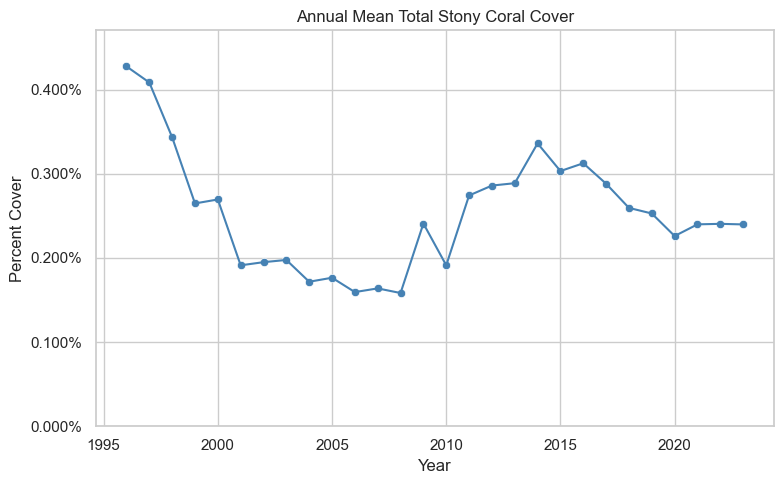

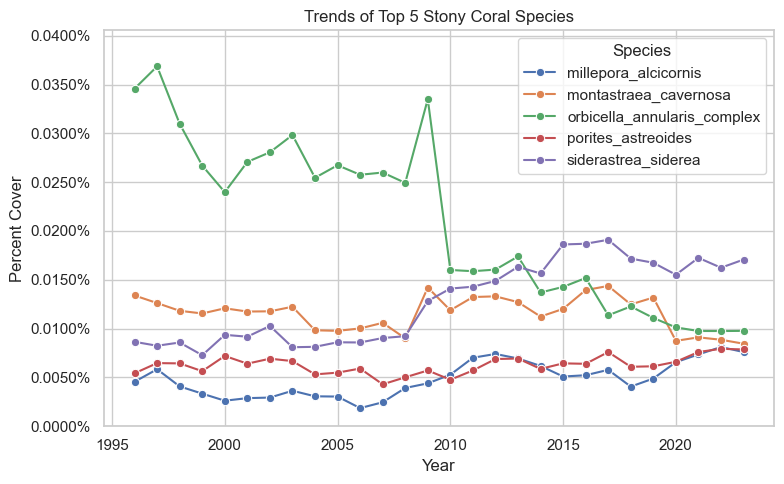

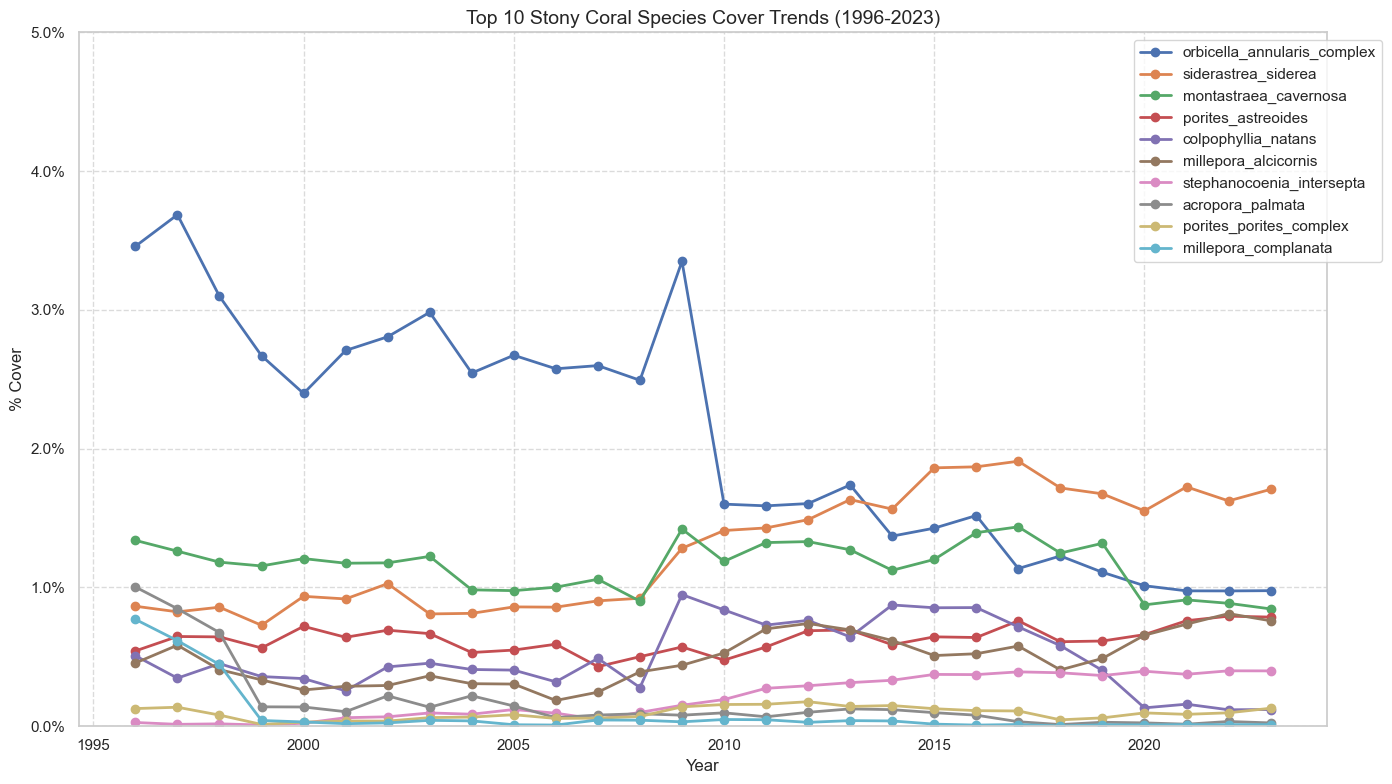

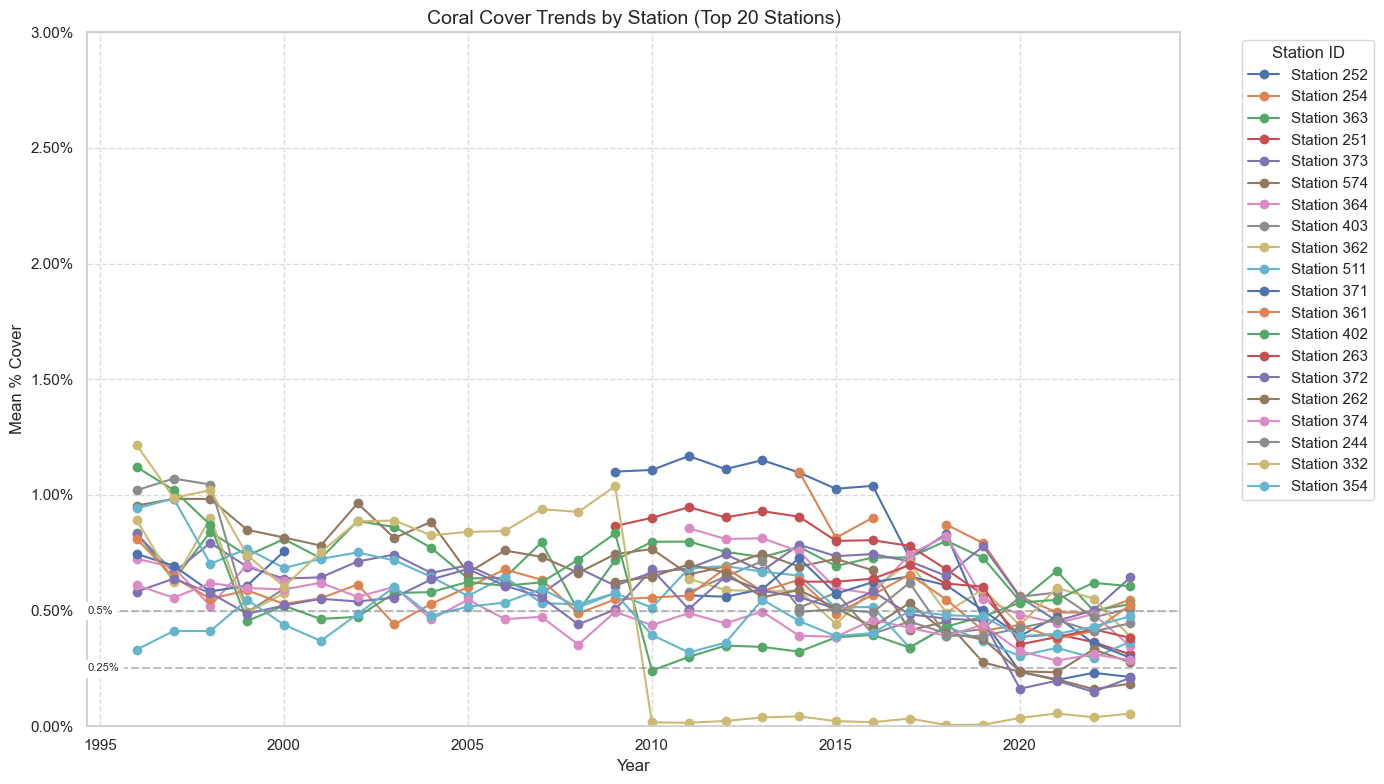

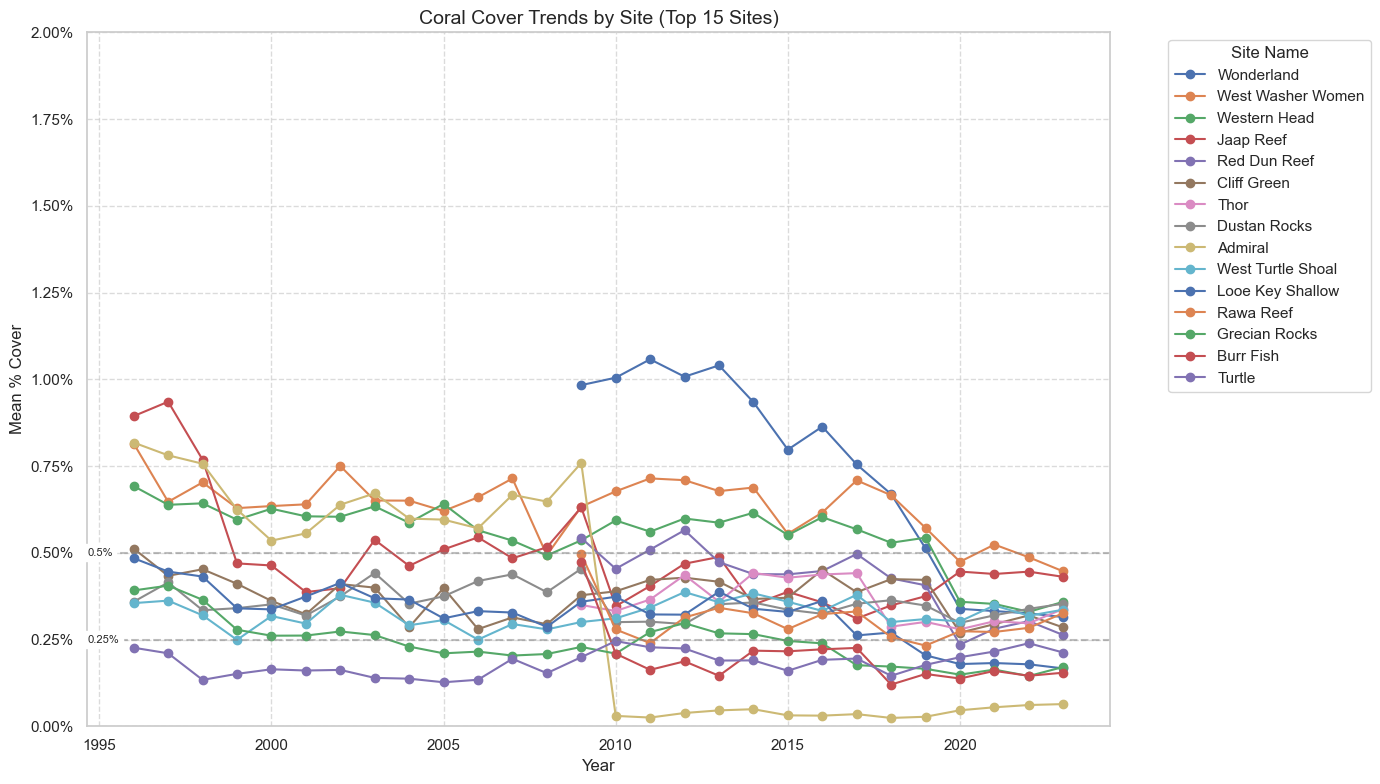

In [25]:
def run_section3():
    """
    Section 3: Percent cover analysis for stony coral species.
    Generates four plots:
    1. Overall annual mean total cover (scatter + line).
    2. Trends of top 5 species.
    3. Habitat-level distribution boxplot.
    4. Cover vs depth scatter.
    """
    import os
    import pandas as pd
    import numpy as np
    import matplotlib.pyplot as plt
    import seaborn as sns
    import matplotlib.ticker as mtick
    import sys
    import os
    # Try to import load_processed robustly
    try:
        # Try as a package first
        from My_work.Preprocessing import load_processed
    except ModuleNotFoundError:
        try:
            # Try as a module file
            sys.path.append(os.path.join(os.getcwd(), 'My_work'))
            import importlib.util
            import pathlib
            preprocessing_path = pathlib.Path(os.getcwd()) / 'My_work' / 'Preprocessing.py'
            spec = importlib.util.spec_from_file_location('Preprocessing', str(preprocessing_path))
            Preprocessing = importlib.util.module_from_spec(spec)
            spec.loader.exec_module(Preprocessing)
            load_processed = Preprocessing.load_processed
        except Exception as e:
            print('Could not import load_processed. sys.path:', sys.path)
            print('Current working directory:', os.getcwd())
            raise e

    # Create output directory for figures
    out_dir = os.path.join(os.getcwd(), "figures")
    os.makedirs(out_dir, exist_ok=True)

    # 1. Load annual summary from Excel
    excel_path = os.path.join(os.getcwd(), "My_work", "processed_data", "pstony_average.xlsx")
    df_avg = pd.read_excel(excel_path, sheet_name="Sheet1")
    # Clean headers and ensure Year column
    df_avg.columns = [str(c).strip() for c in df_avg.columns]
    # Find the column that contains 'year' (case-insensitive)
    year_col = next((c for c in df_avg.columns if 'year' in c.lower()), None)
    if year_col is None:
        year_col = df_avg.columns[0]
    df_avg.rename(columns={year_col: 'Year'}, inplace=True)
    # Identify and rename average column (prefer 'Average_by_Year', fallback to last column)
    avg_col = next((c for c in df_avg.columns if 'average' in c.lower()), df_avg.columns[-1])
    if avg_col != 'Avg_Total_Cover':
        df_avg.rename(columns={avg_col: 'Avg_Total_Cover'}, inplace=True)
    # Keep only numeric years
    df_avg = df_avg[df_avg['Year'].apply(lambda x: isinstance(x, (int, float)))]
    df_avg['Year'] = df_avg['Year'].astype(int)
    df_avg = df_avg[['Year', 'Avg_Total_Cover']]

    sns.set_style("whitegrid")

    # Plot 1: Overall decline
    fig1, ax1 = plt.subplots(figsize=(8, 5))
    sns.scatterplot(data=df_avg, x="Year", y="Avg_Total_Cover", color="steelblue", ax=ax1)
    sns.lineplot(data=df_avg, x="Year", y="Avg_Total_Cover", color="steelblue", ax=ax1)
    ax1.set_title("Annual Mean Total Stony Coral Cover")
    ax1.set_ylabel("Percent Cover")
    ax1.set_ylim(0, df_avg['Avg_Total_Cover'].max() * 1.1)
    ax1.yaxis.set_major_formatter(mtick.PercentFormatter())
    fig1.tight_layout()
    fig1.savefig(os.path.join(out_dir, "plot1_total_cover.png"), dpi=300)

    # 2. Load detailed percent-cover data
    df_pcover = load_processed("pcover_stony_species", version="with_stations")
    # Identify metadata vs species columns
    meta_prefixes = ['oid','year','date','subregion','habitat','site','station','surveyed','points','region','first','length','depth','lat','lon']
    meta_cols = [c for c in df_pcover.columns if any(c.lower().startswith(p) for p in meta_prefixes)]
    species_cols = [c for c in df_pcover.columns if c not in meta_cols]
    # Robustly detect the year column (case-insensitive)
    year_col = next((c for c in df_pcover.columns if c.lower().startswith('year')), None)
    if year_col is None:
        raise ValueError('No year column found in df_pcover.')
    # Melt to long format
    df_long = df_pcover.melt(id_vars=meta_cols, value_vars=species_cols,
                              var_name="Species", value_name="Cover")
    df_long['Cover'] = pd.to_numeric(df_long['Cover'], errors='coerce')
    df_long = df_long.dropna(subset=['Cover'])
    df_long[year_col] = df_long[year_col].astype(int)
    # Standardize year column to 'Year'
    df_long.rename(columns={year_col: 'Year'}, inplace=True)
    year_col = 'Year'

    # Plot 2: Top 5 species trends
    species_mean = df_long.groupby('Species')['Cover'].mean().sort_values(ascending=False)
    top5 = species_mean.head(5).index.tolist()
    df_top5 = df_long[df_long['Species'].isin(top5)]
    df_top5_year = df_top5.groupby([year_col, 'Species'])['Cover'].mean().reset_index()
    fig2, ax2 = plt.subplots(figsize=(8, 5))
    sns.lineplot(data=df_top5_year, x=year_col, y='Cover', hue='Species', marker='o', ax=ax2)
    ax2.set_title("Trends of Top 5 Stony Coral Species")
    ax2.set_ylabel("Percent Cover")
    ax2.set_ylim(0, df_top5_year['Cover'].max() * 1.1)
    ax2.yaxis.set_major_formatter(mtick.PercentFormatter())
    fig2.tight_layout()
    fig2.savefig(os.path.join(out_dir, "plot2_top5_species.png"), dpi=300)

    # Plot 3: Subregion-level bar plot vs Year
    if 'subregion' in df_long.columns:
        # Compute mean cover per year and subregion
        df_subregion_year = df_long.groupby([year_col, 'subregion'])['Cover'].mean().reset_index()
        fig3, ax3 = plt.subplots(figsize=(10, 6))
        sns.barplot(data=df_subregion_year, x=year_col, y='Cover', hue='subregion', ax=ax3)
        ax3.set_title("Mean Percent Cover by Subregion and Year")
        ax3.set_xlabel("Year")
        ax3.set_ylabel("Percent Cover")
        ax3.yaxis.set_major_formatter(mtick.PercentFormatter())
        plt.xticks(rotation=45, ha='right')
        fig3.tight_layout()
        fig3.savefig(os.path.join(out_dir, "plot3_subregion_bar.png"), dpi=300)

    plt.show()

   
        
    # Get annual means and years
    
    
    # For the remaining graphs, we'll need to use the processed data
    # Load processed tables
    df_pcover = load_processed("pcover_stony_species", version="with_stations")
    
    # Define metadata columns
    meta_cols = [col for col in df_pcover.columns if any(col.lower().startswith(prefix) for prefix in 
                ['oid', 'year', 'date', 'subregion', 'habitat', 'site', 'station', 
                 'surveyed', 'points', 'region', 'first', 'length', 'depth', 'lat', 'lon'])]
    
    # Identify species columns by excluding metadata columns
    species_cols = [c for c in df_pcover.columns if c not in meta_cols]
    
    # Detect and standardize the year column
    year_col2 = next((c for c in df_pcover.columns if c.lower().startswith('year')), None)
    if year_col2 is None:
        raise ValueError('No year column found in df_pcover for species_year.')
    df_pcover[year_col2] = df_pcover[year_col2].astype(int)
    if year_col2 != 'Year':
        df_pcover.rename(columns={year_col2: 'Year'}, inplace=True)
    # Now always use 'Year'
    # Convert species columns to numeric
    for c in species_cols:
        df_pcover.loc[:, c] = pd.to_numeric(df_pcover[c], errors='coerce')
    
    # Build species x year table
    species_year = (
        df_pcover.groupby('Year')[species_cols]
          .mean()   # index=year, columns=species
          .T        # index=species, columns=year
    )
    
    # Calculate mean cover for all species per row
    df_pcover.loc[:, 'mean_all_cover'] = df_pcover[species_cols].mean(axis=1)
    
    # GRAPH 2: Top 10 Species Trends
    # Make sure we have enough species
    num_species = min(10, len(species_year))
    top_species = species_year.mean(axis=1).sort_values(ascending=False).head(num_species).index
    
    plt.figure(figsize=(14, 8))
    for species in top_species:
        plt.plot(species_year.columns, species_year.loc[species], marker='o', linewidth=2, label=species)
    
    plt.title(f'Top {num_species} Stony Coral Species Cover Trends (1996-2023)', fontsize=14)
    plt.xlabel('Year', fontsize=12)
    plt.ylabel('% Cover', fontsize=12)
    plt.legend(loc='upper right', bbox_to_anchor=(1.05, 1))
    plt.grid(True, linestyle='--', alpha=0.7)
    
    # Format y-axis as percentage with correct scaling (0.42% not 42%)
    plt.gca().yaxis.set_major_formatter(mtick.PercentFormatter(1.0))
    
    # Set y-axis limit to 5% as specified
    plt.ylim(0, 0.05)
    
    plt.tight_layout()
    plt.show()
    
    # GRAPH 3: Station-specific analysis
    # Detect and standardize the year column for station_df
    year_col_station = next((c for c in df_pcover.columns if c.lower().startswith('year')), None)
    if year_col_station is None:
        raise ValueError('No year column found in df_pcover for station_df.')
    if year_col_station != 'Year':
        df_pcover.rename(columns={year_col_station: 'Year'}, inplace=True)
    station_df = df_pcover.groupby(['stationid', 'Year'])['mean_all_cover'].mean().unstack('stationid')
    
    if not station_df.empty:
        # Select top stations for better visualization
        num_stations = min(20, station_df.shape[1])
        top_stations = station_df.mean().sort_values(ascending=False).head(num_stations).index
        station_df_top = station_df[top_stations]
        
        plt.figure(figsize=(14, 8))
        for station in station_df_top.columns:
            plt.plot(station_df_top.index, station_df_top[station], marker='o', linewidth=1.5, label=f'Station {station}')
        
        plt.title(f'Coral Cover Trends by Station (Top {num_stations} Stations)', fontsize=14)
        plt.xlabel('Year', fontsize=12)
        plt.ylabel('Mean % Cover', fontsize=12)
        plt.grid(True, linestyle='--', alpha=0.7)
        
        # Format y-axis as percentage with correct scaling (0.42% not 42%)
        plt.gca().yaxis.set_major_formatter(mtick.PercentFormatter(1.0))
        
        # Set y-axis limit to 3% as specified
        plt.ylim(0, 0.03)
        
        # Add horizontal lines at 0.25% and 0.5%
        plt.axhline(y=0.0025, color='gray', linestyle='--', alpha=0.5)
        plt.axhline(y=0.005, color='gray', linestyle='--', alpha=0.5)
        
        # Add text labels for the horizontal lines
        plt.text(plt.xlim()[0], 0.0025, '0.25%', va='center', ha='left', backgroundcolor='white', fontsize=8)
        plt.text(plt.xlim()[0], 0.005, '0.5%', va='center', ha='left', backgroundcolor='white', fontsize=8)
        
        plt.legend(title='Station ID', bbox_to_anchor=(1.05, 1), loc='upper left')
        plt.tight_layout()
        plt.show()
    
    # GRAPH 4: Site-based analysis
    # Detect and standardize the site_name column for site_trends
    site_col = next((c for c in df_pcover.columns if c.lower().replace('_','').startswith('sitename')), None)
    if site_col is None:
        raise ValueError('No site_name column found in df_pcover for site_trends.')
    if site_col != 'site_name':
        df_pcover.rename(columns={site_col: 'site_name'}, inplace=True)
    # Detect and standardize the year column as well
    year_col_site = next((c for c in df_pcover.columns if c.lower().startswith('year')), None)
    if year_col_site != 'Year':
        df_pcover.rename(columns={year_col_site: 'Year'}, inplace=True)
    site_trends = df_pcover.groupby(['site_name', 'Year'])['mean_all_cover'].mean().unstack('site_name')
    
    if not site_trends.empty:
        # Select top sites for better visualization
        num_sites = min(15, site_trends.shape[1])
        top_sites = site_trends.mean().sort_values(ascending=False).head(num_sites).index
        site_trends_top = site_trends[top_sites]
        
        plt.figure(figsize=(14, 8))
        for site in site_trends_top.columns:
            plt.plot(site_trends_top.index, site_trends_top[site], marker='o', linewidth=1.5, label=site)
        
        plt.title(f'Coral Cover Trends by Site (Top {num_sites} Sites)', fontsize=14)
        plt.xlabel('Year', fontsize=12)
        plt.ylabel('Mean % Cover', fontsize=12)
        plt.grid(True, linestyle='--', alpha=0.7)
        
        # Format y-axis as percentage with correct scaling (0.42% not 42%)
        plt.gca().yaxis.set_major_formatter(mtick.PercentFormatter(1.0))
        
        # Set y-axis limit to 2% as specified
        plt.ylim(0, 0.02)
        
        # Add horizontal lines at 0.25% and 0.5%
        plt.axhline(y=0.0025, color='gray', linestyle='--', alpha=0.5)
        plt.axhline(y=0.005, color='gray', linestyle='--', alpha=0.5)
        
        # Add text labels for the horizontal lines
        plt.text(plt.xlim()[0], 0.0025, '0.25%', va='center', ha='left', backgroundcolor='white', fontsize=8)
        plt.text(plt.xlim()[0], 0.005, '0.5%', va='center', ha='left', backgroundcolor='white', fontsize=8)
        
        plt.legend(title='Site Name', bbox_to_anchor=(1.05, 1), loc='upper left')
        plt.tight_layout()
        plt.show()

run_section3()


### Section 4 – Stony Coral Species Richness Trends

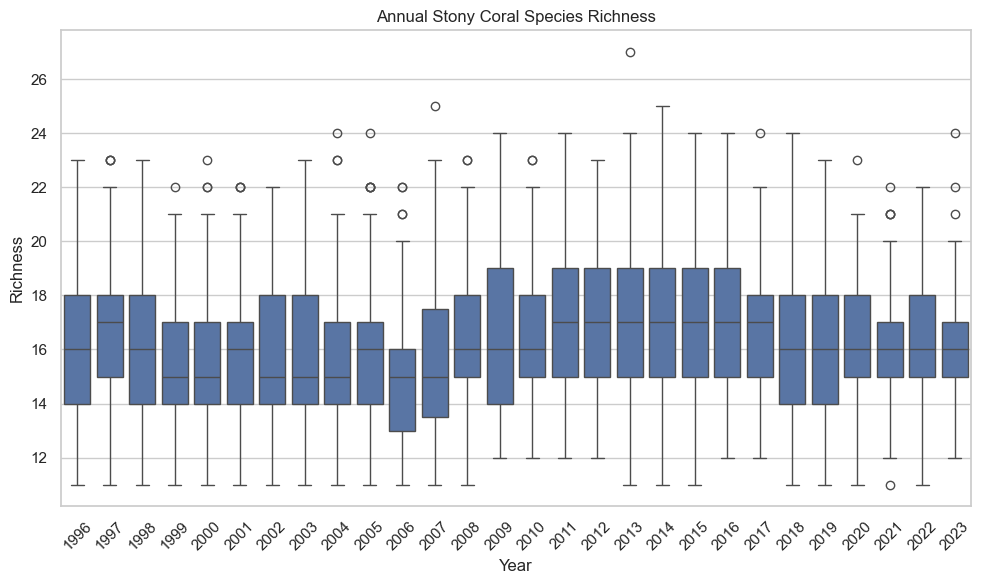

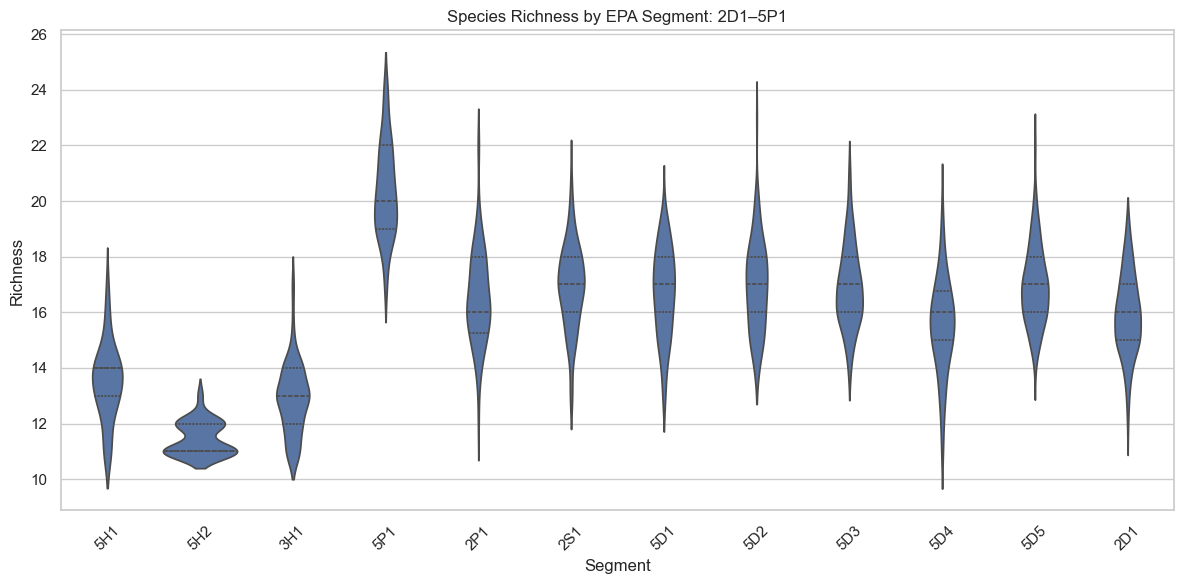

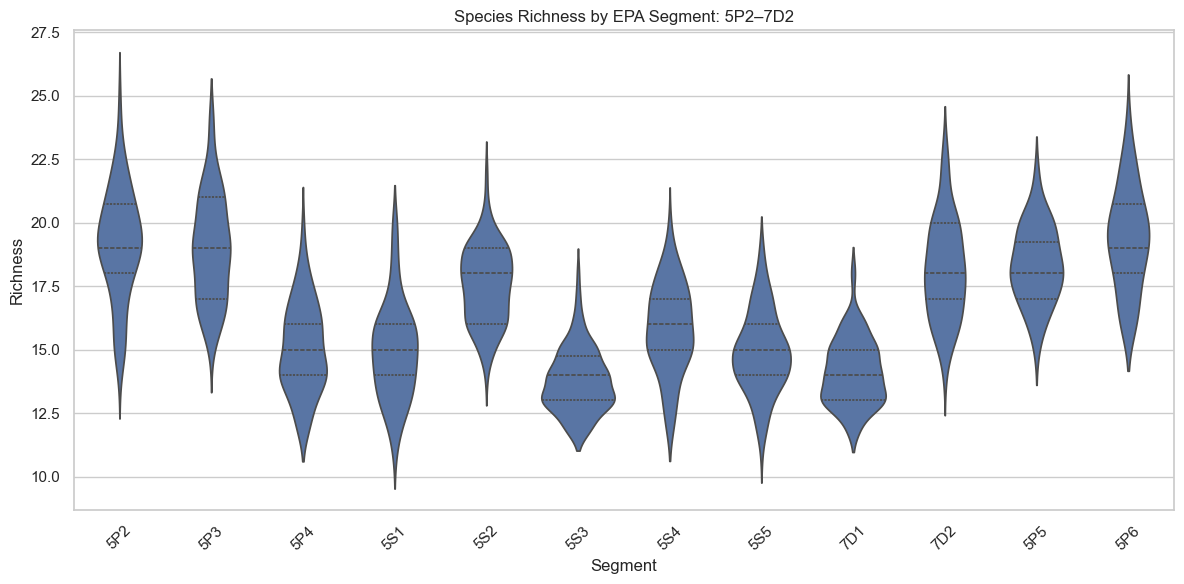

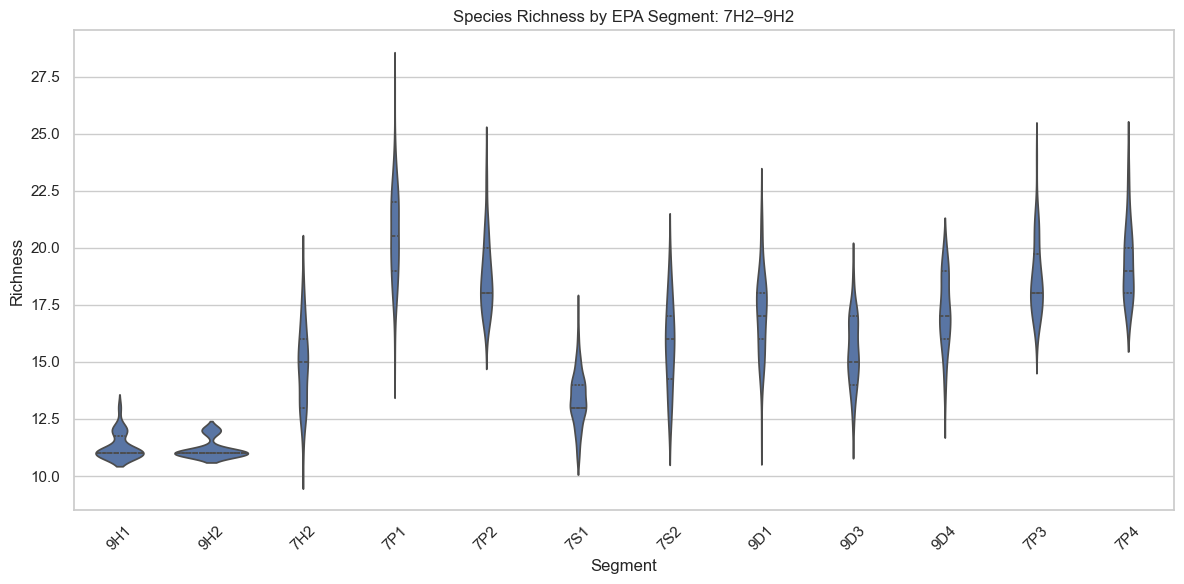

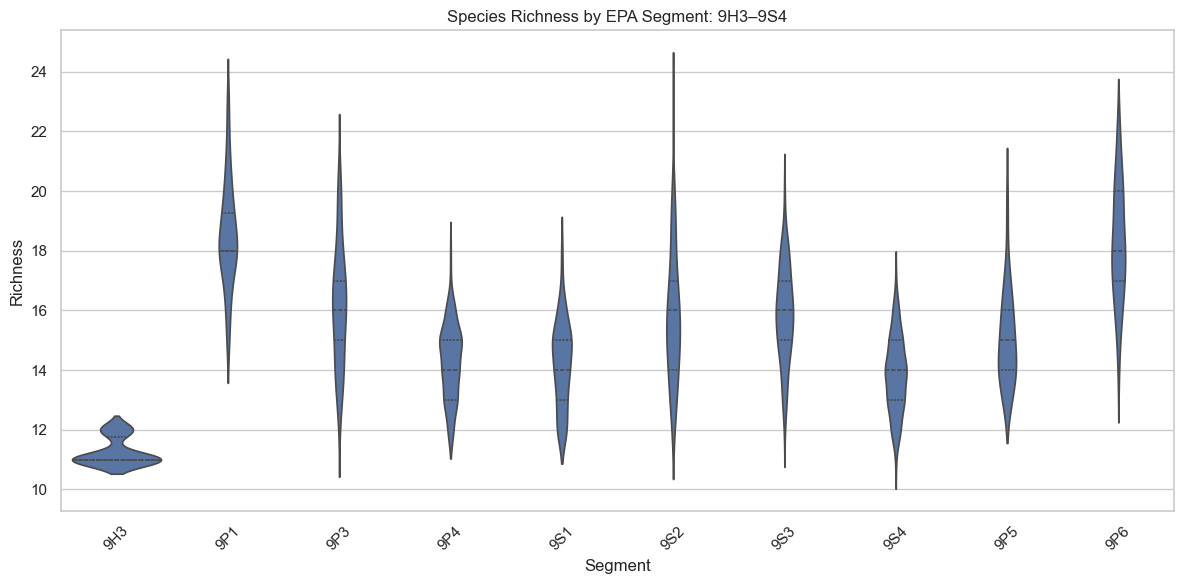

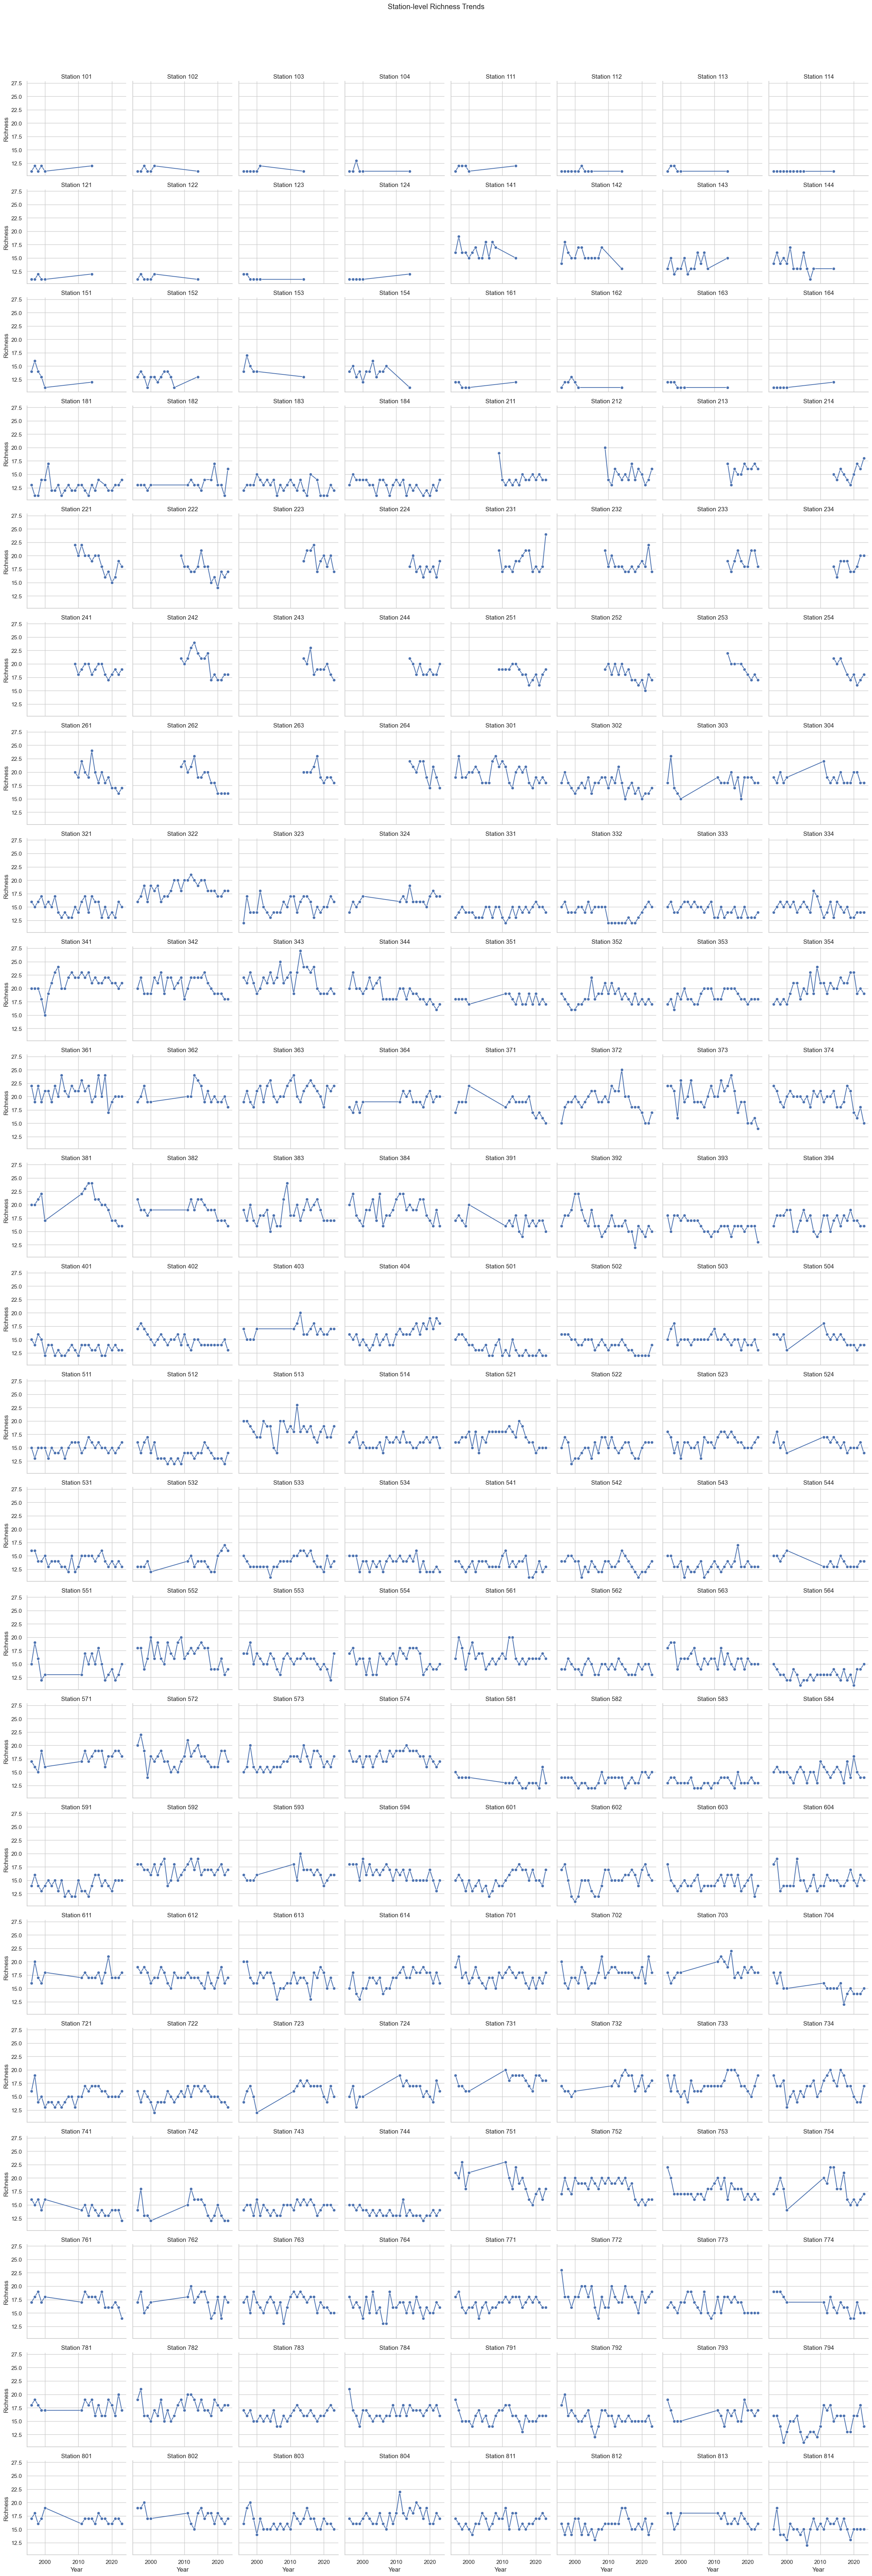

Pearson r: 0.145 (p=9.656e-20), Spearman r: 0.243 (p=1.265e-53)


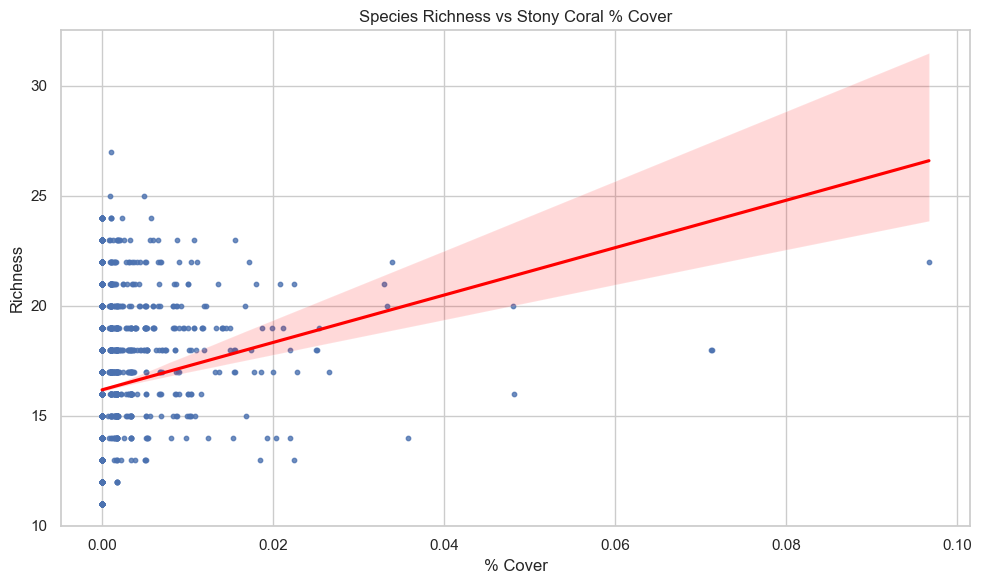

In [12]:
"""
Module: Section 4 – Stony Coral Species Richness Trends
Generates four plots:
1. Annual species richness distribution by year
2. Richness by EPA segment
3. Station-level richness trends
4. Scatter of richness vs % cover
"""
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from My_work.Preprocessing import load_processed

def run_section4():
    """
    Create four exploratory plots for stony coral species richness.
    Loads data from processed_data/with_stations for full view including outliers.
    """
    # load processed tables
    df_pcover = load_processed("pcover_stony_species", version="with_stations")
    # compute richness (# species with >0 cover)
    species_cols = [c for c in df_pcover.columns if c not in (
        ['oid_','year','date','subregion','habitat','siteid',
         'site_name','stationid','surveyed_all_years','points']
    )]
    # exclude site_code so it's not coerced to NaN
    if 'site_code' in species_cols:
        species_cols.remove('site_code')
    df = df_pcover.copy()
    # convert species columns to numeric to avoid type errors
    df[species_cols] = df[species_cols].apply(pd.to_numeric, errors='coerce')
    df['richness'] = (df[species_cols] > 0).sum(axis=1)
    # drop rows missing EPA segment codes
    df = df.dropna(subset=['site_code'])

    # 1. Annual richness boxplot
    plt.figure()
    sns.boxplot(x='year', y='richness', data=df)
    plt.title('Annual Stony Coral Species Richness')
    plt.xlabel('Year')
    plt.ylabel('Richness')
    plt.xticks(rotation=45)
    plt.tight_layout()
    plt.show()

    # 2. Richness by EPA segment (show 12 segments per plot)
    segments = sorted(df['site_code'].unique())
    for i in range(0, len(segments), 12):
        chunk = segments[i:i+12]
        plt.figure(figsize=(12, 6))
        sns.violinplot(x='site_code', y='richness',
                       data=df[df['site_code'].isin(chunk)], inner='quartile')
        plt.title(f'Species Richness by EPA Segment: {chunk[0]}–{chunk[-1]}')
        plt.xlabel('Segment')
        plt.ylabel('Richness')
        plt.xticks(rotation=45)
        plt.tight_layout()
        plt.show()

    # 3. Station-level trends (show 8 station graphs at a time)
    g = sns.FacetGrid(df, col='stationid', col_wrap=8, height=3)
    g.map_dataframe(sns.lineplot, x='year', y='richness', marker='o')
    g.set_titles('Station {col_name}')
    g.set_axis_labels('Year', 'Richness')
    g.fig.suptitle('Station-level Richness Trends', y=1.02)
    plt.tight_layout()
    plt.show()

    # 4. Richness vs % cover
    # use scleractinia as % cover
    df_plot = df.copy()
    df_plot['scleractinia'] = pd.to_numeric(df_plot['scleractinia'], errors='coerce')
    from scipy.stats import pearsonr, spearmanr
    x = df_plot['scleractinia'].dropna()
    y = df_plot.loc[x.index, 'richness']
    pear_r, pear_p = pearsonr(x, y)
    spear_r, spear_p = spearmanr(x, y)
    print(f"Pearson r: {pear_r:.3f} (p={pear_p:.4g}), Spearman r: {spear_r:.3f} (p={spear_p:.4g})")
    plt.figure()
    sns.regplot(x='scleractinia', y='richness', data=df_plot,
                scatter_kws={'s':10}, line_kws={'color':'red'})
    plt.title('Species Richness vs Stony Coral % Cover')
    plt.xlabel('% Cover')
    plt.ylabel('Richness')
    plt.tight_layout()
    plt.show()

run_section4()


### Section 5 – Octocoral Density Dynamics

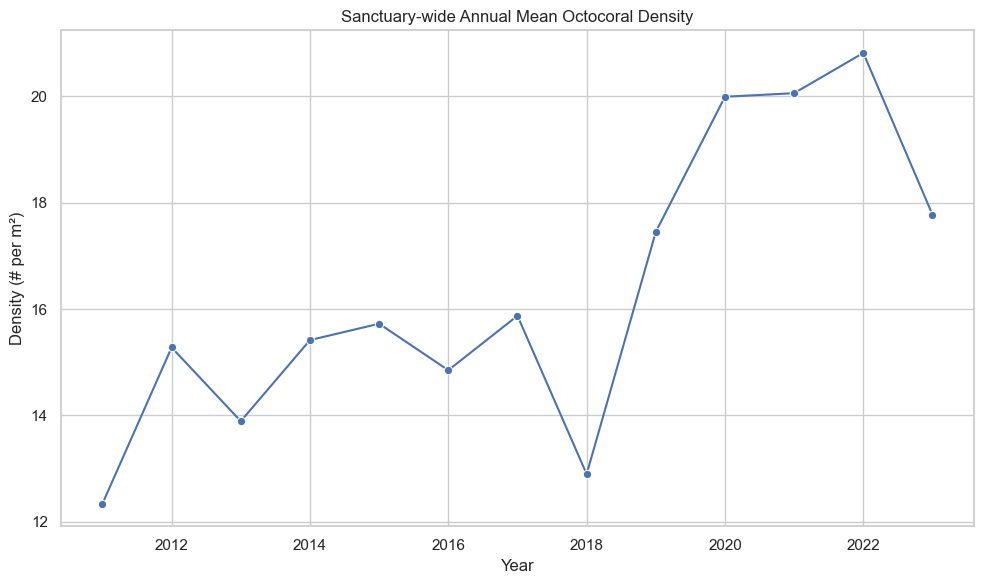

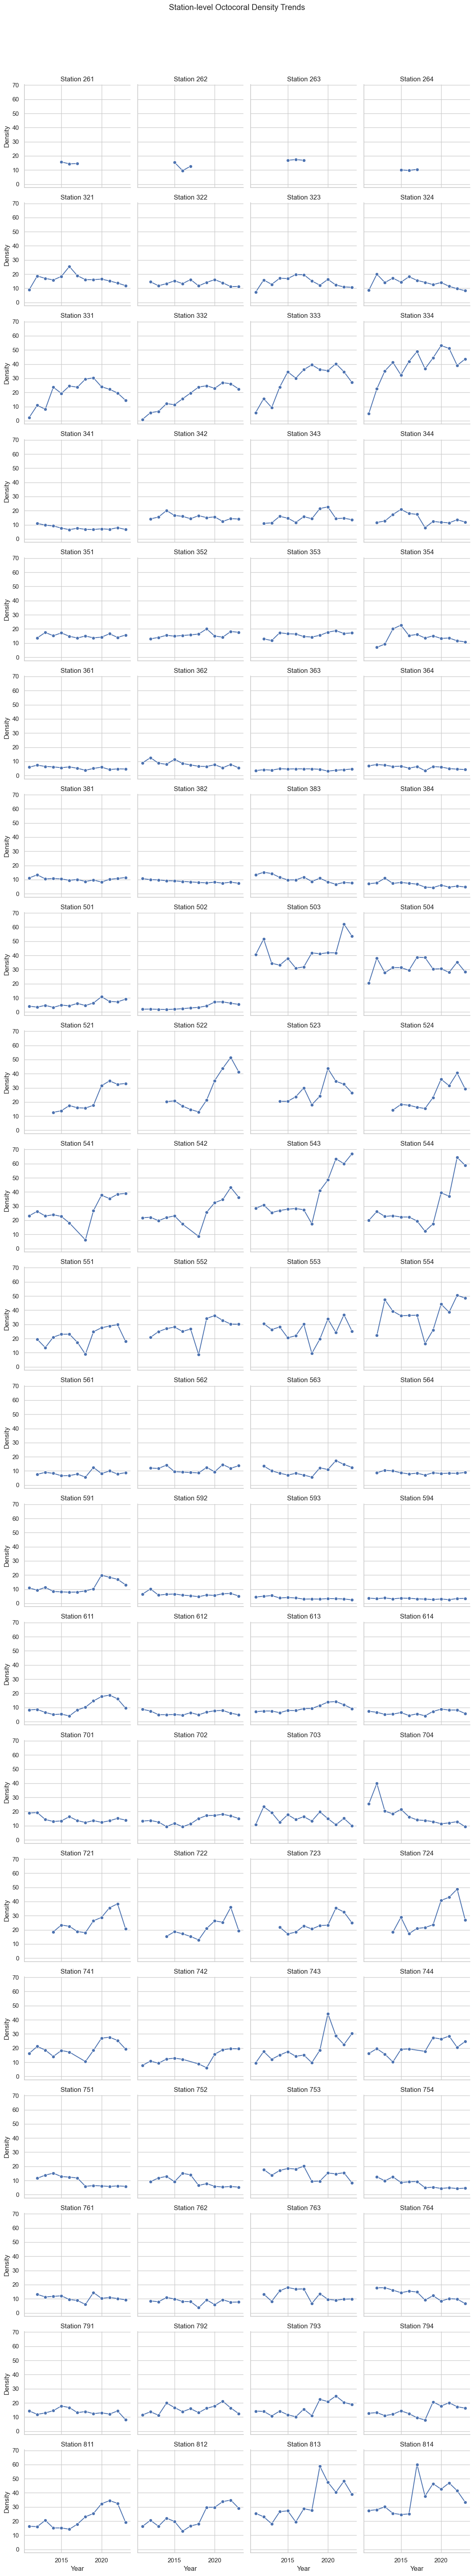

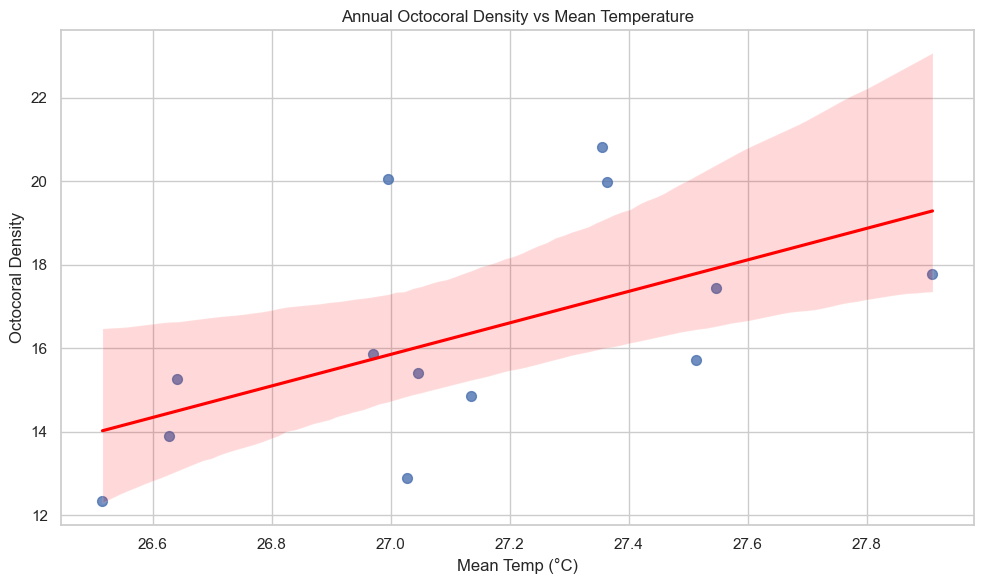

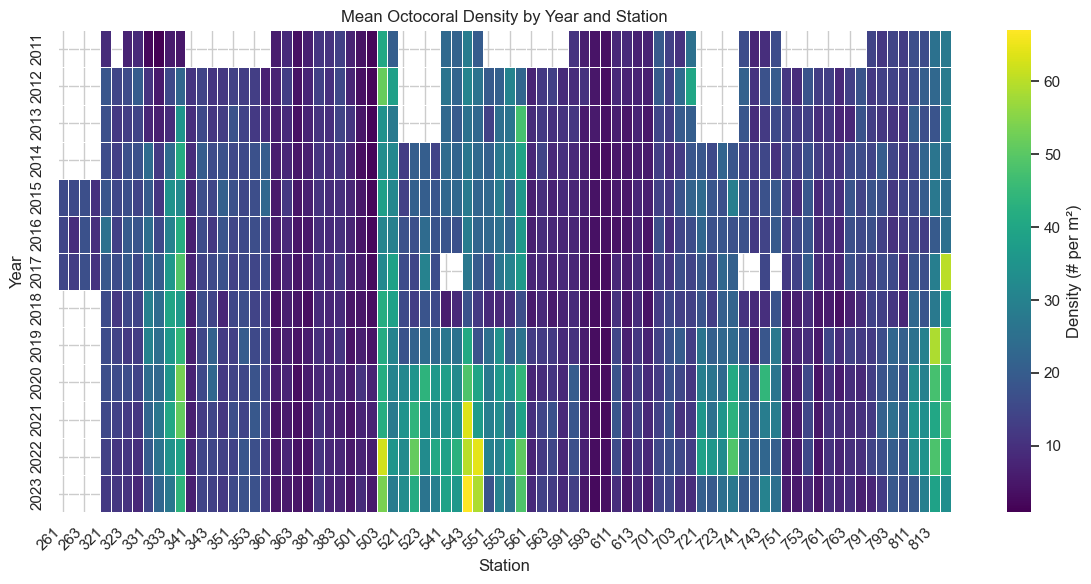

In [ ]:
def run_section5():
    """
    Create four exploratory plots for octocoral density trends.
    Loads data from processed_data/with_stations including outliers for discussion.
    """
    # load processed tables
    df_octo = load_processed("octo_density_summary", version="with_stations")
    df_temp = pd.read_csv("My_work/processed_data/temperature_monthly_features.csv")
    df_temp = df_temp.rename(columns={'tempc_month_mean':'temp_mean', 'siteid':'stationid'})
    df_stations = load_processed("stations", version="with_stations")

    # ensure numeric
    df = df_octo.copy()
    df['total_octocorals'] = pd.to_numeric(df['total_octocorals'], errors='coerce')

    # 1. Sanctuary-wide annual mean density
    annual = df.groupby('year')['total_octocorals'].mean().reset_index()
    plt.figure()
    sns.lineplot(data=annual, x='year', y='total_octocorals', marker='o')
    plt.title('Sanctuary-wide Annual Mean Octocoral Density')
    plt.xlabel('Year')
    plt.ylabel('Density (# per m²)')
    plt.tight_layout()
    plt.show()

    # 2. Station-level trends
    g = sns.FacetGrid(df, col='stationid', col_wrap=4, height=3)
    g.map_dataframe(sns.lineplot, x='year', y='total_octocorals', marker='o')
    g.set_titles('Station {col_name}')
    g.set_axis_labels('Year', 'Density')
    g.fig.suptitle('Station-level Octocoral Density Trends', y=1.02)
    plt.tight_layout()
    plt.show()

    # 3. Density vs mean annual temperature
    # prepare temp
    temp_annual = df_temp.groupby('year')['temp_mean'].mean().reset_index()
    df_join = annual.merge(temp_annual, on='year', how='left')
    plt.figure()
    sns.regplot(data=df_join, x='temp_mean', y='total_octocorals', scatter_kws={'s':50}, line_kws={'color':'red'})
    plt.title('Annual Octocoral Density vs Mean Temperature')
    plt.xlabel('Mean Temp (°C)')
    plt.ylabel('Octocoral Density')
    plt.tight_layout()
    plt.show()

    # 4. Heatmap: year × station
    pivot = df.pivot_table(index='year', columns='stationid', values='total_octocorals', aggfunc='mean')
    # annotate only densities above overall mean
    threshold = pivot.values.mean()
    annot = pivot.where(pivot >= threshold).round(1).astype(str)
    annot = annot.replace('nan', '')
    plt.figure(figsize=(12, 6))  # larger for clarity
    ax = sns.heatmap(
        pivot, annot=annot, fmt='',
        cmap='viridis', linewidths=0.5, linecolor='white',
        annot_kws={'fontsize':7, 'fontweight':'bold'},
        cbar_kws={'label':'Density (# per m²)'}
    )
    ax.set_xticklabels(ax.get_xticklabels(), rotation=45, ha='right')
    plt.title('Mean Octocoral Density by Year and Station')
    plt.ylabel('Year')
    plt.xlabel('Station')
    plt.tight_layout()
    plt.show()

run_section5()


### Section 6 – Living Tissue Area Differences

C:\Users\devgu\AppData\Local\Temp\ipykernel_13988\3981518225.py:29: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(x='stationid', y='lta', data=df_chunk, palette='vlag')


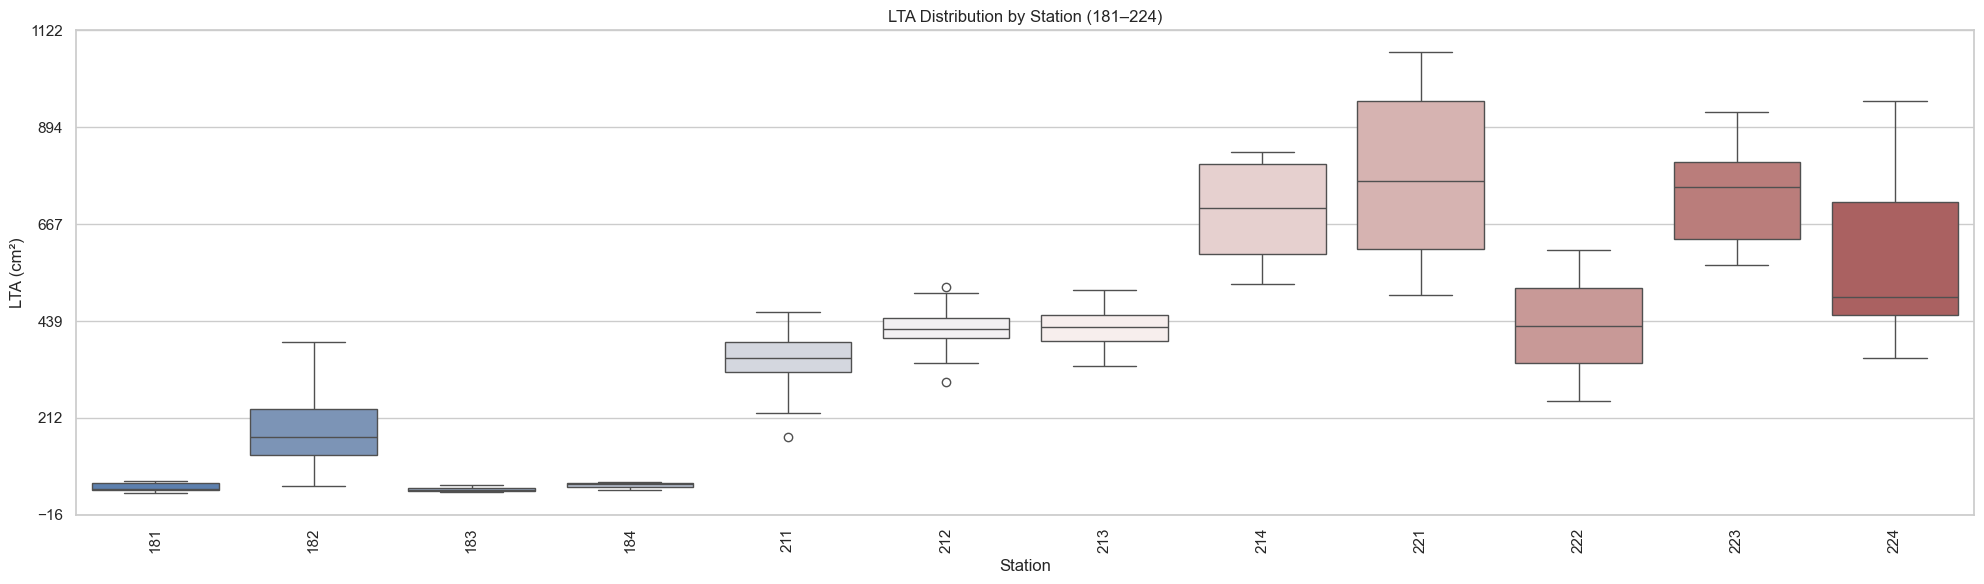

C:\Users\devgu\AppData\Local\Temp\ipykernel_13988\3981518225.py:29: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(x='stationid', y='lta', data=df_chunk, palette='vlag')


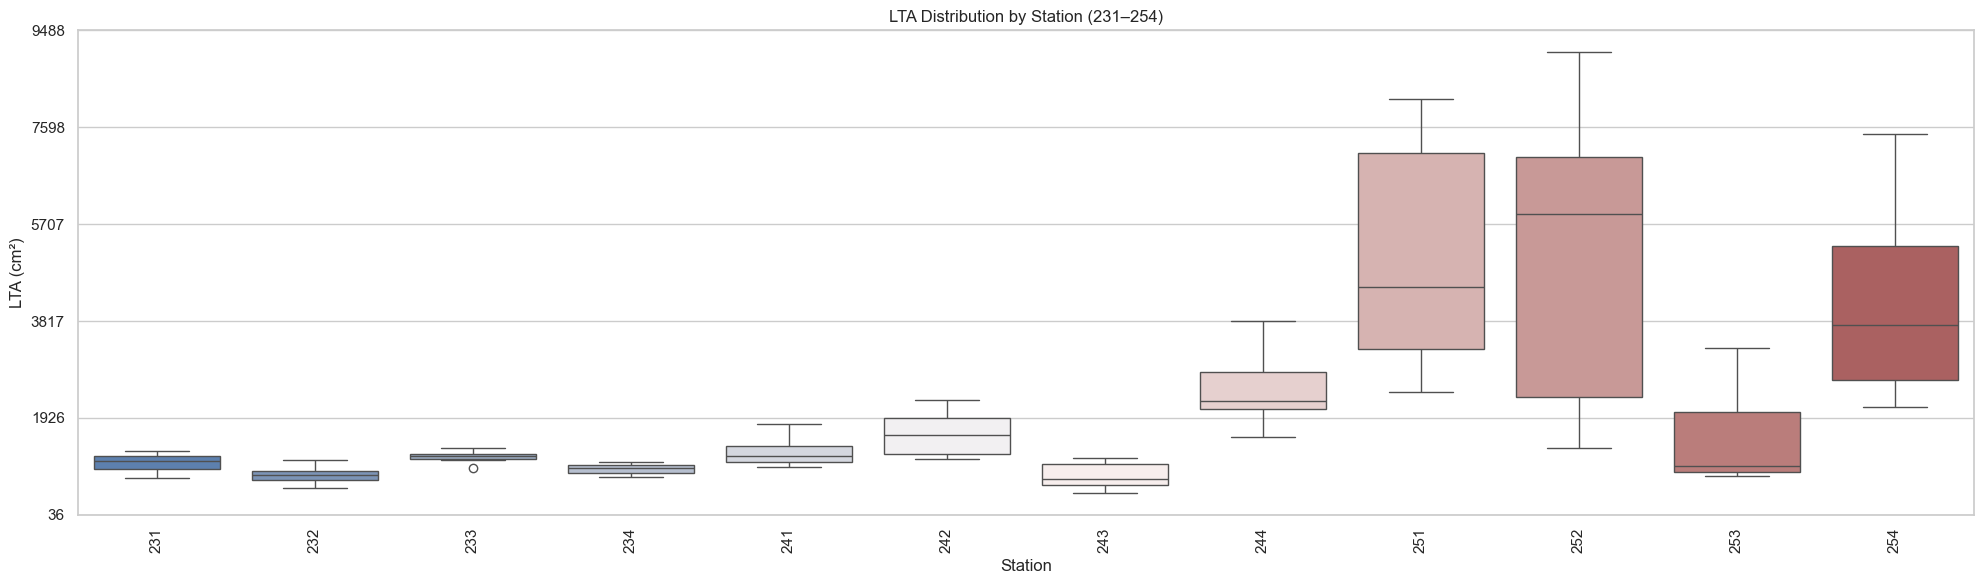

C:\Users\devgu\AppData\Local\Temp\ipykernel_13988\3981518225.py:29: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(x='stationid', y='lta', data=df_chunk, palette='vlag')


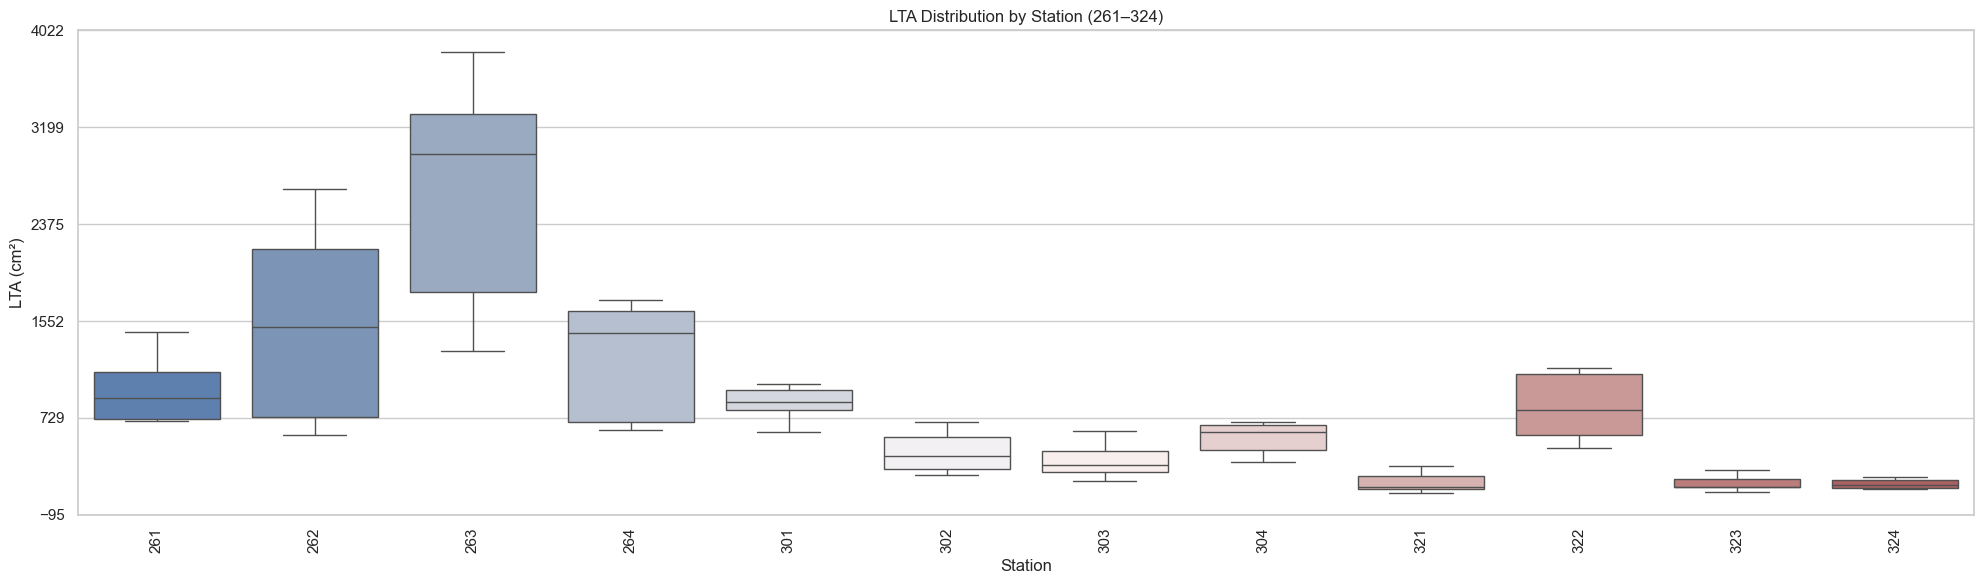

C:\Users\devgu\AppData\Local\Temp\ipykernel_13988\3981518225.py:29: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(x='stationid', y='lta', data=df_chunk, palette='vlag')


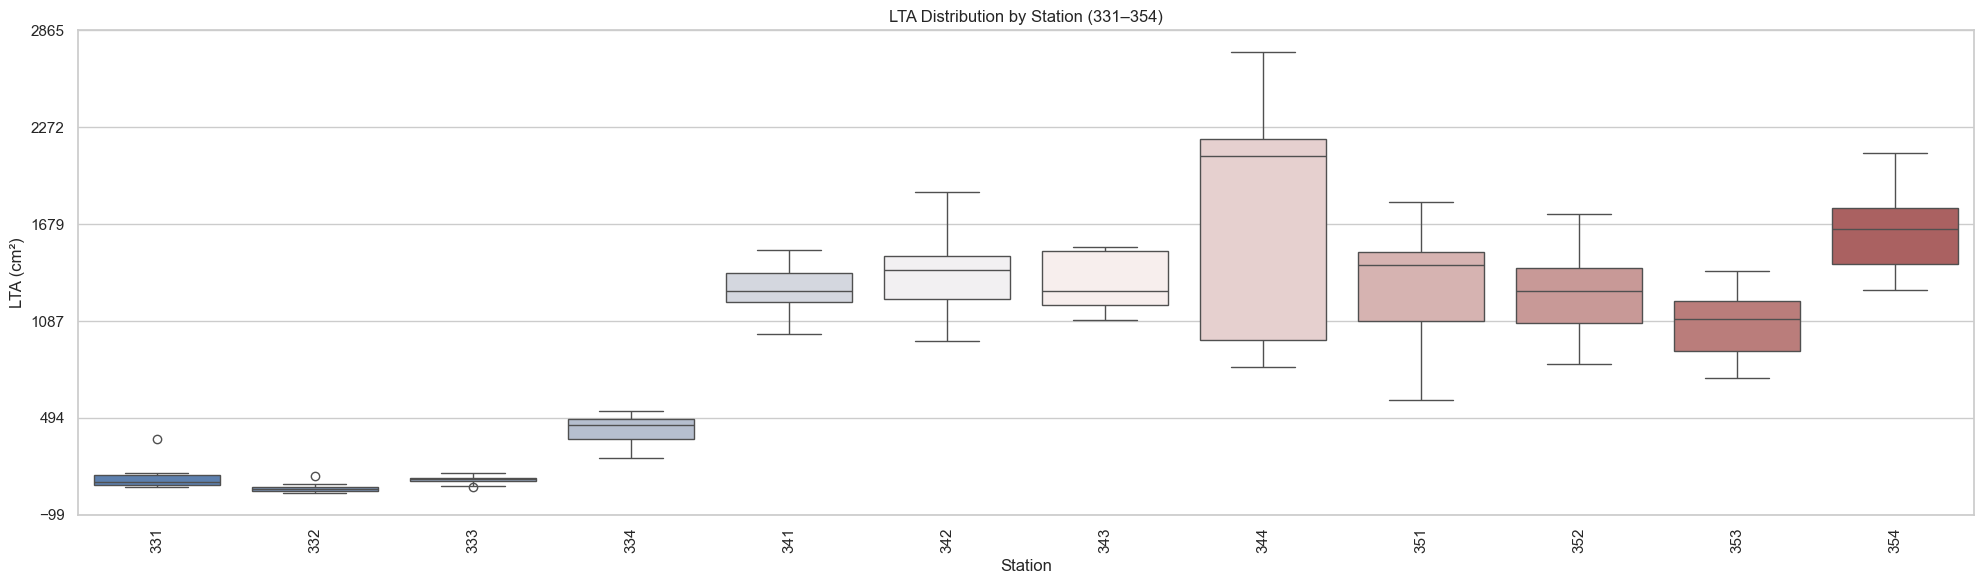

C:\Users\devgu\AppData\Local\Temp\ipykernel_13988\3981518225.py:29: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(x='stationid', y='lta', data=df_chunk, palette='vlag')


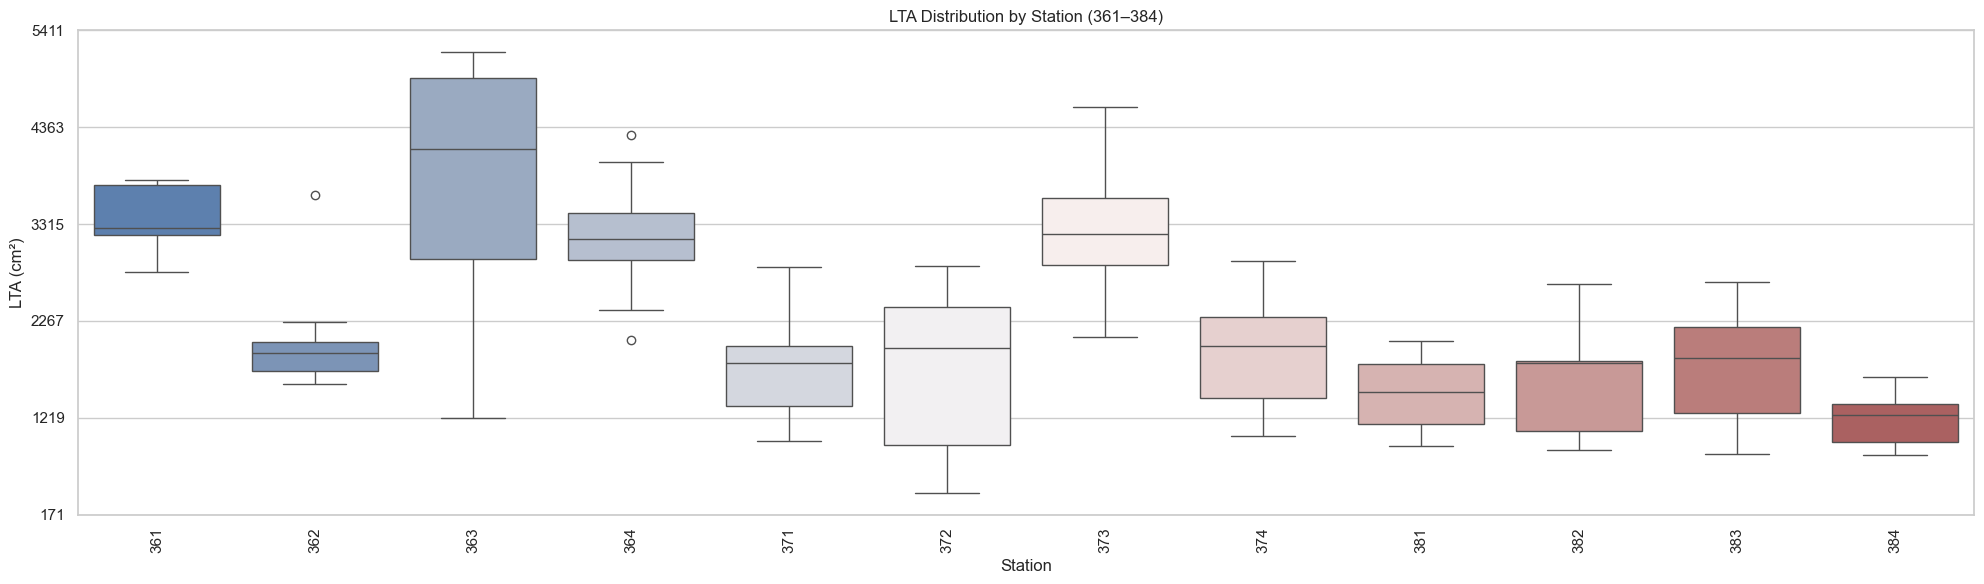

C:\Users\devgu\AppData\Local\Temp\ipykernel_13988\3981518225.py:29: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(x='stationid', y='lta', data=df_chunk, palette='vlag')


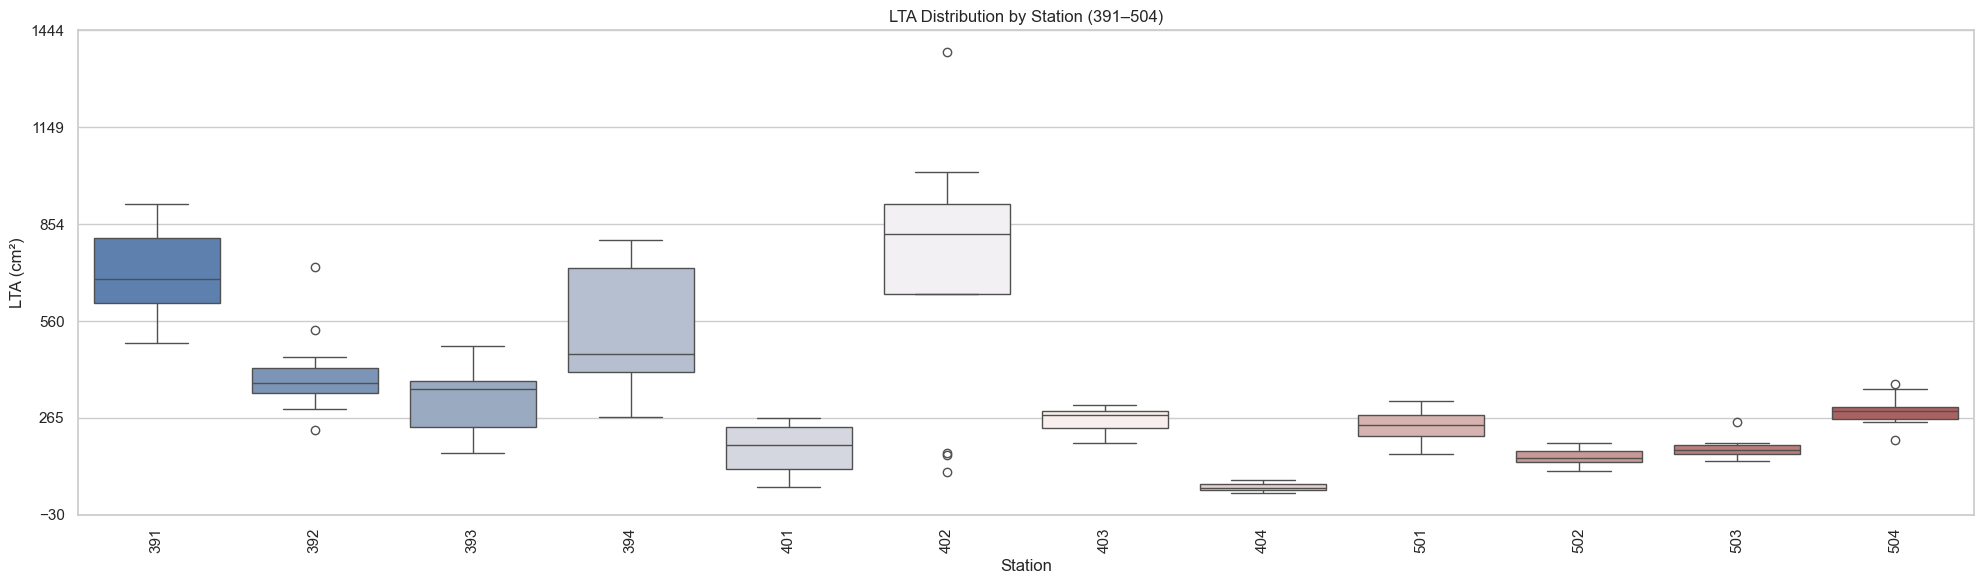

C:\Users\devgu\AppData\Local\Temp\ipykernel_13988\3981518225.py:29: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(x='stationid', y='lta', data=df_chunk, palette='vlag')


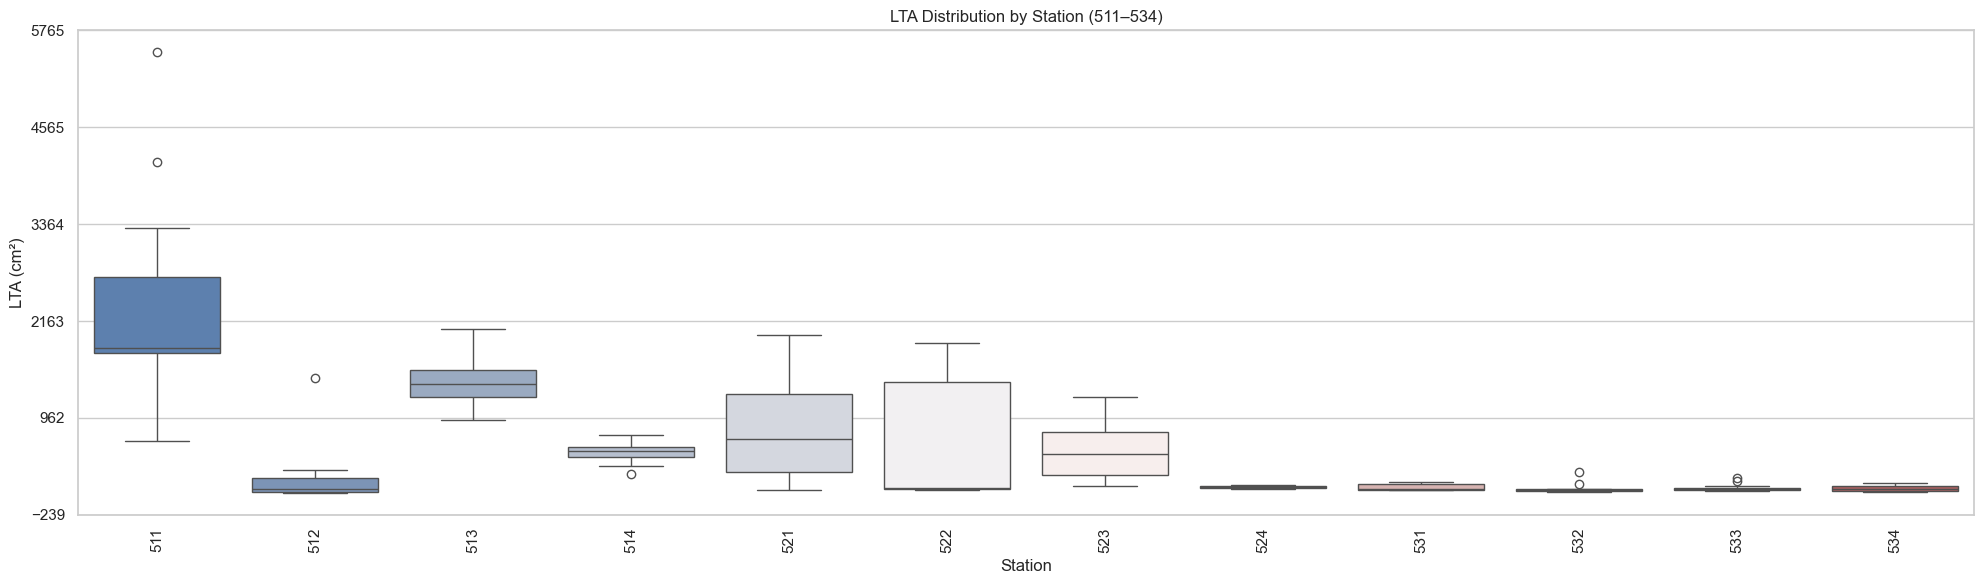

C:\Users\devgu\AppData\Local\Temp\ipykernel_13988\3981518225.py:29: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(x='stationid', y='lta', data=df_chunk, palette='vlag')


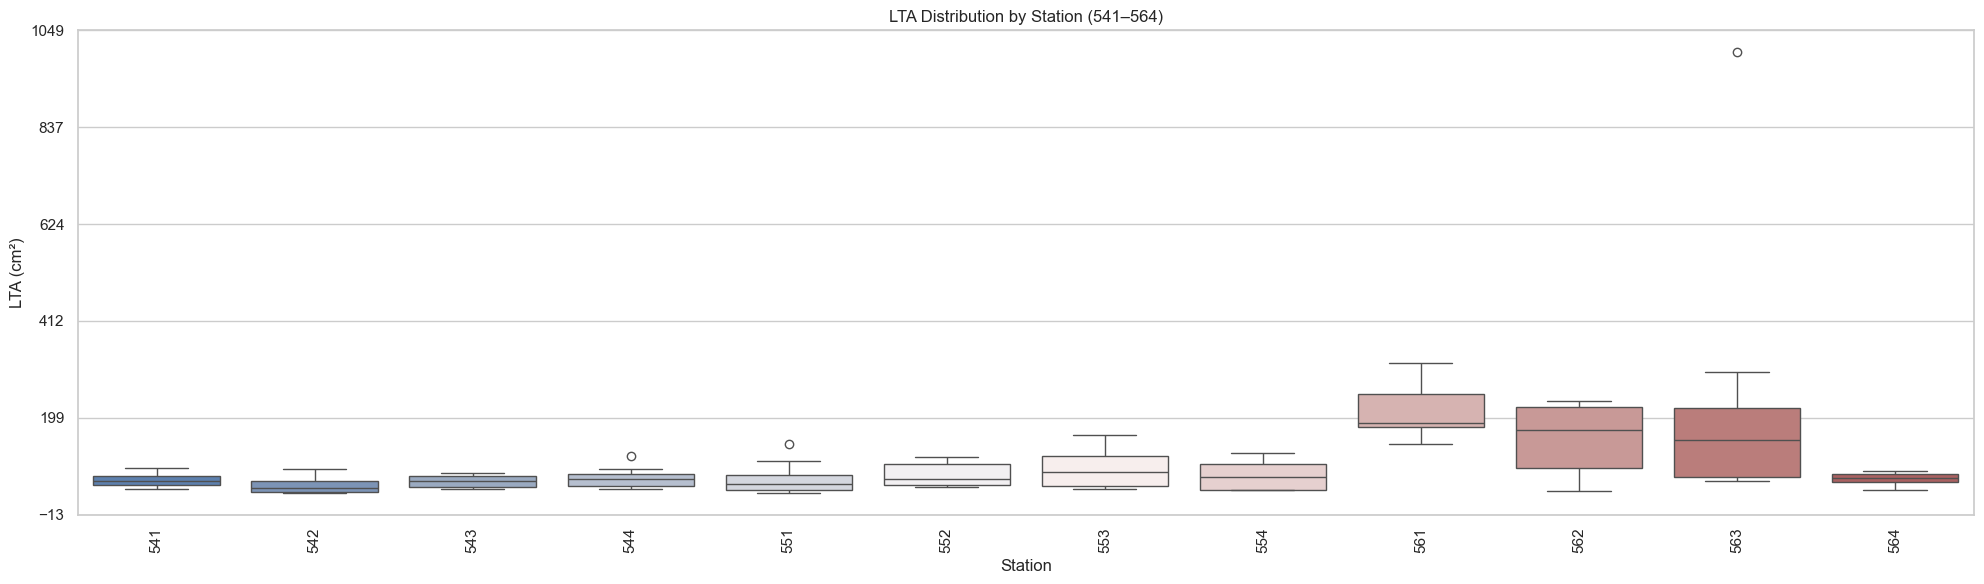

C:\Users\devgu\AppData\Local\Temp\ipykernel_13988\3981518225.py:29: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(x='stationid', y='lta', data=df_chunk, palette='vlag')


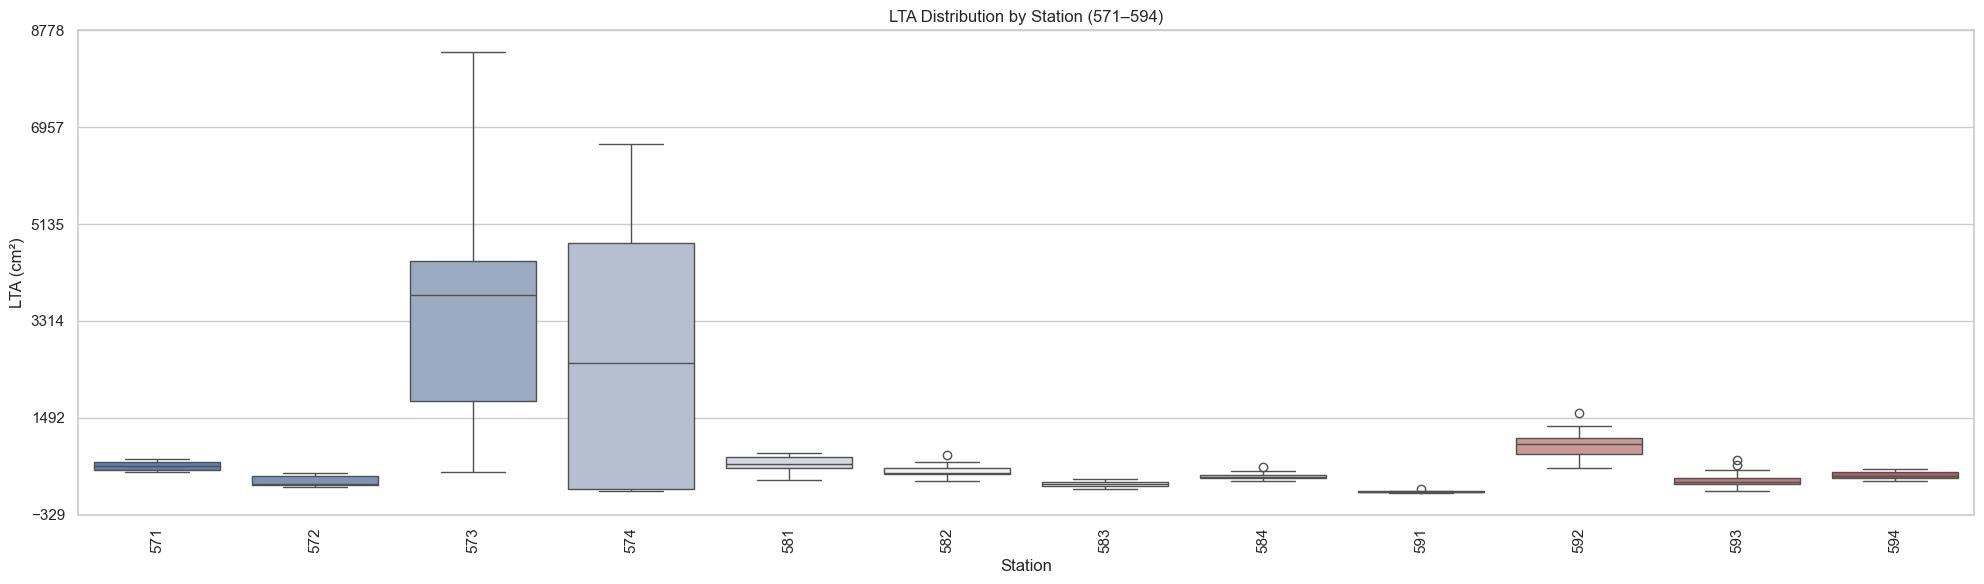

C:\Users\devgu\AppData\Local\Temp\ipykernel_13988\3981518225.py:29: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(x='stationid', y='lta', data=df_chunk, palette='vlag')


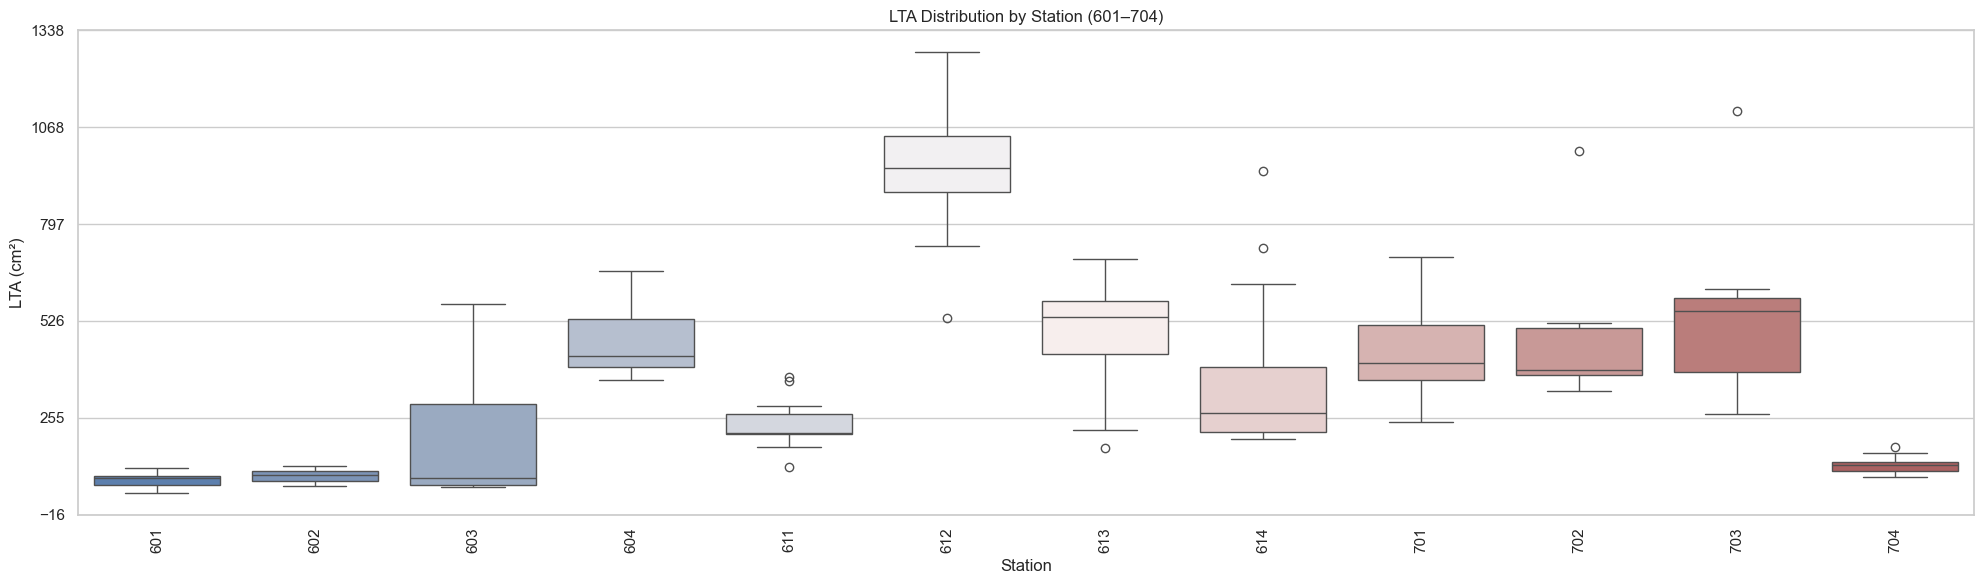

C:\Users\devgu\AppData\Local\Temp\ipykernel_13988\3981518225.py:29: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(x='stationid', y='lta', data=df_chunk, palette='vlag')


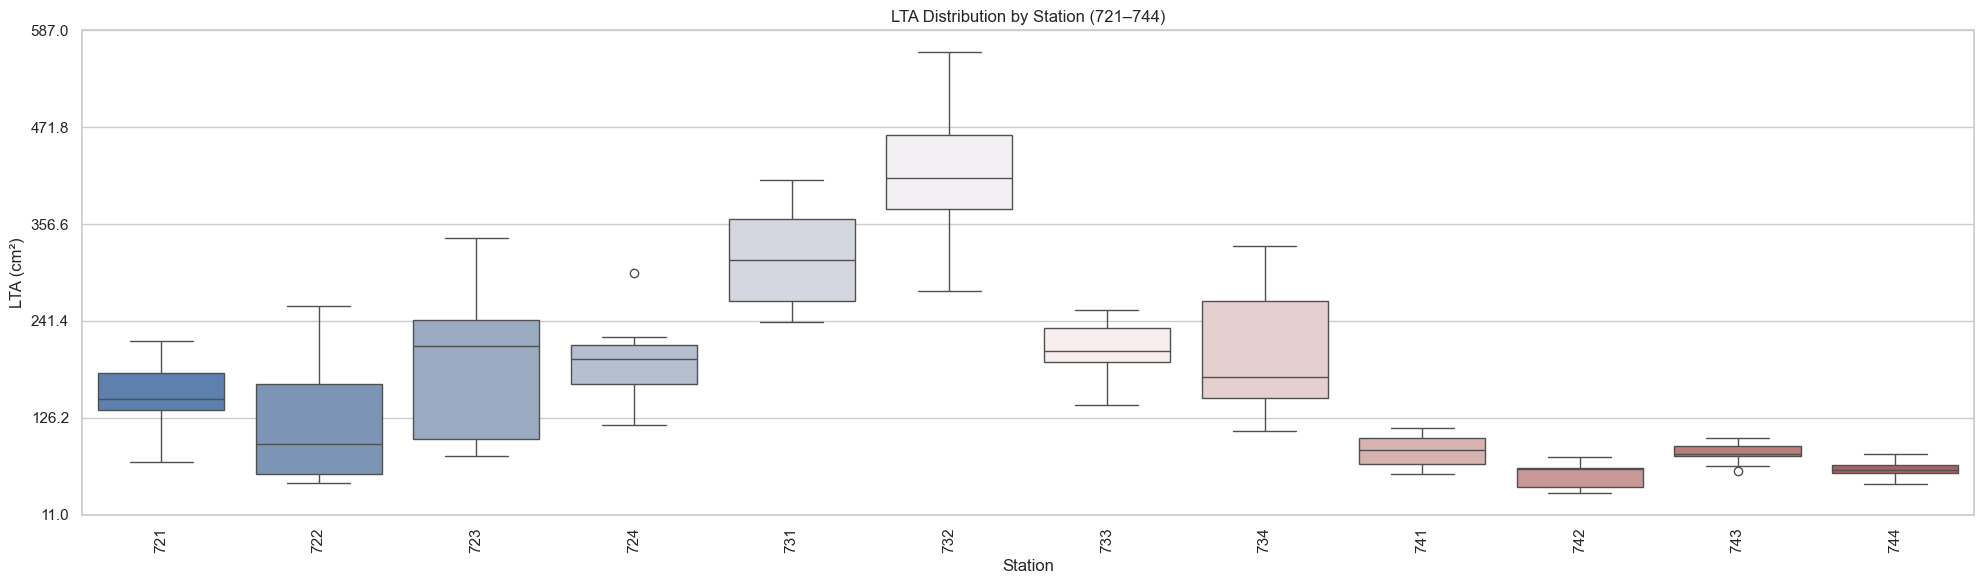

C:\Users\devgu\AppData\Local\Temp\ipykernel_13988\3981518225.py:29: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(x='stationid', y='lta', data=df_chunk, palette='vlag')


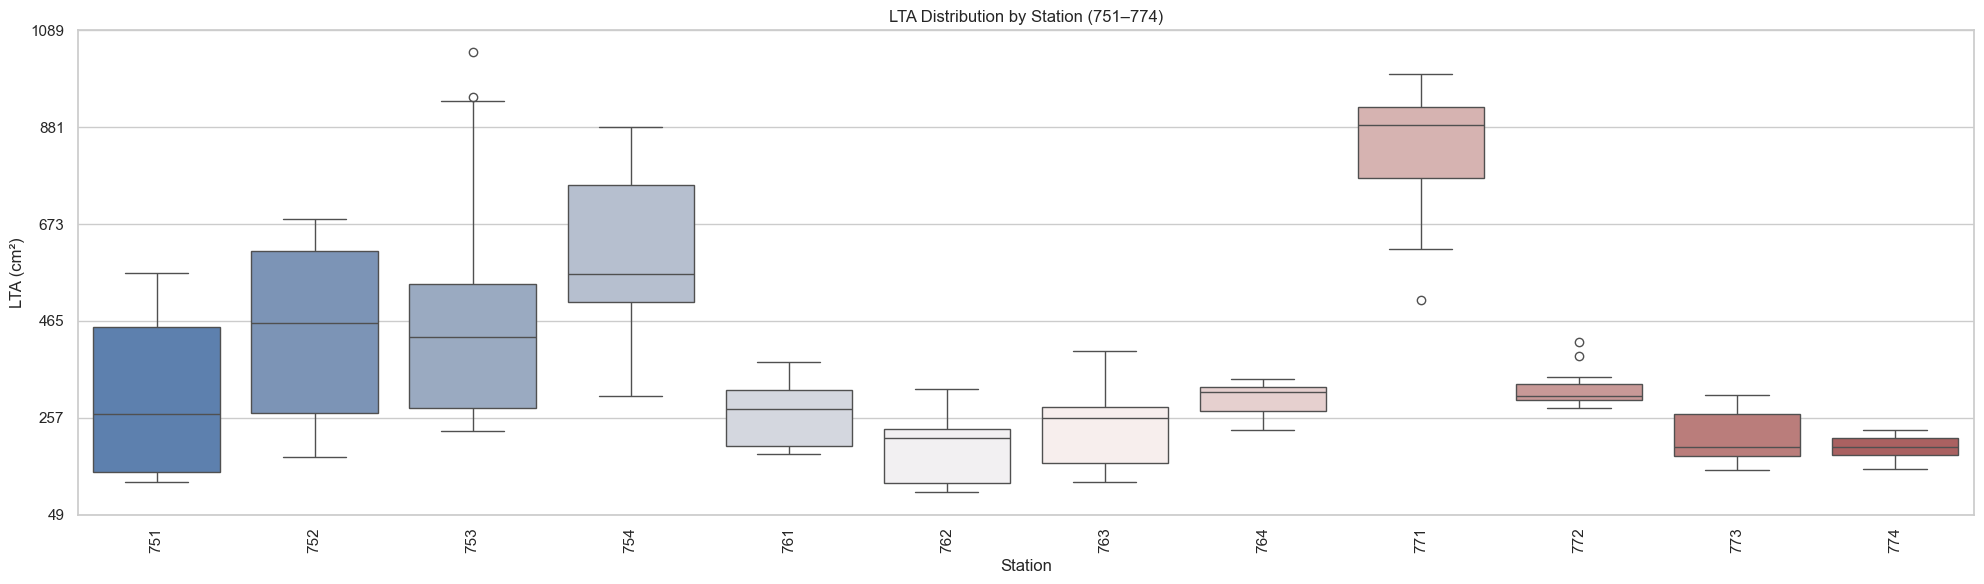

C:\Users\devgu\AppData\Local\Temp\ipykernel_13988\3981518225.py:29: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(x='stationid', y='lta', data=df_chunk, palette='vlag')


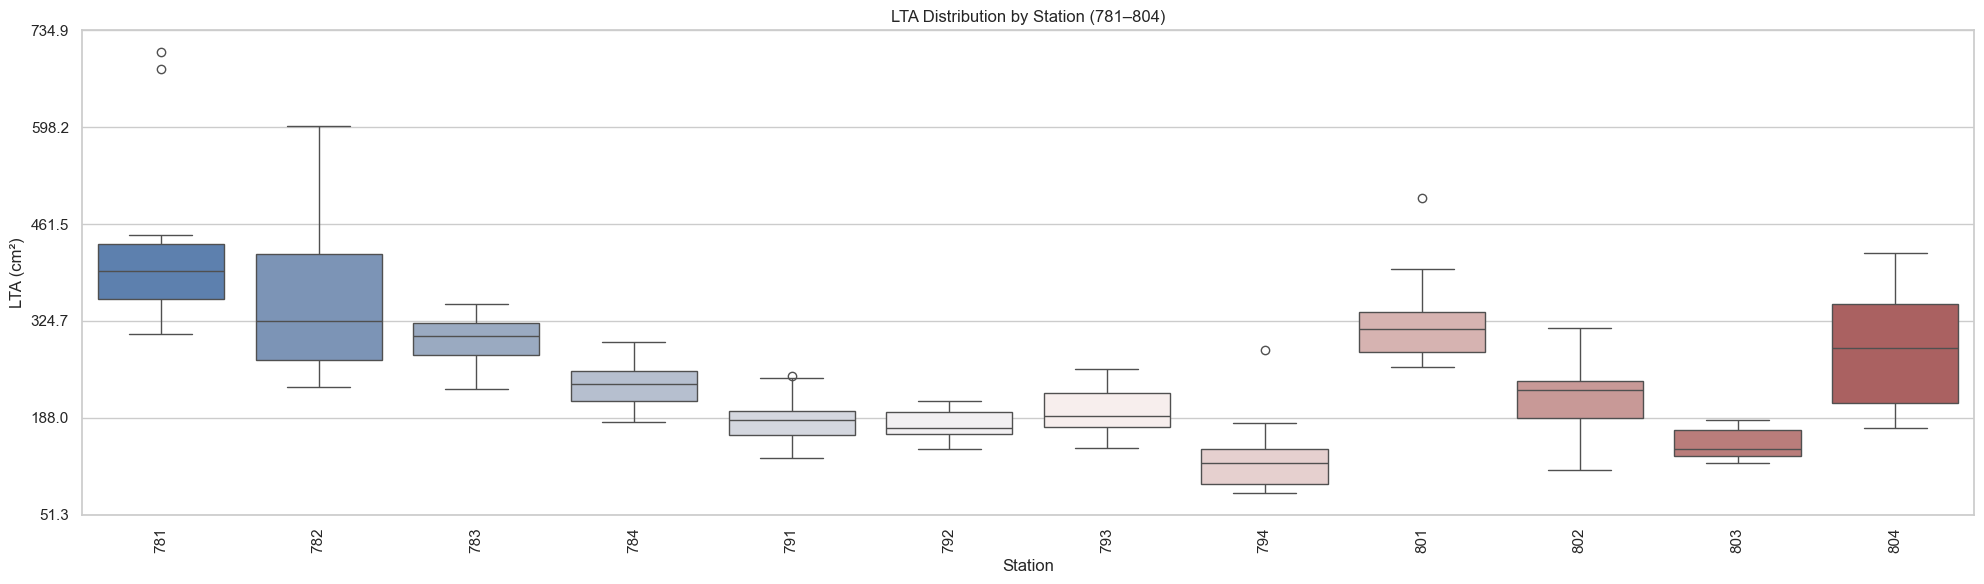

C:\Users\devgu\AppData\Local\Temp\ipykernel_13988\3981518225.py:29: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(x='stationid', y='lta', data=df_chunk, palette='vlag')


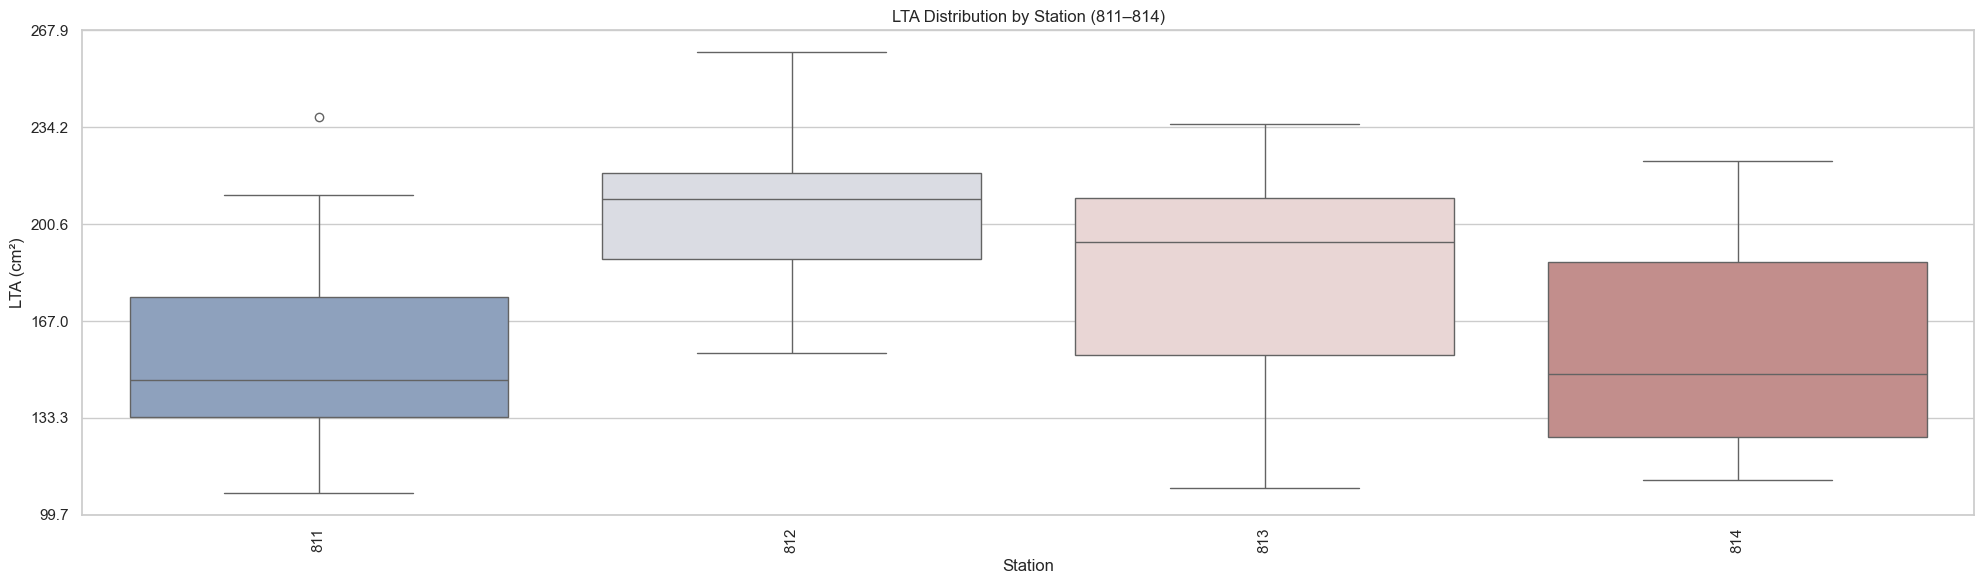

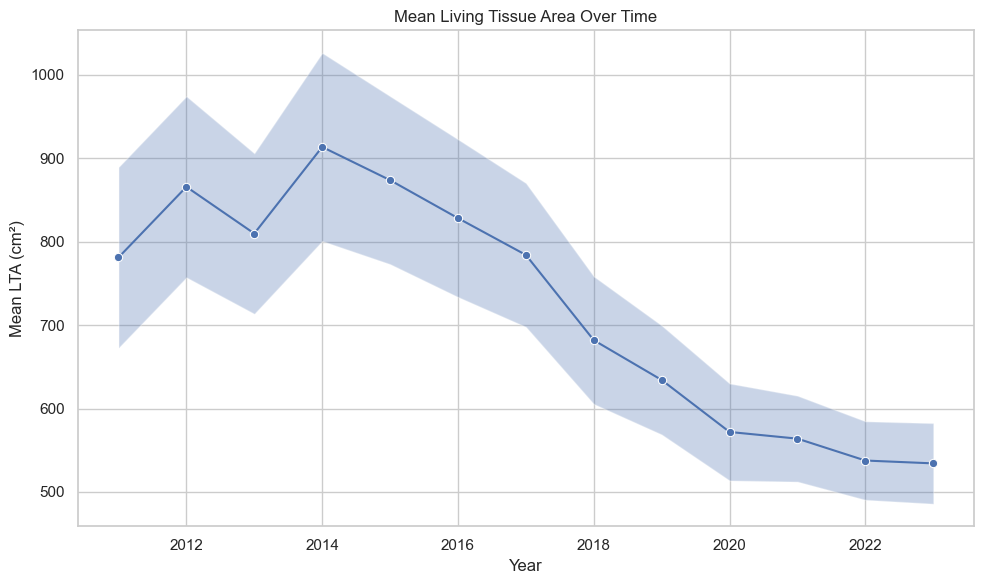

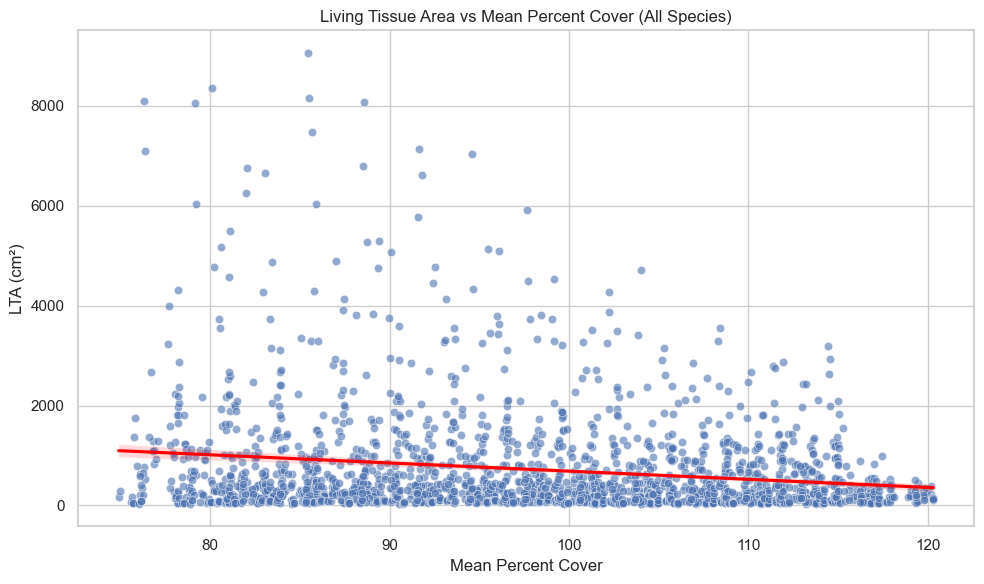

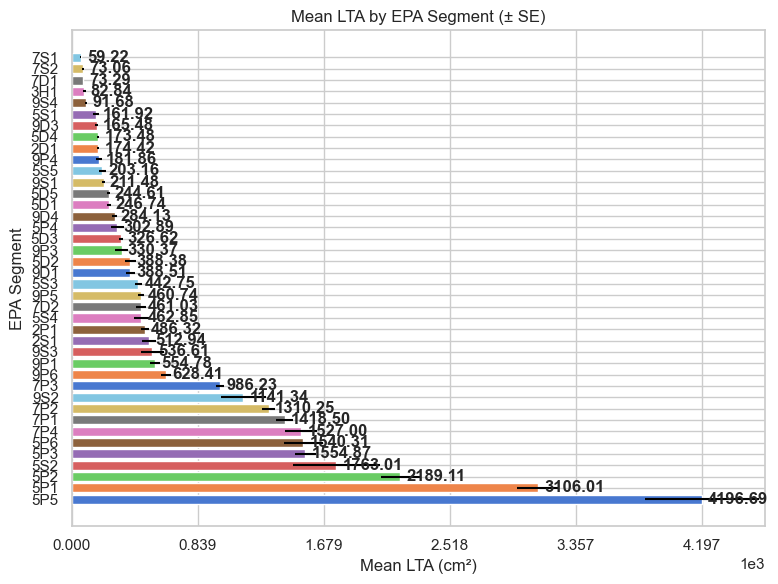

In [ ]:
def run_section6():
    """
    Creates visualizations for living tissue area differences.
    Loads data from processed_data/with_stations to include outliers.
    """
    # load processed tables
    df_sc_lta = load_processed("scor_lta_summary", version="with_stations")
    df_pcover = load_processed("pcover_stony_species", version="with_stations")
    df_stations = load_processed("stations", version="with_stations")
    # prepare LTA df: compute mean across all species columns (exclude metadata including site_code)
    metadata_cols = [
        'oid_','year','date','subregion','subregion_x',
        'habitat','habitat_x','siteid','siteid_x','site_name',
        'site_name_x','stationid','surveyed_all_years','points','site_code'
    ]
    species_cols = [c for c in df_sc_lta.columns if c not in metadata_cols]
    df = df_sc_lta[['year','stationid'] + species_cols].copy()
    df[species_cols] = df[species_cols].apply(pd.to_numeric, errors='coerce')
    df['lta'] = df[species_cols].mean(axis=1)
    # merge station segments
    df = df.merge(df_stations[['stationid','site_code']], on='stationid', how='left')

    # 1. Boxplot of LTA by station (12 stations per chart)
    stations = sorted(df['stationid'].unique())
    for i in range(0, len(stations), 12):
        chunk = stations[i:i+12]
        df_chunk = df[df['stationid'].isin(chunk)]
        plt.figure(figsize=(20, 6))
        sns.boxplot(x='stationid', y='lta', data=df_chunk, palette='vlag')
        ax = plt.gca()
        ylim = ax.get_ylim()
        ticks = np.linspace(ylim[0], ylim[1], 6)
        ax.set_yticks(ticks)
        ax.ticklabel_format(style='plain', axis='y')
        plt.title(f'LTA Distribution by Station ({chunk[0]}–{chunk[-1]})')
        plt.xlabel('Station')
        plt.ylabel('LTA (cm²)')
        plt.xticks(rotation=90)
        plt.tight_layout()
        plt.show()

    # 2. Mean LTA over time
    annual = df.groupby('year')['lta'].agg(['mean','std','count']).reset_index()
    annual['se'] = annual['std']/annual['count']**0.5
    plt.figure()
    sns.lineplot(x='year', y='mean', data=annual, marker='o')
    plt.fill_between(annual['year'], annual['mean']-annual['se'], annual['mean']+annual['se'], alpha=0.3)
    plt.title('Mean Living Tissue Area Over Time')
    plt.xlabel('Year')
    plt.ylabel('Mean LTA (cm²)')
    plt.tight_layout()
    plt.show()

    # 3. Scatter of LTA vs mean coral cover (all species)
    # identify species cover columns
    species_cols = [c for c in df_pcover.columns if c not in (
        ['oid_','year','date','subregion','habitat','siteid','site_name','stationid','surveyed_all_years','points']
    )]
    df_pc_all = df_pcover.copy()
    df_pc_all[species_cols] = df_pc_all[species_cols].apply(pd.to_numeric, errors='coerce')
    df_pc_all['mean_cover_all'] = df_pc_all[species_cols].mean(axis=1)
    df_join = df.merge(
        df_pc_all[['year','stationid','mean_cover_all']], on=['year','stationid'], how='inner'
    )
    plt.figure()
    sns.scatterplot(x='mean_cover_all', y='lta', data=df_join, alpha=0.6)
    sns.regplot(x='mean_cover_all', y='lta', data=df_join, scatter=False, color='red')
    plt.title('Living Tissue Area vs Mean Percent Cover (All Species)')
    plt.xlabel('Mean Percent Cover')
    plt.ylabel('LTA (cm²)')
    plt.tight_layout()
    plt.show()

    # 4. Barplot of mean LTA by EPA segment with error bars & annotations
    seg_stat = df.groupby('site_code')['lta'].agg(['mean','std','count']).reset_index()
    seg_stat['se'] = seg_stat['std'] / np.sqrt(seg_stat['count'])
    seg_stat = seg_stat.sort_values('mean', ascending=False)
    # horizontal barplot of mean LTA with SE error bars
    plt.figure(figsize=(8, 6))
    y_pos = np.arange(len(seg_stat))
    plt.barh(
        y_pos, seg_stat['mean'], xerr=seg_stat['se'],
        color=sns.color_palette('muted', len(seg_stat)), ecolor='black'
    )
    plt.yticks(y_pos, seg_stat['site_code'])
    # dynamic x-axis limits and ticks
    max_mean = seg_stat['mean'].max()
    plt.xlim(0, max_mean * 1.1)
    ticks = np.linspace(0, max_mean, 6)
    plt.xticks(ticks)
    plt.ticklabel_format(style='sci', axis='x', scilimits=(0,0))
    # annotate bars
    for i, v in enumerate(seg_stat['mean']):
        plt.text(v + max_mean*0.01, i, f"{v:.2f}", va='center', fontweight='bold')
    plt.title('Mean LTA by EPA Segment (± SE)')
    plt.xlabel('Mean LTA (cm²)')
    plt.ylabel('EPA Segment')
    plt.tight_layout()
    plt.show()

run_section6()


## Relationships & Correlations

### Section 7 – Spatial Distribution Patterns

c:\Users\devgu\Downloads\Florida Keys Coral Reef Evaluation Dataset\My_work\venv\Lib\site-packages\libpysal\weights\distance.py:153: UserWarning: The weights matrix is not fully connected: 
 There are 7 disconnected components.
  W.__init__(self, neighbors, id_order=ids, **kwargs)


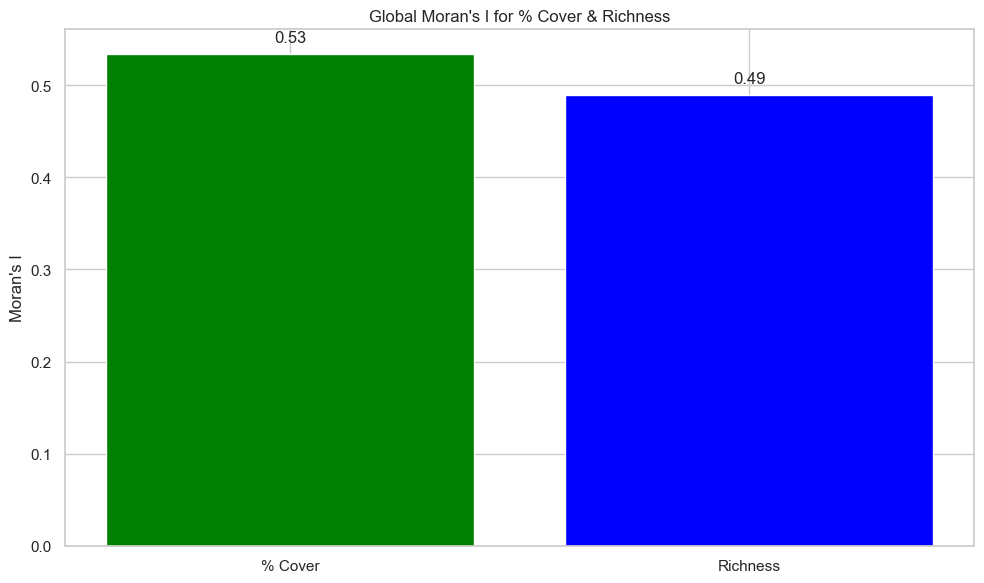

In [24]:
def run_section7():
    """
    Create spatial distribution patterns and autocorrelation.
    Loads data from processed_data/with_stations.
    Args:
        None (loads internally).
    """
    # load processed tables
    df_pcover = load_processed("pcover_stony_species", version="with_stations")
    df_stations = load_processed("stations", version="with_stations")
    # station-level mean % cover (all stony species, not just scleractinia)
    stony_cols = [c for c in df_pcover.columns if c not in (
        ['oid_','year','date','subregion','habitat','siteid','site_name','stationid','surveyed_all_years','points','scleractinia']
    )]
    df_pcover[stony_cols] = df_pcover[stony_cols].apply(pd.to_numeric, errors='coerce')
    df_pcover['all_stony_cover'] = df_pcover[stony_cols].mean(axis=1)
    df_cov = df_pcover.groupby('stationid')['all_stony_cover'].mean().reset_index()
    df_cov = df_cov.merge(df_stations[['stationid','latdd','londd']], on='stationid')
    # richness
    species_cols = [c for c in df_pcover.columns if c not in (
        ['oid_','year','date','subregion','habitat','siteid','site_name','stationid','surveyed_all_years','points']
    )]
    df_rich = df_pcover.copy()
    # convert species columns to numeric to avoid comparison errors
    df_rich[species_cols] = df_rich[species_cols].apply(pd.to_numeric, errors='coerce')
    df_rich['richness'] = (df_rich[species_cols] > 0).sum(axis=1)
    df_rich = df_rich.groupby('stationid')['richness'].mean().reset_index()
    df_rich = df_rich.merge(df_stations[['stationid','latdd','londd']], on='stationid')

    # 1. Map % cover
    m_cov = folium.Map(location=[df_cov['latdd'].mean(), df_cov['londd'].mean()], zoom_start=8)
    for _, r in df_cov.iterrows():
        folium.CircleMarker(
            location=[r['latdd'], r['londd']],
            radius=5, fill=True,
            color='green', fill_opacity=0.7,
            popup=f"Station {r['stationid']}: {r['all_stony_cover']:.1f}%"
        ).add_to(m_cov)
    m_cov.save('map_percent_cover.html')
    display(m_cov)

    # 2. Map richness
    m_rich = folium.Map(location=[df_rich['latdd'].mean(), df_rich['londd'].mean()], zoom_start=8)
    for _, r in df_rich.iterrows():
        folium.CircleMarker(
            location=[r['latdd'], r['londd']],
            radius=5, fill=True,
            color='blue', fill_opacity=0.7,
            popup=f"Station {r['stationid']}: richness {r['richness']:.1f}"
        ).add_to(m_rich)
    m_rich.save('map_richness.html')
    display(m_rich)

    # spatial weights (KNN)
    coords = df_cov[['latdd','londd']].values
    w = libpysal.weights.KNN.from_array(coords, k=8)
    # global Moran's I
    mi_cov = esda.Moran(df_cov['all_stony_cover'].values, w)
    mi_rich = esda.Moran(df_rich['richness'].values, w)
    # 3. Moran's I bar chart
    plt.figure()
    bars = plt.bar(['% Cover','Richness'], [mi_cov.I, mi_rich.I], color=['green','blue'])
    # annotate bar heights
    for bar in bars:
        yval = bar.get_height()
        plt.text(bar.get_x() + bar.get_width()/2, yval + 0.01, f"{yval:.2f}", ha='center', va='bottom')
    plt.title("Global Moran's I for % Cover & Richness")
    plt.ylabel("Moran's I")
    plt.tight_layout()
    plt.show()

    # 4. Local Gi* hot-spot for % cover
    gi = esda.G_Local(df_cov['all_stony_cover'].values, w)
    df_cov['Gi_z'] = gi.Zs
    m_gi = folium.Map(location=[df_cov['latdd'].mean(), df_cov['londd'].mean()], zoom_start=8)
    for _, r in df_cov.iterrows():
        if r['Gi_z'] > 1.96:
            color='red'
        elif r['Gi_z'] < -1.96:
            color='blue'
        else:
            color='gray'
        folium.CircleMarker(
            location=[r['latdd'], r['londd']], radius=7,
            color=color, fill=True, fill_opacity=0.6,
            popup=f"Station {r['stationid']}: z={r['Gi_z']:.2f}"
        ).add_to(m_gi)
    m_gi.save('map_gi_hotspots.html')
    display(m_gi)

run_section7()


### Section 8 – Regional Comparison

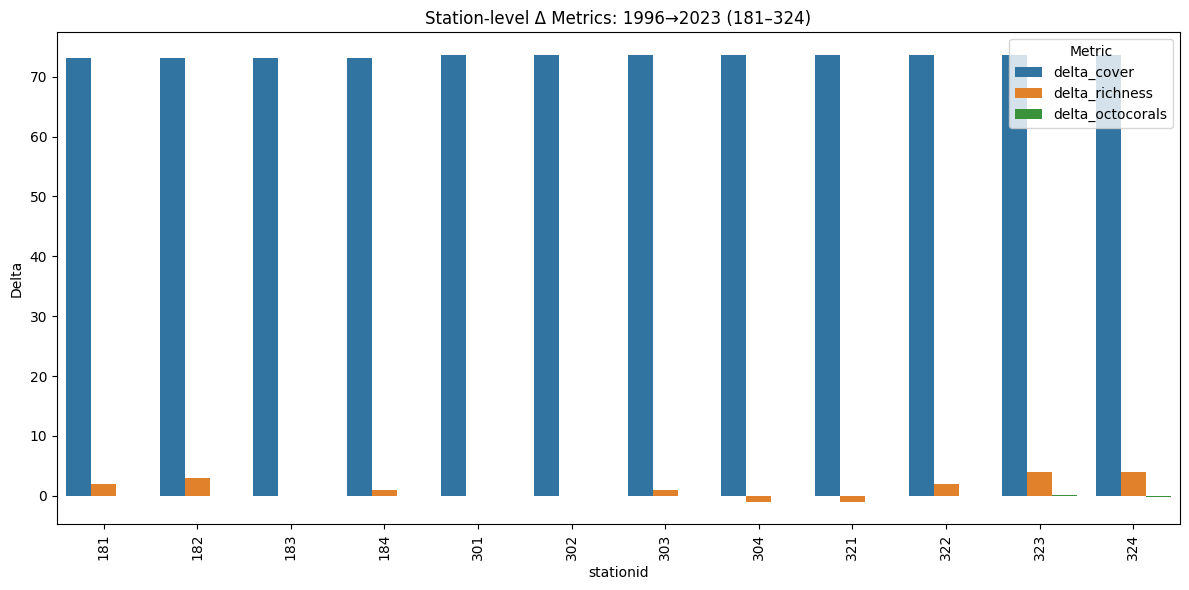

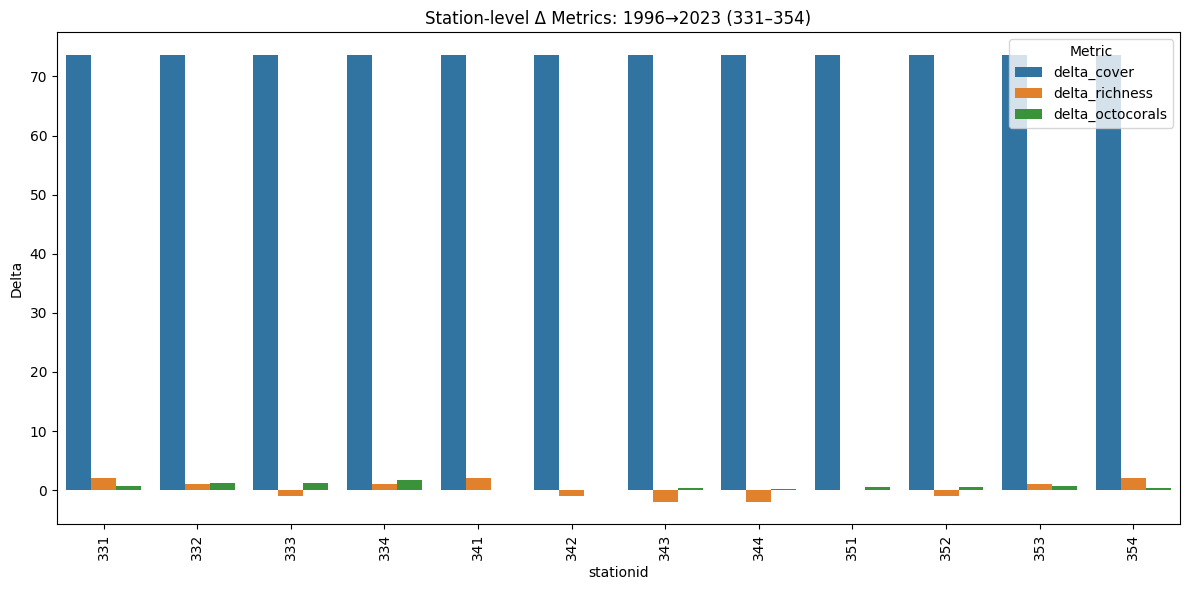

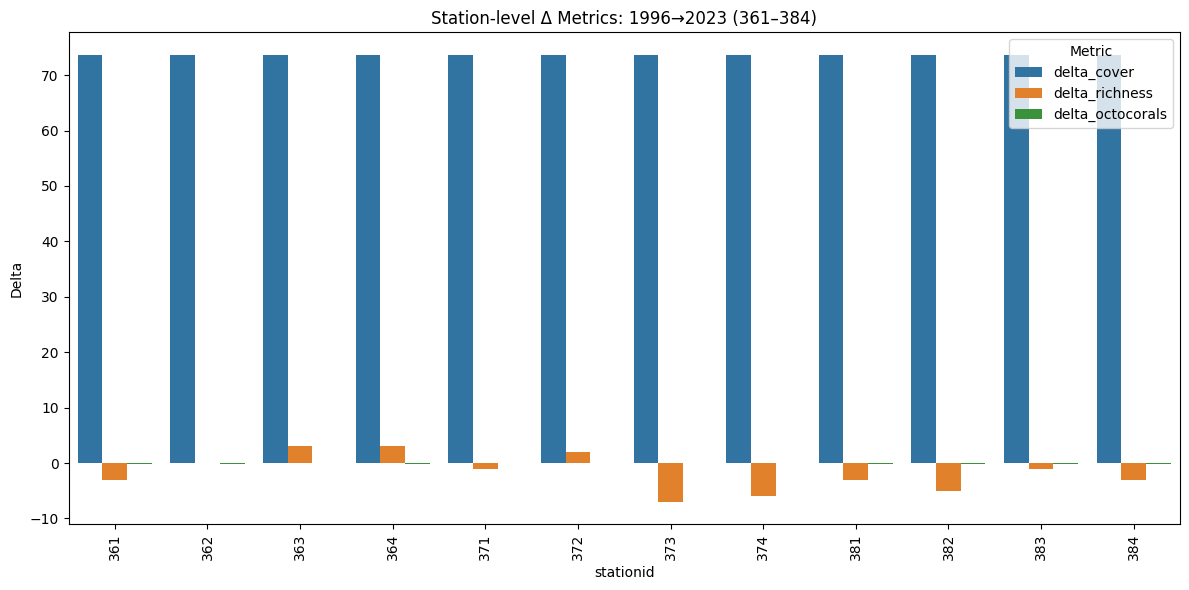

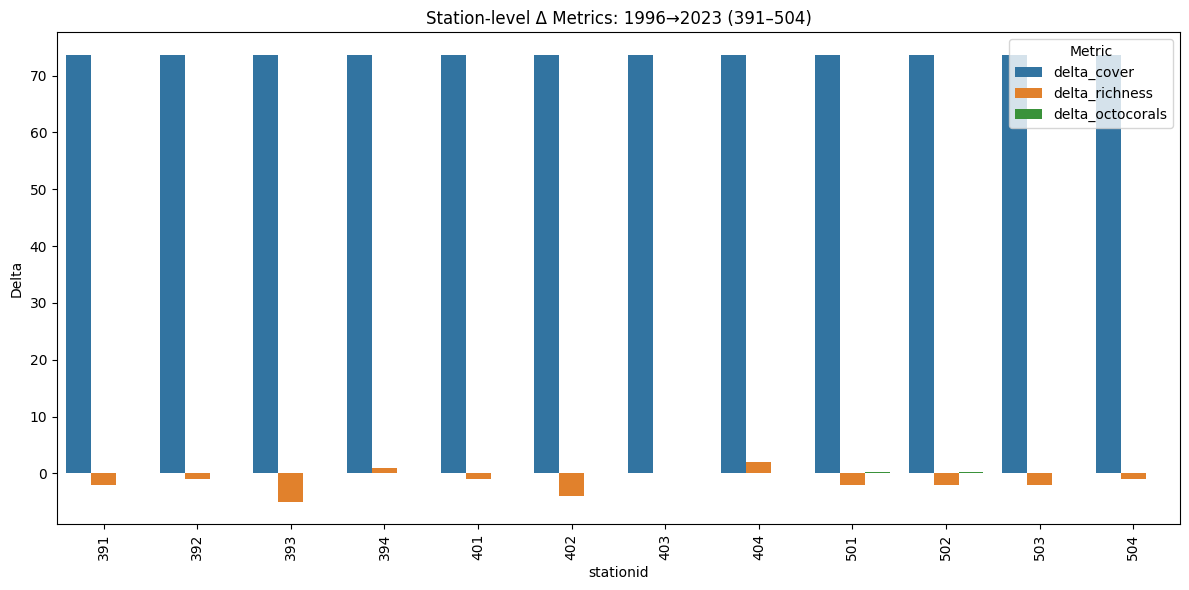

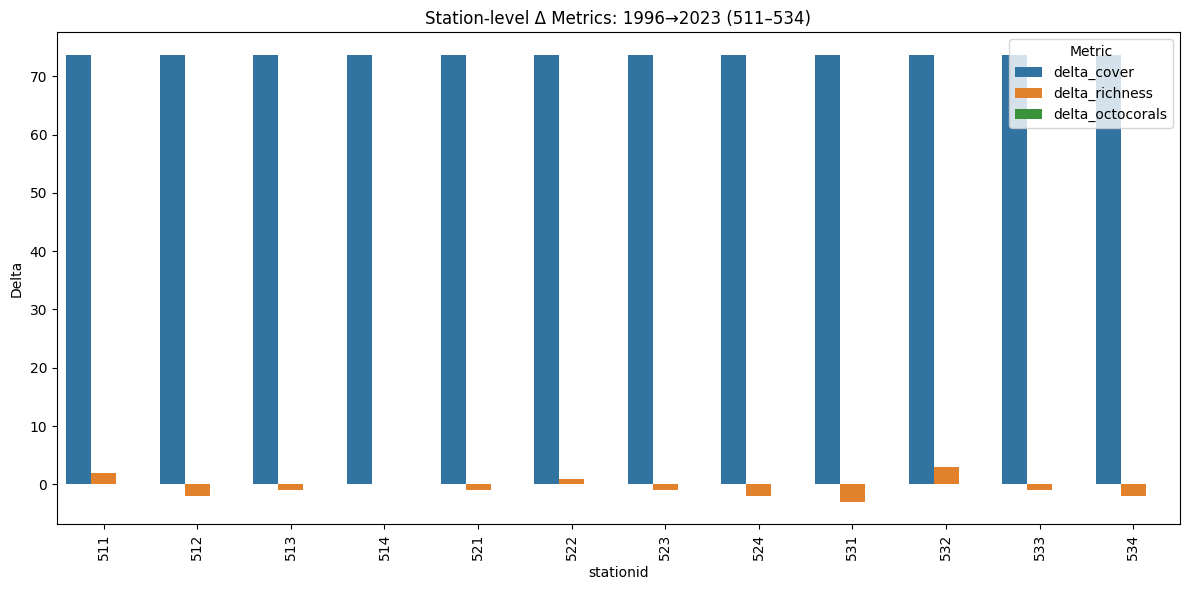

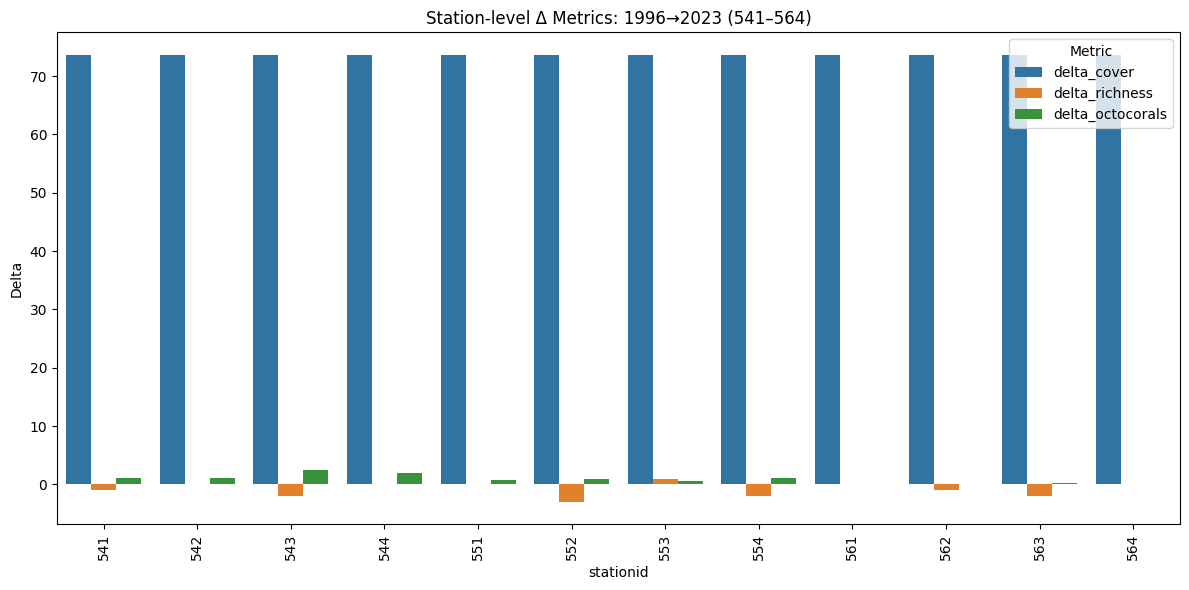

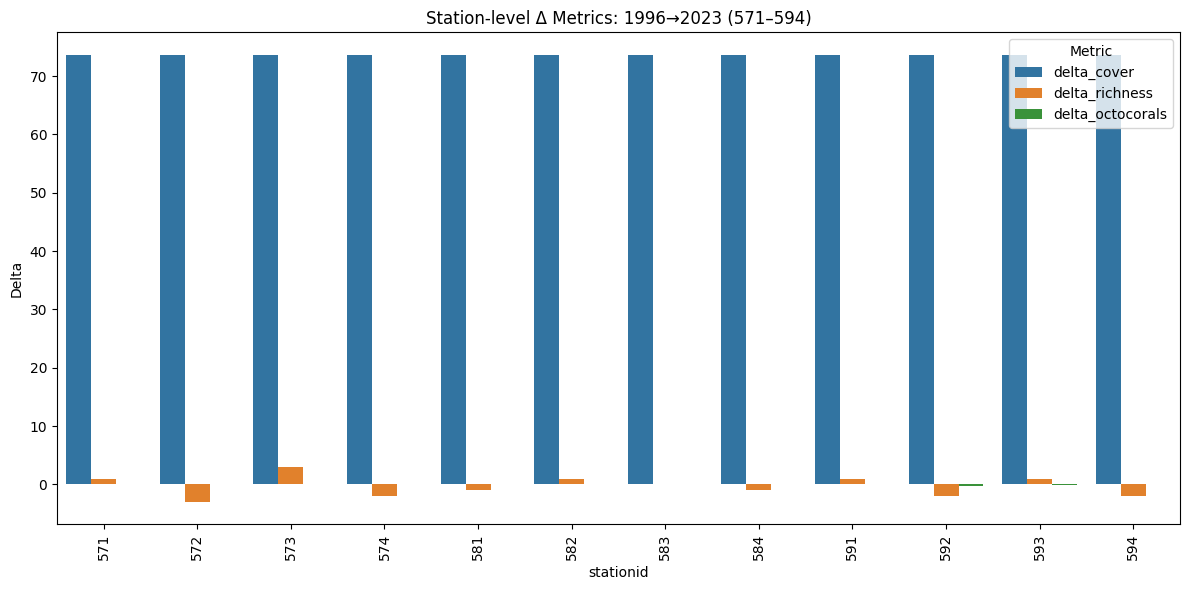

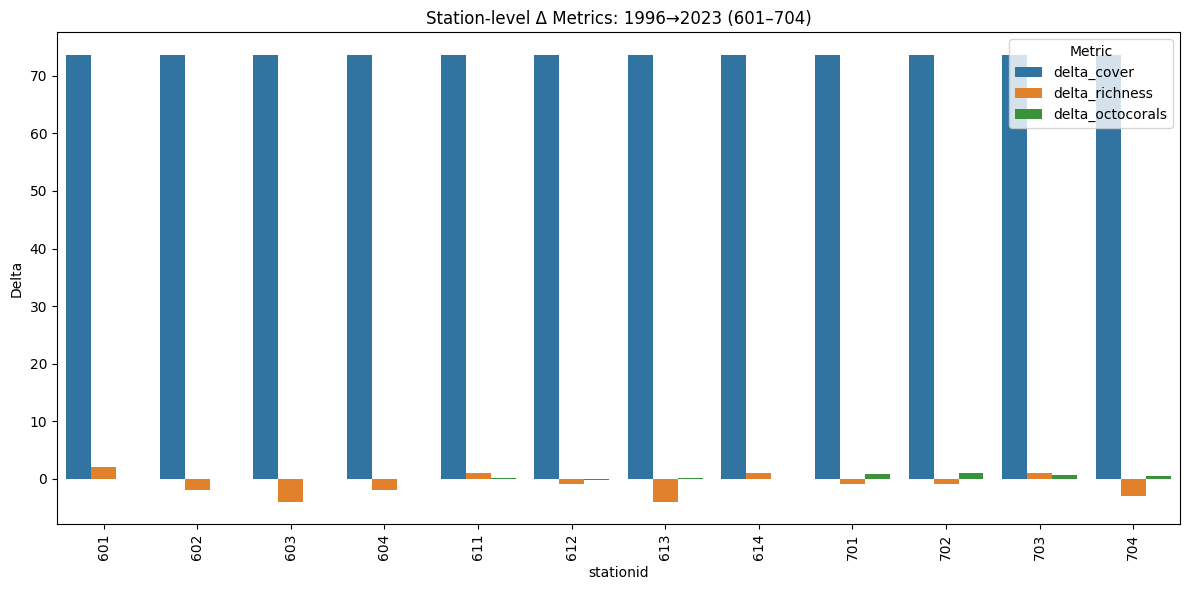

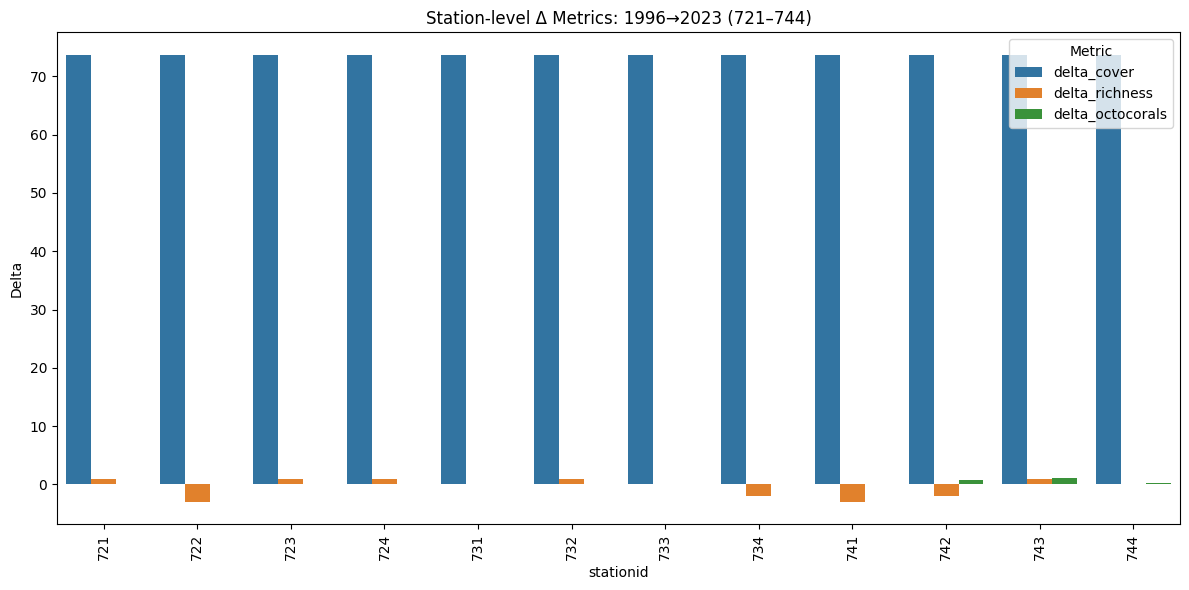

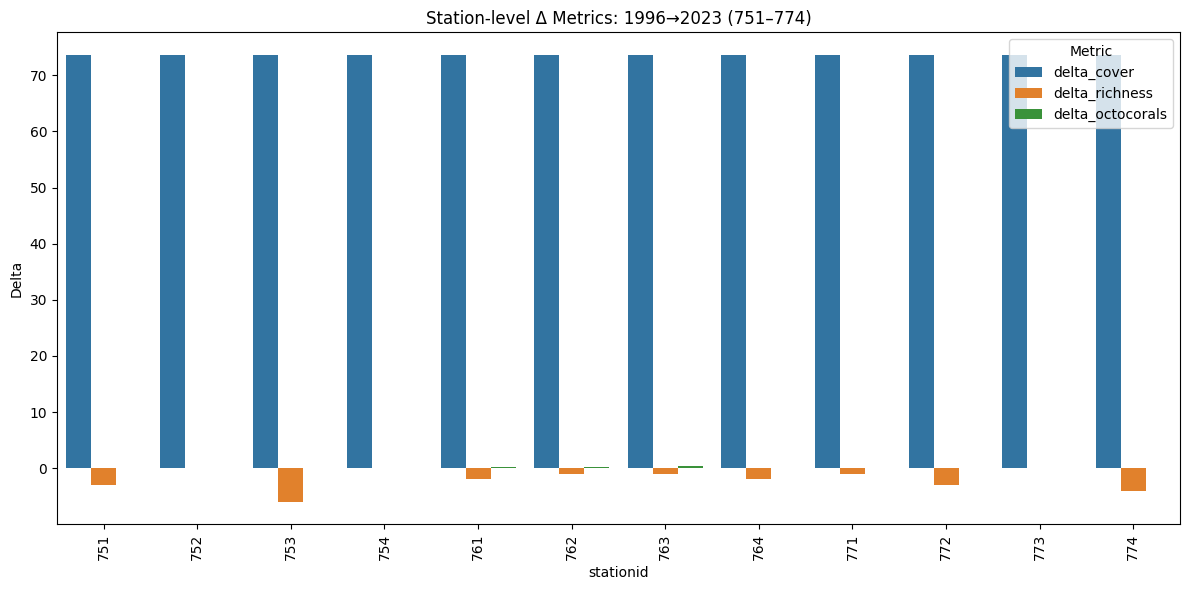

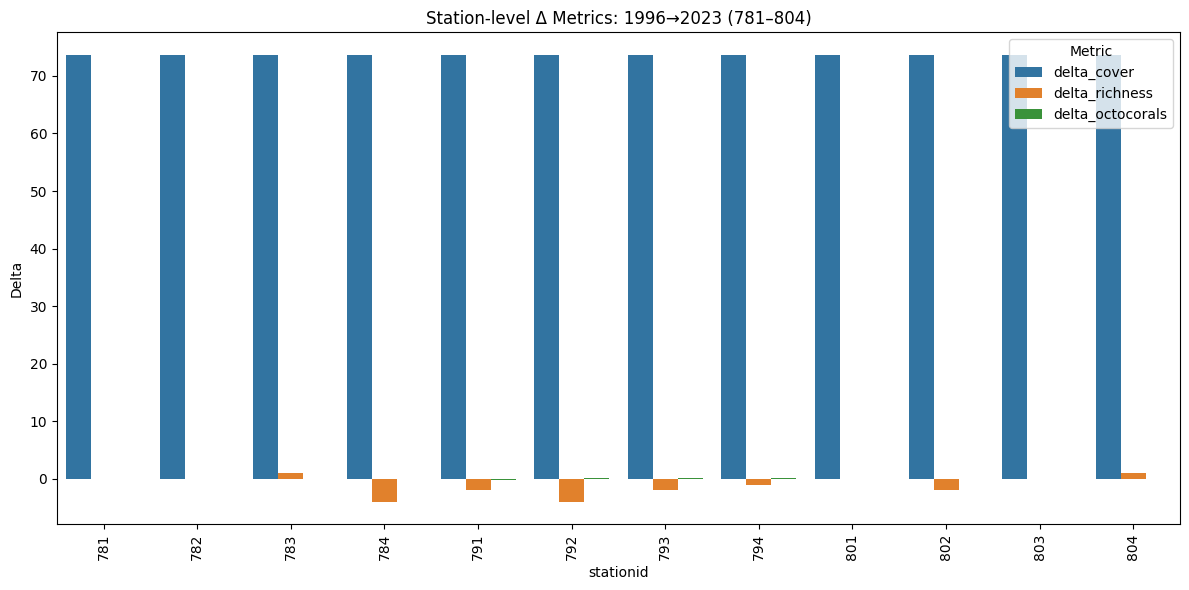

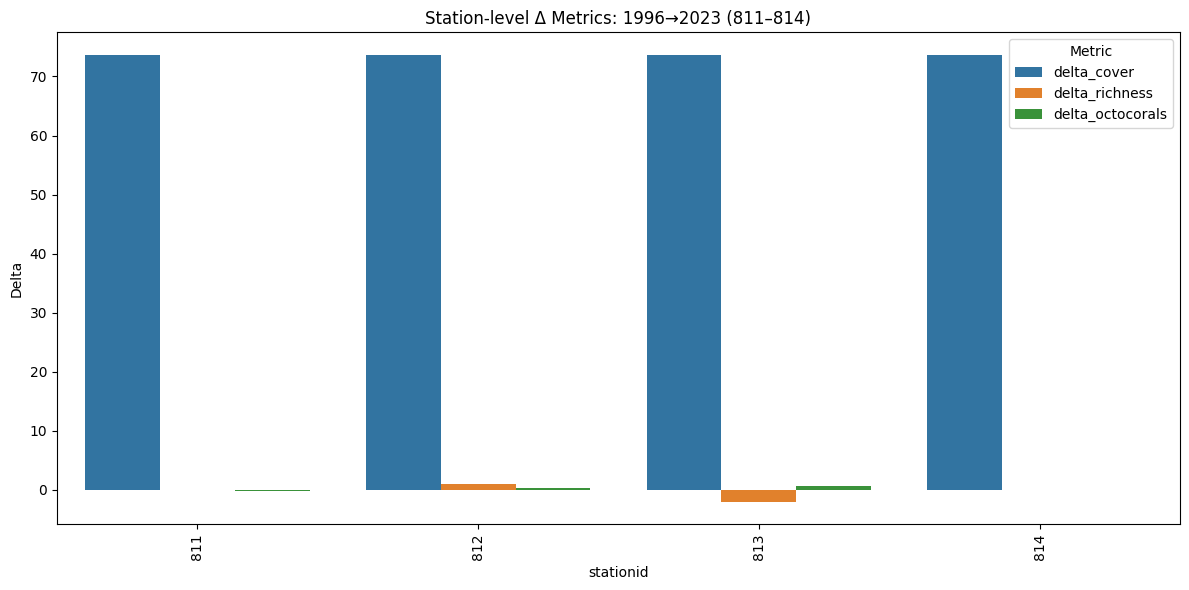

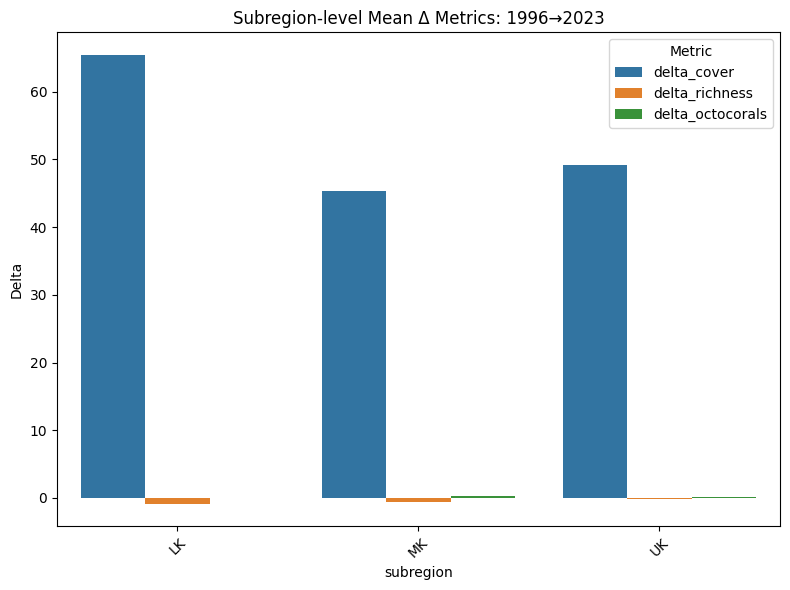

In [ ]:
"""
Module: Section 8 – Regional Comparison
Adds subregion‐level tests + cluster‐heatmap to station‐level charts.
"""
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from pandas.plotting import parallel_coordinates
import scipy.stats as st

from My_work.Preprocessing import load_processed

def run_section8(df_pcover=None, df_sc_den=None, df_octo=None, df_stn=None):
    # -- load or use provided data --
    if df_pcover is None:
        df_pcover = load_processed("pcover_stony_species", version="with_stations")
    if df_sc_den is None:
        df_sc_den = load_processed("scor_density_summary", version="with_stations")
    if df_octo is None:
        df_octo = load_processed("octo_density_summary", version="with_stations")
    if df_stn is None:
        df_stn = load_processed("stations", version="with_stations")

    # baseline years for cover/richness
    years = sorted(df_pcover['year'].unique())
    y0, y1 = years[0], years[-1]
    # baseline years for octocoral data
    octo_years = sorted(df_octo['year'].unique())
    o_y0, o_y1 = octo_years[0], octo_years[-1]

    # compute delta metrics using mean cover across all coral species columns (exclude all metadata, including site_code)
    metadata_cols = [
        'oid_','year','date','subregion','subregion_x','habitat','habitat_x',
        'siteid','siteid_x','site_name','site_name_x','stationid','surveyed_all_years','points','site_code','scleractinia'
    ]
    cover_cols = [c for c in df_pcover.columns if c not in metadata_cols]
    df_pcover[cover_cols] = df_pcover[cover_cols].apply(pd.to_numeric, errors='coerce')
    df_pcover['mean_cover_all'] = df_pcover[cover_cols].mean(axis=1)
    pc0 = df_pcover[df_pcover.year==y0].groupby('stationid')['mean_cover_all'].mean()
    pc1 = df_pcover[df_pcover.year==y1].groupby('stationid')['mean_cover_all'].mean()
    # richness delta (exclude all metadata columns)
    richness_cols = [c for c in df_pcover.columns if c not in metadata_cols]
    df_rich = df_pcover.copy()
    df_rich[richness_cols] = df_rich[richness_cols].apply(pd.to_numeric, errors='coerce')
    df_rich['richness'] = (df_rich[richness_cols] > 0).sum(axis=1)
    rich0 = df_rich[df_rich.year==y0].groupby('stationid')['richness'].mean()
    rich1 = df_rich[df_rich.year==y1].groupby('stationid')['richness'].mean()
    # octocoral delta using mean across all octocoral species columns (exclude all metadata)
    octo_metadata_cols = [
        'oid_','year','date','subregion','subregion_x','habitat','habitat_x',
        'siteid','siteid_x','site_name','site_name_x','stationid','surveyed_all_years','points','site_code','survey_details','total_octocorals'
    ]
    octo_cols = [c for c in df_octo.columns if c not in octo_metadata_cols]
    df_octo[octo_cols] = df_octo[octo_cols].apply(pd.to_numeric, errors='coerce')
    df_octo['mean_octo_all'] = df_octo[octo_cols].mean(axis=1)
    # compute delta for octocorals based on its own baseline years
    o0 = df_octo[df_octo.year==o_y0].groupby('stationid')['mean_octo_all'].mean()
    o1 = df_octo[df_octo.year==o_y1].groupby('stationid')['mean_octo_all'].mean()

    df_delta = pd.DataFrame({
        'delta_cover': pc1 - pc0,
        'delta_richness': rich1 - rich0,
        'delta_octocorals': o1 - o0
    }).reset_index()
    # fill missing delta values with 0 to retain all stations
    df_delta[['delta_cover','delta_richness','delta_octocorals']] = df_delta[['delta_cover','delta_richness','delta_octocorals']].fillna(0)
    df_delta = df_delta.merge(df_stn[['stationid','subregion']], on='stationid', how='left')

    # Combined station-level Δ Metrics
    # Exclude stations with no change across all metrics
    df_delta_stn = df_delta[df_delta[['delta_cover','delta_richness','delta_octocorals']].abs().sum(axis=1) > 0]
    df_long = df_delta_stn.melt(
        id_vars='stationid',
        value_vars=['delta_cover','delta_richness','delta_octocorals'],
        var_name='Metric', value_name='Delta'
    )
    stations = sorted(df_delta_stn['stationid'].unique())
    # plot 12 stations per chart
    for i in range(0, len(stations), 12):
        chunk = stations[i:i+12]
        df_chunk = df_long[df_long['stationid'].isin(chunk)]
        plt.figure(figsize=(12, 6))
        sns.barplot(x='stationid', y='Delta', hue='Metric', data=df_chunk)
        plt.title(f'Station-level Δ Metrics: {y0}→{y1} ({chunk[0]}–{chunk[-1]})')
        plt.xticks(rotation=90)
        plt.tight_layout()
        plt.show()

    # Combined subregion-level Mean Δ Metrics
    df_reg = df_delta.groupby('subregion')[['delta_cover','delta_richness','delta_octocorals']].mean().reset_index()
    df_reg_long = df_reg.melt(id_vars='subregion', var_name='Metric', value_name='Delta')
    plt.figure(figsize=(8, 6))
    sns.barplot(x='subregion', y='Delta', hue='Metric', data=df_reg_long)
    plt.title(f'Subregion-level Mean Δ Metrics: {y0}→{y1}')
    plt.xticks(rotation=45)
    plt.tight_layout()
    plt.show()

run_section8()


In [ ]:

import plotly.express as px
import plotly.graph_objects as go
from plotly.subplots import make_subplots

def generate_new_section8_graphs():
    """
    Generate 4 new visualizations for regional comparison analysis.
    """
    # Load required datasets
    df_pcover = pd.read_csv("My_work/processed_data/pcover_stony_species_with_stations.csv")
    df_octo = pd.read_csv("My_work/processed_data/octo_density_summary_with_stations.csv")
    df_scor = pd.read_csv("My_work/processed_data/scor_density_summary_with_stations.csv")
    df_stations = pd.read_csv("My_work/processed_data/stations_with_stations.csv")

    # 1. Species Diversity Heatmap by Region
    def plot_species_diversity_heatmap():
        # Get species columns (excluding metadata columns)
        species_cols = [col for col in df_pcover.columns if col not in 
                       ['oid__x', 'year', 'date', 'subregion', 'habitat', 'siteid', 
                        'site_name', 'stationid', 'surveyed_all_years', 'points', 
                        'scleractinia', 'region', 'site_code']]
        
        # Convert species columns to numeric
        for col in species_cols:
            df_pcover[col] = pd.to_numeric(df_pcover[col], errors='coerce')
        
        # Calculate presence/absence matrix
        presence_matrix = df_pcover.groupby('region')[species_cols].mean()
        
        # Create heatmap
        plt.figure(figsize=(15, 8))
        sns.heatmap(presence_matrix, cmap='YlOrRd', 
                   xticklabels=True, yticklabels=True)
        plt.title('Species Diversity Heatmap by Region')
        plt.xlabel('Species')
        plt.xticks(rotation=45, ha='right')
        plt.tight_layout()
        plt.close()

    # 2. Depth-Related Regional Patterns
    def plot_depth_patterns():
        # Use existing depth_ft in df_pcover (no merge needed)
        depth_data = df_pcover.copy()
        
        # Create scatter plot
        plt.figure(figsize=(10, 6))
        sns.scatterplot(data=depth_data, x='depth_ft', y='scleractinia', 
                       hue='region', alpha=0.6)
        
        # Add trend lines for each region
        for region in depth_data['region'].unique():
            region_data = depth_data[depth_data['region'] == region]
            z = np.polyfit(region_data['depth_ft'], region_data['scleractinia'], 1)
            p = np.poly1d(z)
            plt.plot(region_data['depth_ft'], p(region_data['depth_ft']), 
                    linestyle='--', alpha=0.8)
        
        plt.title('Coral Coverage vs Depth by Region')
        plt.xlabel('Depth (ft)')
        plt.ylabel('Coral Coverage (%)')
        plt.legend(title='Region', bbox_to_anchor=(1.05, 1), loc='upper left')
        plt.tight_layout()
      
        plt.close()

    # 3. Regional Octocoral Distribution
    def plot_octocoral_distribution():
        # Calculate summary statistics
        octo_summary = df_octo.groupby(['region', 'stationid'])['total_octocorals'].mean().reset_index()
        
        plt.figure(figsize=(12, 6))
        sns.boxplot(data=octo_summary, x='region', y='total_octocorals')
        sns.swarmplot(data=octo_summary, x='region', y='total_octocorals', 
                     color='0.25', alpha=0.5, size=4)
        
        plt.title('Octocoral Density Distribution by Region')
        plt.xlabel('Region')
        plt.ylabel('Total Octocorals (per m²)')
        plt.xticks(rotation=45)
        plt.tight_layout()

        plt.close()

    # 4. Multi-Metric Regional Health Assessment
    def plot_health_assessment():
        # Calculate metrics by region
        health_metrics = pd.DataFrame()
        
        # Convert metrics to numeric
        df_pcover['scleractinia'] = pd.to_numeric(df_pcover['scleractinia'], errors='coerce')
        df_octo['total_octocorals'] = pd.to_numeric(df_octo['total_octocorals'], errors='coerce')
        
        # Coral coverage
        coverage = df_pcover.groupby('region')['scleractinia'].mean()
        health_metrics['coral_coverage'] = (coverage - coverage.min()) / (coverage.max() - coverage.min())
        
        # Octocoral density
        octo = df_octo.groupby('region')['total_octocorals'].mean()
        health_metrics['octocoral_density'] = (octo - octo.min()) / (octo.max() - octo.min())
        
        # Species richness
        species_cols = [col for col in df_pcover.columns if col not in 
                       ['oid__x', 'year', 'date', 'subregion', 'habitat', 'siteid', 
                        'site_name', 'stationid', 'surveyed_all_years', 'points', 
                        'scleractinia', 'region', 'site_code']]
        richness = df_pcover.groupby('region')[species_cols].apply(lambda x: (x > 0).sum(axis=1).mean())
        health_metrics['species_richness'] = (richness - richness.min()) / (richness.max() - richness.min())

        # Create radar chart using plotly
        categories = ['Coral Coverage', 'Octocoral Density', 'Species Richness']
        
        fig = go.Figure()
        for region in health_metrics.index:
            values = health_metrics.loc[region].tolist()
            values.append(values[0])  # Complete the circle
            fig.add_trace(go.Scatterpolar(
                r=values,
                theta=categories + [categories[0]],
                name=region,
                fill='toself'
            ))

        fig.update_layout(
            polar=dict(
                radialaxis=dict(
                    visible=True,
                    range=[0, 1]
                )),
            showlegend=True,
            title='Regional Coral Reef Health Assessment'
        )
        
        fig.write_html('correlation_graphs/regional_health_assessment.html')

    # Generate all plots
    plot_species_diversity_heatmap()
    plot_depth_patterns()
    plot_octocoral_distribution()
    plot_health_assessment()

if __name__ == "__main__":
    generate_new_section8_graphs()


## Section 9 – Relationships & Correlations

In [ ]:
from functools import reduce

def run_section9():
    # Load all relevant datasets
    df_stations     = load_processed("stations", version="with_stations")
    df_pcover       = load_processed("pcover_stony_species", version="with_stations")
    df_sc_density   = load_processed("scor_density_summary", version="with_stations")
    df_sc_lta       = load_processed("scor_lta_summary", version="with_stations")
    df_octo_density = load_processed("octo_density_summary", version="with_stations")
    df_temp_monthly = pd.read_csv("My_work/processed_data/temperature_monthly_features.csv")

    # Aggregate temperature to annual mean per siteid
    df_temp_ann = df_temp_monthly.groupby(["year", "siteid"]).agg({
        'tempc_month_mean':'mean',
        'tempc_month_min':'mean',
        'tempc_month_max':'mean',
        'tempc_month_std':'mean',
    }).reset_index()
    df_temp_ann = df_temp_ann.rename(columns={
        'tempc_month_mean':'temp_mean',
        'tempc_month_min':'temp_min',
        'tempc_month_max':'temp_max',
        'tempc_month_std':'temp_std',
    })

    # Helper: get numeric columns, drop all-constant
    def get_numeric_cols(df, group_cols):
        num_cols = df.select_dtypes(include=['number']).columns.difference(group_cols)
        # Remove all-constant columns
        return [c for c in num_cols if df[c].nunique() > 1]

    # Robust deduplication: drop columns (except group_cols) already seen in previous dfs
    def deduplicate_dfs_on_merge(dfs, group_cols):
        seen = set(group_cols)
        deduped_dfs = []
        for df in dfs:
            cols = df.columns.tolist()
            keep = group_cols + [c for c in cols if c not in seen and c not in group_cols]
            deduped_dfs.append(df[keep])
            seen.update([c for c in cols if c not in group_cols])
        return deduped_dfs

    # Aggregate all biological data to siteid/year
    group_cols = ["year", "siteid"]
    pcover_cols = get_numeric_cols(df_pcover, group_cols)
    sc_density_cols = get_numeric_cols(df_sc_density, group_cols)
    sc_lta_cols = get_numeric_cols(df_sc_lta, group_cols)
    octo_density_cols = get_numeric_cols(df_octo_density, group_cols)

    df_pcover_grouped = df_pcover.groupby(group_cols)[pcover_cols].mean().reset_index()
    df_sc_density_grouped = df_sc_density.groupby(group_cols)[sc_density_cols].mean().reset_index()
    df_sc_lta_grouped = df_sc_lta.groupby(group_cols)[sc_lta_cols].mean().reset_index()
    df_octo_density_grouped = df_octo_density.groupby(group_cols)[octo_density_cols].mean().reset_index()

    dfs = [df_pcover_grouped, df_sc_density_grouped, df_sc_lta_grouped, df_octo_density_grouped, df_temp_ann]
    dfs = deduplicate_dfs_on_merge(dfs, group_cols)
    df_merged = reduce(lambda left, right: pd.merge(left, right, on=group_cols, how='outer'), dfs)

    # Build a mapping from column name to variable type/source
    col_type = {}
    for col in pcover_cols:
        col_type[col] = "Percent Cover"
    for col in sc_density_cols:
        col_type[col] = "SCOR Density"
    for col in sc_lta_cols:
        col_type[col] = "SCOR LTA"
    for col in octo_density_cols:
        col_type[col] = "Octo Density"
    for col in ['temp_mean', 'temp_min', 'temp_max', 'temp_std']:
        if col in df_temp_ann.columns:
            col_type[col] = "Temperature"
    # Add any remaining columns as "Other"
    for col in df_merged.columns:
        if col not in col_type and col not in group_cols:
            col_type[col] = "Other"

    # Remove columns that are all-NaN or constant
    for c in df_merged.columns:
        if c not in group_cols and (df_merged[c].isna().all() or df_merged[c].nunique(dropna=True) <= 1):
            df_merged = df_merged.drop(columns=c)

    # Compute correlation matrix
    corr = df_merged.drop(columns=group_cols).corr()

    # Only show significant correlations (|corr| >= 0.3, not self-corr, not duplicate pairs)
    sig_thresh = 0.3
    shown = set()
    print("Significant correlations (|r| >= 0.3):")
    for col1 in corr.columns:
        for col2 in corr.columns:
            if col1 >= col2: continue  # avoid duplicates & self
            r = corr.loc[col1, col2]
            if pd.notnull(r) and abs(r) >= sig_thresh:
                pair = tuple(sorted([col1, col2]))
                if pair not in shown:
                    print(f"{col1} [{col_type.get(col1)}] <-> {col2} [{col_type.get(col2)}]: r = {r:.3f}")
                    shown.add(pair)

    # Optional: correlation between species percent cover and mean temperature (if temp_mean present)
    if 'temp_mean' in df_pcover_grouped.columns:
        corr_pcov = df_pcover_grouped[pcover_cols + ['temp_mean']].corr()['temp_mean'].drop('temp_mean')
        print("Correlation between species percent cover and mean temperature:")
        print(corr_pcov.to_string())
    else:
        print("temp_mean is not present in df_pcover_grouped. Skipping species percent cover vs. temperature correlation.")

def run_section9_1():
    # Section 9.1: Significant non-temperature correlations
    # Load all relevant datasets
    df_stations     = load_processed("stations", version="with_stations")
    df_pcover       = load_processed("pcover_stony_species", version="with_stations")
    df_sc_density   = load_processed("scor_density_summary", version="with_stations")
    df_sc_lta       = load_processed("scor_lta_summary", version="with_stations")
    df_octo_density = load_processed("octo_density_summary", version="with_stations")

    def get_numeric_cols(df, group_cols):
        num_cols = df.select_dtypes(include=['number']).columns.difference(group_cols)
        return [c for c in num_cols if df[c].nunique() > 1]

    group_cols = ["year", "siteid"]
    pcover_cols = get_numeric_cols(df_pcover, group_cols)
    sc_density_cols = get_numeric_cols(df_sc_density, group_cols)
    sc_lta_cols = get_numeric_cols(df_sc_lta, group_cols)
    octo_density_cols = get_numeric_cols(df_octo_density, group_cols)

    # Station-level numeric variables (excluding temperature)
    station_vars = [
        'first_year_surveyed', 'length_m', 'depth_ft', 'latdd', 'londd',
        'latdeg', 'latmin', 'londeg', 'lonmin', 'points'
    ]
    station_vars = [c for c in station_vars if c in df_stations.columns]

    # Aggregate biological data
    df_pcover_grouped = df_pcover.groupby(group_cols)[pcover_cols].mean().reset_index()
    df_sc_density_grouped = df_sc_density.groupby(group_cols)[sc_density_cols].mean().reset_index()
    df_sc_lta_grouped = df_sc_lta.groupby(group_cols)[sc_lta_cols].mean().reset_index()
    df_octo_density_grouped = df_octo_density.groupby(group_cols)[octo_density_cols].mean().reset_index()
    # Merge stations on siteid only (no 'year' in stations)
    df_stations_grouped = df_stations[['siteid'] + station_vars].drop_duplicates()

    def deduplicate_dfs_on_merge(dfs, group_cols):
        seen = set(group_cols)
        deduped_dfs = []
        for df in dfs:
            cols = df.columns.tolist()
            keep = group_cols + [c for c in cols if c not in seen and c not in group_cols]
            deduped_dfs.append(df[keep])
            seen.update([c for c in cols if c not in group_cols])
        return deduped_dfs

    # Merge all dfs except stations on ['year', 'siteid'], stations only on ['siteid']
    dfs = [df_pcover_grouped, df_sc_density_grouped, df_sc_lta_grouped, df_octo_density_grouped]
    dfs = deduplicate_dfs_on_merge(dfs, group_cols)
    df_merged = reduce(lambda left, right: pd.merge(left, right, on=group_cols, how='outer'), dfs)
    # Now merge stations
    df_merged = pd.merge(df_merged, df_stations_grouped, on=['siteid'], how='left')

    # Remove columns that are all-NaN or constant
    for c in df_merged.columns:
        if c not in group_cols and (df_merged[c].isna().all() or df_merged[c].nunique(dropna=True) <= 1):
            df_merged = df_merged.drop(columns=c)

    # Remove temperature columns if present
    temp_cols = ['temp_mean', 'temp_min', 'temp_max', 'temp_std']
    df_corr = df_merged.drop(columns=[c for c in temp_cols if c in df_merged.columns] + group_cols)

    # Build variable type mapping
    col_type = {}
    for col in pcover_cols:
        if col in df_corr.columns:
            col_type[col] = "Percent Cover"
    for col in sc_density_cols:
        if col in df_corr.columns:
            col_type[col] = "SCOR Density"
    for col in sc_lta_cols:
        if col in df_corr.columns:
            col_type[col] = "SCOR LTA"
    for col in octo_density_cols:
        if col in df_corr.columns:
            col_type[col] = "Octo Density"
    for col in station_vars:
        if col in df_corr.columns:
            col_type[col] = "Station Var"
    for col in df_corr.columns:
        if col not in col_type:
            col_type[col] = "Other"

    # Compute correlation matrix
    corr = df_corr.corr()

    # Print significant correlations
    sig_thresh = 0.3
    shown = set()
    print("\nSection 9.1: Significant non-temperature correlations (|r| >= 0.3):")
    for col1 in corr.columns:
        for col2 in corr.columns:
            if col1 >= col2: continue  # avoid duplicates & self
            r = corr.loc[col1, col2]
            if pd.notnull(r) and abs(r) >= sig_thresh:
                pair = tuple(sorted([col1, col2]))
                if pair not in shown:
                    print(f"{col1} [{col_type.get(col1)}] <-> {col2} [{col_type.get(col2)}]: r = {r:.3f}")
                    shown.add(pair)


def run_section9_2():
    # Section 9.2: Significant correlations involving temperature
    df_stations     = load_processed("stations", version="with_stations")
    df_pcover       = load_processed("pcover_stony_species", version="with_stations")
    df_sc_density   = load_processed("scor_density_summary", version="with_stations")
    df_sc_lta       = load_processed("scor_lta_summary", version="with_stations")
    df_octo_density = load_processed("octo_density_summary", version="with_stations")
    df_temp_monthly = pd.read_csv("My_work/processed_data/temperature_monthly_features.csv")

    def get_numeric_cols(df, group_cols):
        num_cols = df.select_dtypes(include=['number']).columns.difference(group_cols)
        return [c for c in num_cols if df[c].nunique() > 1]

    group_cols = ["year", "siteid"]
    pcover_cols = get_numeric_cols(df_pcover, group_cols)
    sc_density_cols = get_numeric_cols(df_sc_density, group_cols)
    sc_lta_cols = get_numeric_cols(df_sc_lta, group_cols)
    octo_density_cols = get_numeric_cols(df_octo_density, group_cols)
    temp_cols = ['temp_mean', 'temp_min', 'temp_max', 'temp_std']

    # Station-level numeric variables (excluding temperature)
    station_vars = [
        'first_year_surveyed', 'length_m', 'depth_ft', 'latdd', 'londd',
        'latdeg', 'latmin', 'londeg', 'lonmin', 'points'
    ]
    station_vars = [c for c in station_vars if c in df_stations.columns]

    # Aggregate biological data
    df_pcover_grouped = df_pcover.groupby(group_cols)[pcover_cols].mean().reset_index()
    df_sc_density_grouped = df_sc_density.groupby(group_cols)[sc_density_cols].mean().reset_index()
    df_sc_lta_grouped = df_sc_lta.groupby(group_cols)[sc_lta_cols].mean().reset_index()
    df_octo_density_grouped = df_octo_density.groupby(group_cols)[octo_density_cols].mean().reset_index()
    df_stations_grouped = df_stations[['siteid'] + station_vars].drop_duplicates()
    df_temp_ann = df_temp_monthly.groupby(group_cols).agg({
        'tempc_month_mean':'mean',
        'tempc_month_min':'mean',
        'tempc_month_max':'mean',
        'tempc_month_std':'mean',
    }).reset_index()
    df_temp_ann = df_temp_ann.rename(columns={
        'tempc_month_mean':'temp_mean',
        'tempc_month_min':'temp_min',
        'tempc_month_max':'temp_max',
        'tempc_month_std':'temp_std',
    })

    def deduplicate_dfs_on_merge(dfs, group_cols):
        seen = set(group_cols)
        deduped_dfs = []
        for df in dfs:
            cols = df.columns.tolist()
            keep = group_cols + [c for c in cols if c not in seen and c not in group_cols]
            deduped_dfs.append(df[keep])
            seen.update([c for c in cols if c not in group_cols])
        return deduped_dfs

    dfs = [df_pcover_grouped, df_sc_density_grouped, df_sc_lta_grouped, df_octo_density_grouped, df_temp_ann]
    dfs = deduplicate_dfs_on_merge(dfs, group_cols)
    df_merged = reduce(lambda left, right: pd.merge(left, right, on=group_cols, how='outer'), dfs)
    df_merged = pd.merge(df_merged, df_stations_grouped, on=['siteid'], how='left')

    # Remove columns that are all-NaN or constant
    for c in df_merged.columns:
        if c not in group_cols and (df_merged[c].isna().all() or df_merged[c].nunique(dropna=True) <= 1):
            df_merged = df_merged.drop(columns=c)

    # Build variable type mapping
    col_type = {}
    for col in pcover_cols:
        if col in df_merged.columns:
            col_type[col] = "Percent Cover"
    for col in sc_density_cols:
        if col in df_merged.columns:
            col_type[col] = "SCOR Density"
    for col in sc_lta_cols:
        if col in df_merged.columns:
            col_type[col] = "SCOR LTA"
    for col in octo_density_cols:
        if col in df_merged.columns:
            col_type[col] = "Octo Density"
    for col in station_vars:
        if col in df_merged.columns:
            col_type[col] = "Station Var"
    for col in temp_cols:
        if col in df_merged.columns:
            col_type[col] = "Temperature"
    for col in df_merged.columns:
        if col not in col_type and col not in group_cols:
            col_type[col] = "Other"

    # Compute correlation matrix
    corr = df_merged.drop(columns=group_cols).corr()

    # Print only significant correlations where at least one variable is a temperature metric
    sig_thresh = 0.3
    shown = set()
    print("\nSection 9.2: Significant correlations involving temperature (|r| >= 0.3):")
    for col1 in corr.columns:
        for col2 in corr.columns:
            if col1 >= col2: continue  # avoid duplicates & self
            if not (col1 in temp_cols or col2 in temp_cols):
                continue
            r = corr.loc[col1, col2]
            if pd.notnull(r) and abs(r) >= sig_thresh:
                pair = tuple(sorted([col1, col2]))
                if pair not in shown:
                    print(f"{col1} [{col_type.get(col1)}] <-> {col2} [{col_type.get(col2)}]: r = {r:.3f}")
                    shown.add(pair)

if __name__ == '__main__':
    run_section9()
    run_section9_1()
    run_section9_2()



Significant correlations (|r| >= 0.3):
acropora_cervicornis [SCOR LTA] <-> agaricia_fragilis [SCOR LTA]: r = 0.315
acropora_palmata [SCOR LTA] <-> millepora_complanata [SCOR LTA]: r = 0.447
cladocora_arbuscula [SCOR LTA] <-> solenastrea_hyades [SCOR LTA]: r = 0.470
colpophyllia_natans [SCOR LTA] <-> first_year_surveyed [Octo Density]: r = 0.394
colpophyllia_natans [SCOR LTA] <-> montastraea_cavernosa [SCOR LTA]: r = 0.625
colpophyllia_natans [SCOR LTA] <-> mycetophyllia_aliciae [SCOR LTA]: r = 0.333
colpophyllia_natans [SCOR LTA] <-> mycetophyllia_ferox [SCOR LTA]: r = 0.602
colpophyllia_natans [SCOR LTA] <-> mycetophyllia_lamarckiana_complex [Percent Cover]: r = 0.396
colpophyllia_natans [SCOR LTA] <-> oid__y [Percent Cover]: r = -0.310
colpophyllia_natans [SCOR LTA] <-> siderastrea_siderea [SCOR LTA]: r = 0.660
colpophyllia_natans [SCOR LTA] <-> siteid_y [Octo Density]: r = -0.306
colpophyllia_natans [SCOR LTA] <-> stationid [Octo Density]: r = -0.306
colpophyllia_natans [SCOR LTA] <

### Section 10: Key Drivers & Early Indicators

Mapped 28268 of 7067 temp records to stations
After dropping unmapped: 28268 temp records remain


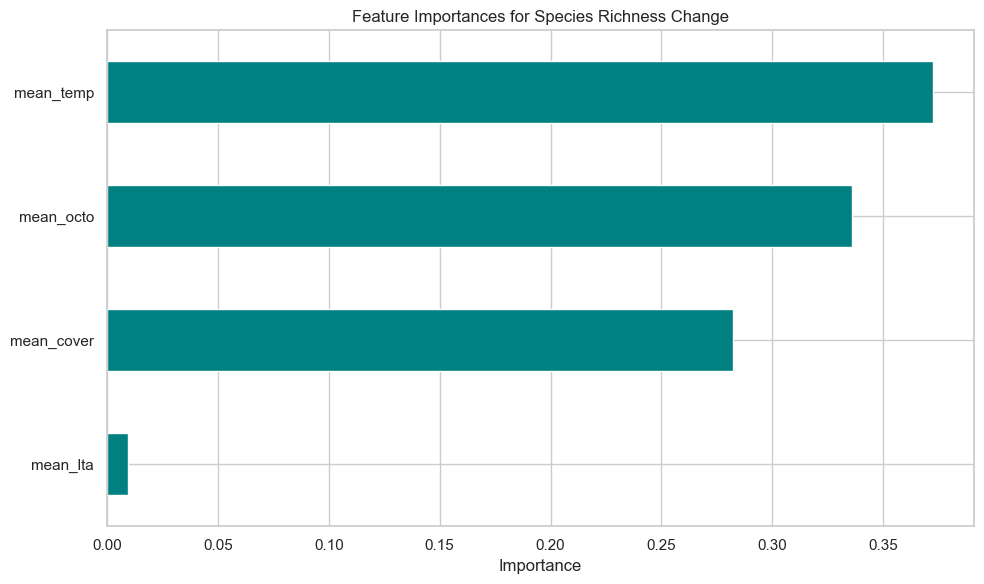

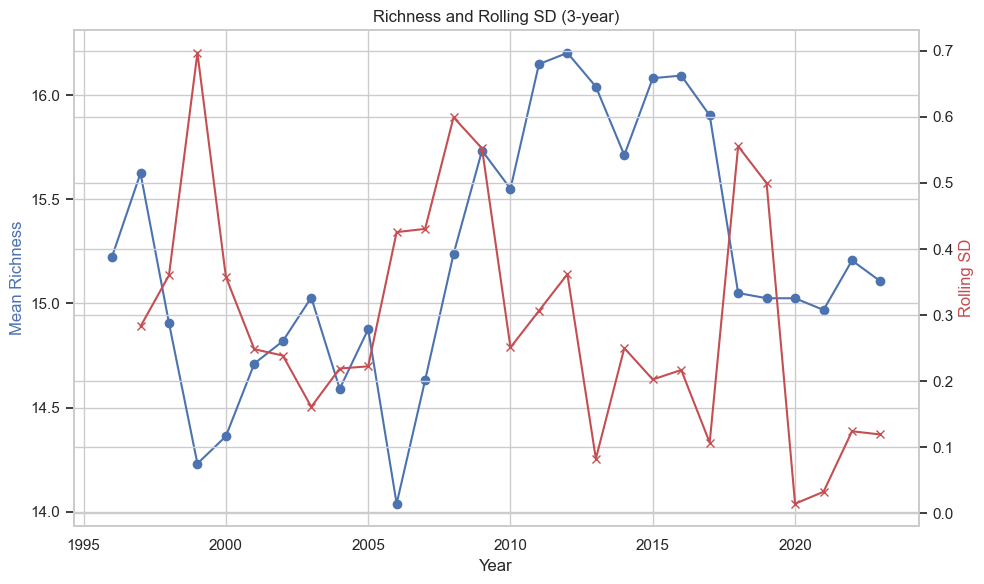

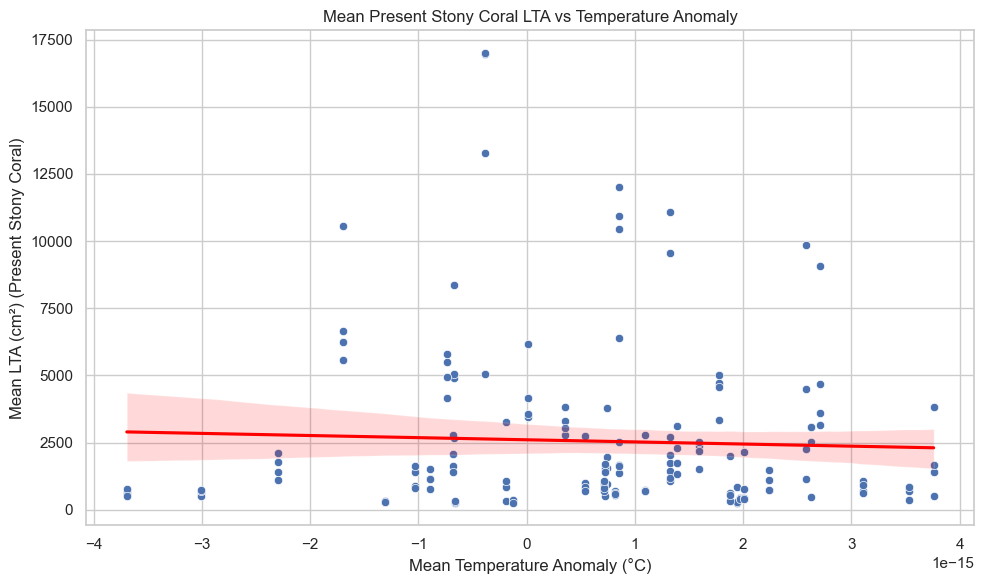

In [ ]:
from sklearn.ensemble import RandomForestRegressor
import folium

def run_section10():
    """
    Analyze drivers of richness change and early indicators.
    Loads data from processed_data/with_stations and monthly features.
    """
    try:
        # load processed tables
        df_pcover = load_processed("pcover_stony_species", version="with_stations")
        df_sc_lta = load_processed("scor_lta_summary", version="with_stations")
        df_octo = load_processed("octo_density_summary", version="with_stations")
        df_temp_monthly = pd.read_csv("My_work/processed_data/temperature_monthly_features.csv")
        # rename temperature summary column
        df_temp_monthly.rename(columns={'tempc_month_mean':'temp_mean'}, inplace=True)
        df_stations = load_processed("stations", version="with_stations")
        # map CREMP siteid to actual stationid for temperature data
        n0 = len(df_temp_monthly)
        df_temp_monthly = df_temp_monthly.merge(
            df_stations[['siteid','stationid']], on='siteid', how='left'
        )
        print(f"Mapped {len(df_temp_monthly)} of {n0} temp records to stations")
        # ensure numeric stationid and drop unmapped rows
        df_temp_monthly['stationid'] = pd.to_numeric(df_temp_monthly['stationid'], errors='coerce')
        df_temp_monthly.dropna(subset=['stationid'], inplace=True)
        df_temp_monthly['stationid'] = df_temp_monthly['stationid'].astype(int)
        print(f"After dropping unmapped: {len(df_temp_monthly)} temp records remain")
        # Ensure stationid in all biological data: merge on siteid if missing
        if 'stationid' not in df_pcover.columns and 'siteid' in df_pcover.columns:
            df_pcover = df_pcover.merge(df_stations[['siteid','stationid']], on='siteid', how='left')
        if 'stationid' not in df_sc_lta.columns and 'siteid' in df_sc_lta.columns:
            df_sc_lta = df_sc_lta.merge(df_stations[['siteid','stationid']], on='siteid', how='left')
        if 'stationid' not in df_octo.columns and 'siteid' in df_octo.columns:
            df_octo = df_octo.merge(df_stations[['siteid','stationid']], on='siteid', how='left')

        # 1. Feature importances for richness change
        # compute station-level features
        # richness
        species_cols = [c for c in df_pcover.columns if c not in (
            ['oid_','year','date','subregion','habitat','siteid','site_name','stationid','surveyed_all_years','points']
        )]
        df_r = df_pcover.copy()
        # Ensure all species_cols are numeric to avoid '>' not supported between str and int
        df_r[species_cols] = df_r[species_cols].apply(pd.to_numeric, errors='coerce')
        df_r['richness'] = (df_r[species_cols] > 0).sum(axis=1)
        # first/last year change
        years = sorted(df_r['year'].unique())
        y0, y1 = years[0], years[-1]
        r0 = df_r[df_r.year==y0].groupby('stationid')['richness'].mean()
        r1 = df_r[df_r.year==y1].groupby('stationid')['richness'].mean()
        delta_r = (r1 - r0).rename('delta_richness')
        # features: mean cover, mean octo, mean LTA, mean temp
        feat = pd.DataFrame({'stationid': delta_r.index})
        feat = feat.set_index('stationid')
        feat['mean_cover'] = df_pcover.groupby('stationid')['scleractinia'].mean()
        feat['mean_octo'] = df_octo.groupby('stationid')['total_octocorals'].mean()
        feat['mean_lta'] = df_sc_lta.groupby('stationid')['scleractinia'].mean()
        feat['mean_temp'] = df_temp_monthly.groupby('stationid')['temp_mean'].mean()
        feat = feat.join(delta_r).dropna()
        X = feat[['mean_cover','mean_octo','mean_lta','mean_temp']]
        y = feat['delta_richness']
        if len(X) == 0:
            print("No data available for feature importance analysis. Skipping RandomForestRegressor plot.")
        else:
            rf = RandomForestRegressor(random_state=42, n_estimators=100)
            rf.fit(X, y)
            importances = pd.Series(rf.feature_importances_, index=X.columns).sort_values()
            plt.figure()
            importances.plot(kind='barh', color='teal')
            plt.title('Feature Importances for Species Richness Change')
            plt.xlabel('Importance')
            plt.tight_layout()
            plt.show()

        # 2. Early-warning: rolling SD of annual richness
        annual_r = df_r.groupby('year')['richness'].mean().reset_index()
        annual_r['rolling_sd'] = annual_r['richness'].rolling(window=3, min_periods=1).std()
        fig, ax1 = plt.subplots()
        ax2 = ax1.twinx()
        ax1.plot(annual_r['year'], annual_r['richness'], marker='o', color='b')
        ax2.plot(annual_r['year'], annual_r['rolling_sd'], marker='x', color='r')
        ax1.set_xlabel('Year')
        ax1.set_ylabel('Mean Richness', color='b')
        ax2.set_ylabel('Rolling SD', color='r')
        plt.title('Richness and Rolling SD (3-year)')
        plt.tight_layout()
        plt.show()

        # 3 & 4. Compute temperature anomaly from temperature_monthly_features
        # Anomaly = station-year temp_mean - that station's long-term mean
        df_temp = df_temp_monthly[['stationid', 'year', 'temp_mean']].copy()
        station_longterm = df_temp.groupby('stationid')['temp_mean'].mean().rename('station_longterm')
        df_temp = df_temp.merge(station_longterm, on='stationid')
        df_temp['temp_anomaly'] = df_temp['temp_mean'] - df_temp['station_longterm']

        # 3. Scatter: LTA vs temperature anomaly (mean per station, mean of present stony coral species)
        df_l = df_sc_lta.copy()
        # Identify stony coral species LTA columns (exclude metadata)
        meta_cols = ['oid_','year','date','subregion','habitat',
                     'siteid','site_name','stationid','surveyed_all_years',
                     'points']
        species_cols = [c for c in df_l.columns if c not in meta_cols]
        # Ensure numeric for each species column
        for c in species_cols:
            df_l[c] = pd.to_numeric(df_l[c], errors='coerce')
        # Compute mean LTA across only present species per row
        df_l['mean_present_lta'] = df_l[species_cols].apply(
            lambda r: r[r>0].mean() if (r>0).any() else float('nan'),
            axis=1
        )
        # Average per station
        la = df_l.groupby('stationid')['mean_present_lta'].mean()
        ta = df_temp.groupby('stationid')['temp_anomaly'].mean()
        df_sc = pd.DataFrame({'mean_present_lta': la, 'temp_anom': ta}).dropna()
        # Plot composite relationship
        plt.figure()
        sns.scatterplot(x='temp_anom', y='mean_present_lta', data=df_sc)
        sns.regplot(x='temp_anom', y='mean_present_lta',
                    data=df_sc, scatter=False, color='red')
        plt.xlabel('Mean Temperature Anomaly (°C)')
        plt.ylabel('Mean LTA (cm²) (Present Stony Coral)')
        plt.title('Mean Present Stony Coral LTA vs Temperature Anomaly')
        plt.tight_layout()
        plt.show()

        # 4. Station risk score: slope of LTA vs anomaly
        risk = []
        merged = df_l.merge(df_temp, on=['stationid','year'], how='inner')
        for sid, grp in merged.groupby('stationid'):
            x = grp['temp_anomaly']; y = grp['mean_present_lta']
            if len(x) < 2: continue
            slope = np.polyfit(x, y, 1)[0]
            risk.append({'stationid': sid, 'risk_score': -slope})
        df_risk = pd.DataFrame(risk).merge(df_stations[['stationid','latdd','londd']], on='stationid')
        m = folium.Map(location=[df_risk['latdd'].mean(), df_risk['londd'].mean()], zoom_start=8)
        for _, r in df_risk.iterrows():
            folium.CircleMarker(
                location=[r['latdd'], r['londd']],
                radius=5, fill=True,
                color="#%02x%02x%02x" % (255, 0, 0),
                fill_opacity=0.7,
                popup=f"Station {r['stationid']}: risk {r['risk_score']:.2f}"
            ).add_to(m)
        m.save('map_station_risk.html')

    except Exception as e:
        print(f"An error occurred: {e}")

if __name__ == "__main__":
    run_section10()

### Section 11 : Forecast Modeling

15:52:46 - cmdstanpy - INFO - Chain [1] start processing
15:52:47 - cmdstanpy - INFO - Chain [1] done processing


<Figure size 1000x600 with 0 Axes>

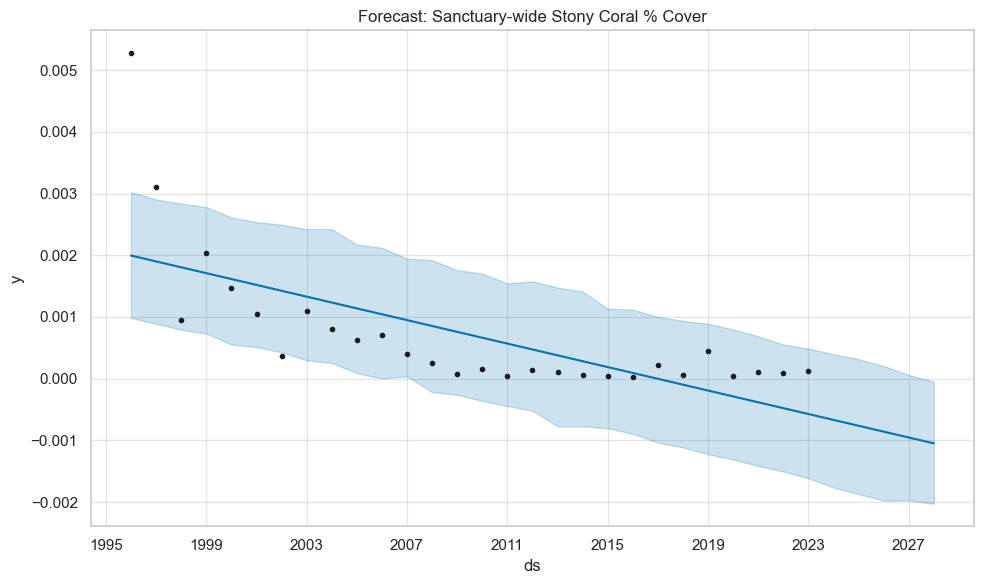

15:52:47 - cmdstanpy - INFO - Chain [1] start processing
15:52:47 - cmdstanpy - INFO - Chain [1] done processing


<Figure size 1000x600 with 0 Axes>

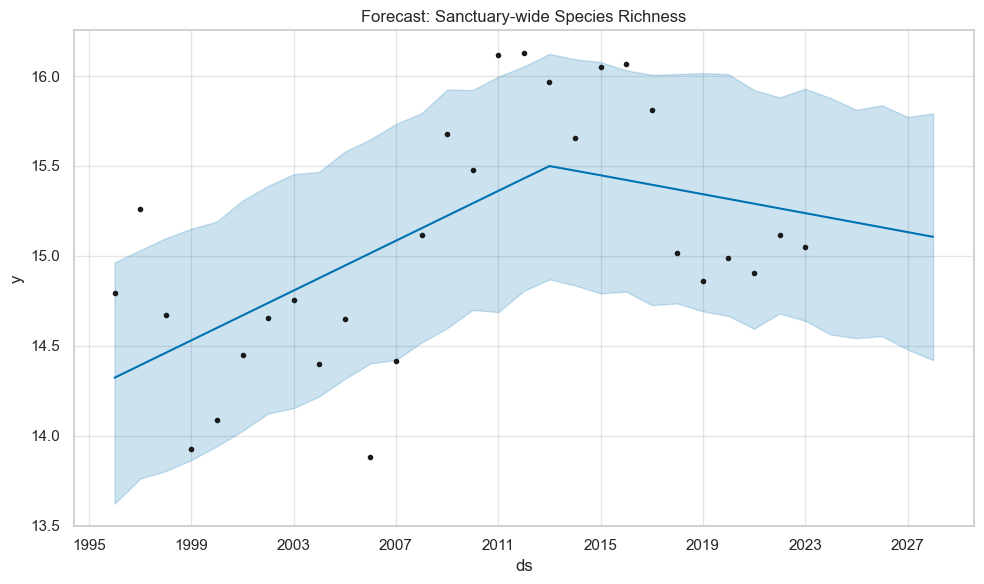

<Figure size 1000x600 with 0 Axes>

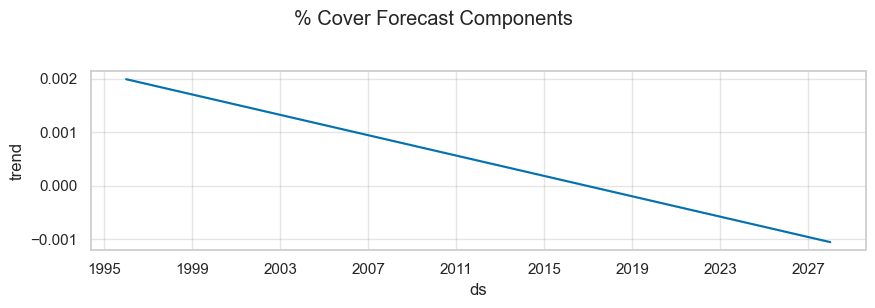

<Figure size 1000x600 with 0 Axes>

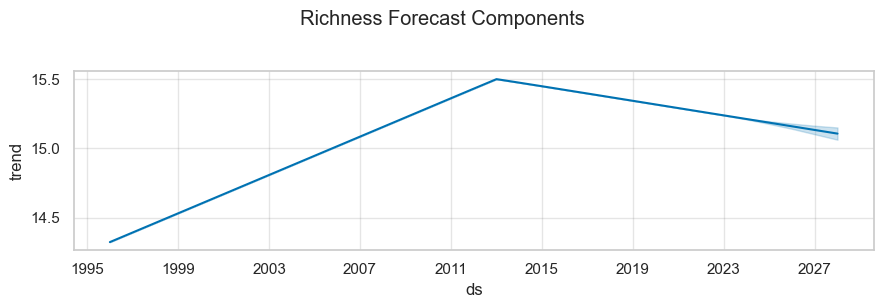

15:52:48 - cmdstanpy - INFO - Chain [1] start processing
15:52:48 - cmdstanpy - INFO - Chain [1] done processing


<Figure size 1000x600 with 0 Axes>

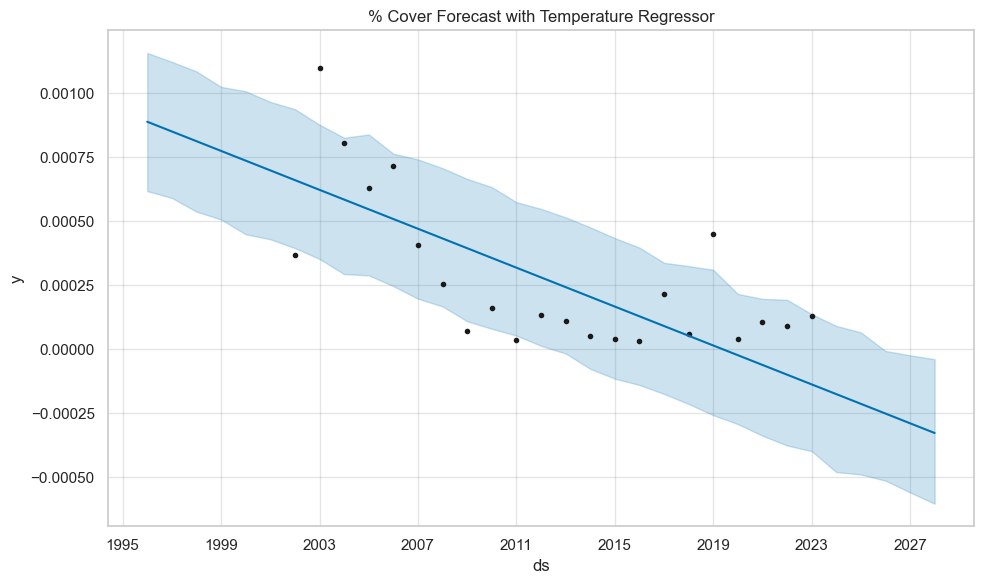

15:52:48 - cmdstanpy - INFO - Chain [1] start processing
15:52:48 - cmdstanpy - INFO - Chain [1] start processing
15:52:48 - cmdstanpy - INFO - Chain [1] start processing
15:52:48 - cmdstanpy - INFO - Chain [1] start processing
15:52:48 - cmdstanpy - INFO - Chain [1] start processing
15:52:48 - cmdstanpy - INFO - Chain [1] start processing
15:52:48 - cmdstanpy - INFO - Chain [1] start processing
15:52:48 - cmdstanpy - INFO - Chain [1] start processing
15:52:48 - cmdstanpy - INFO - Chain [1] start processing
15:52:48 - cmdstanpy - INFO - Chain [1] start processing
15:52:48 - cmdstanpy - INFO - Chain [1] start processing
15:52:48 - cmdstanpy - INFO - Chain [1] start processing
15:52:48 - cmdstanpy - INFO - Chain [1] start processing
15:52:48 - cmdstanpy - INFO - Chain [1] start processing
15:52:48 - cmdstanpy - INFO - Chain [1] start processing
15:52:48 - cmdstanpy - INFO - Chain [1] start processing
15:52:48 - cmdstanpy - INFO - Chain [1] start processing
15:52:48 - cmdstanpy - INFO - C

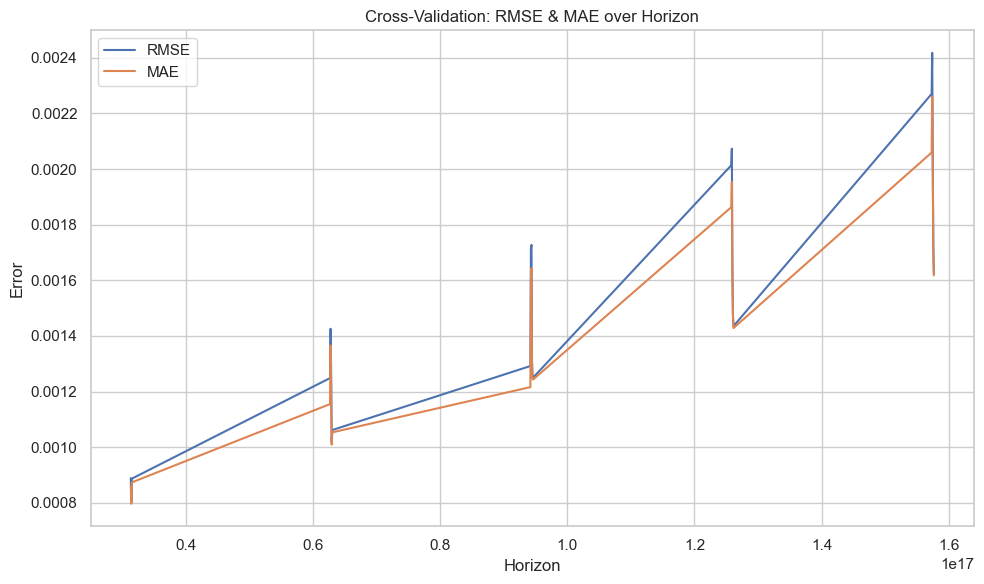

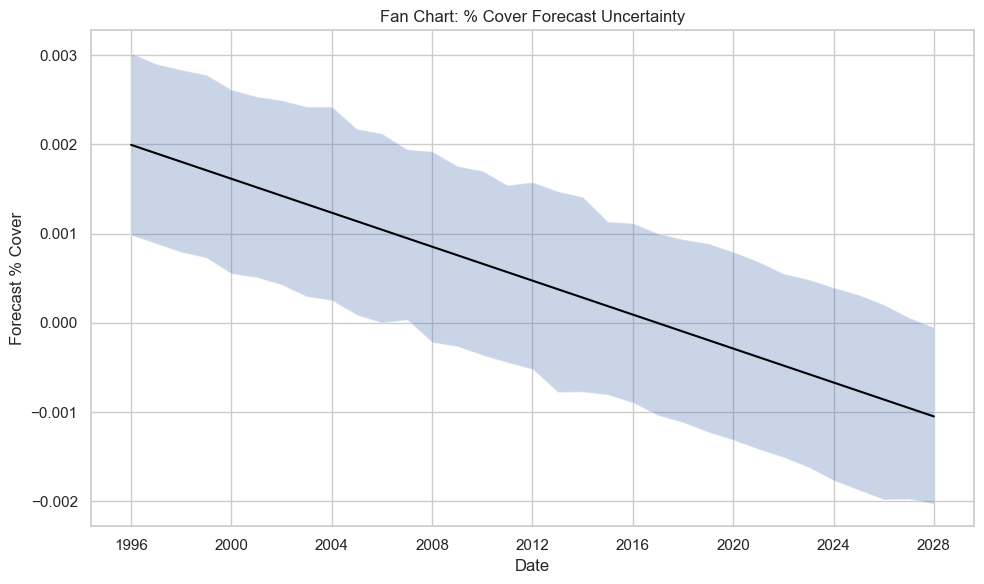

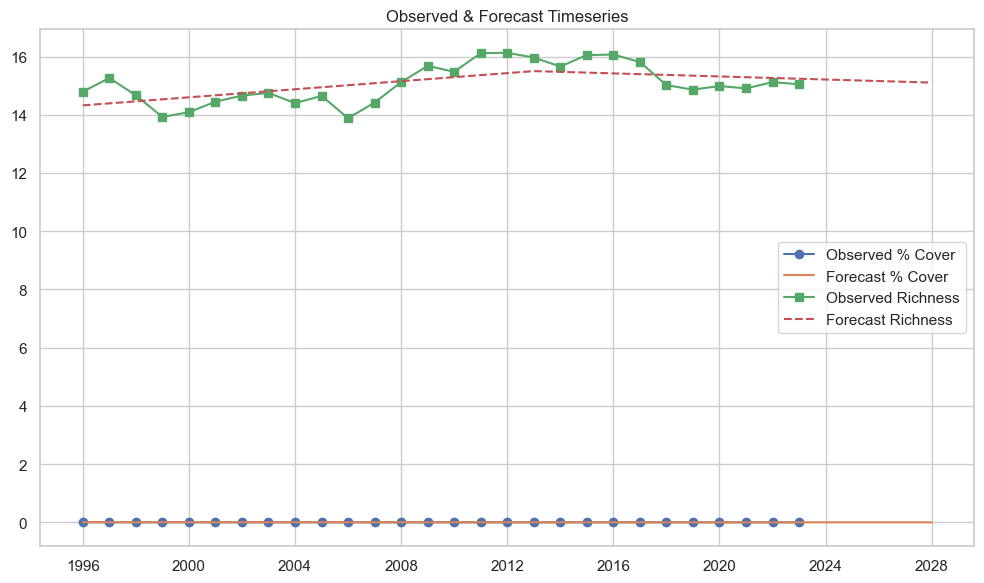

In [ ]:
"""
Module: Section 11 – Forecast Modeling
Generates seven plots:
1. Prophet forecast of sanctuary-wide stony coral % cover
2. Prophet forecast of sanctuary-wide species richness
3. Forecast components for both time series
4. Forecast of % cover with temperature regressor
5. Cross-validation RMSE/MAE over horizon
6. Fan-chart (uncertainty interval) for % cover forecast
7. Combined observed + forecast timelines
"""

from prophet import Prophet
from prophet.diagnostics import cross_validation, performance_metrics

def run_section11():
    # load processed tables
    df_pcover = load_processed("pcover_stony_species", version="with_stations")
    df_temp_monthly = pd.read_csv("My_work/processed_data/temperature_monthly_features.csv")
    df_temp_monthly = df_temp_monthly.rename(columns={'tempc_month_mean':'temp_mean'})

    # Prepare sanctuary-wide annual % cover
    df_cover = df_pcover.groupby('year')['scleractinia'].mean().reset_index()
    df_cover['ds'] = pd.to_datetime(df_cover['year'].astype(int).astype(str) + '-01-01')
    df_cover = df_cover.rename(columns={'scleractinia': 'y'})

    # 1. Forecast % cover
    m_cover = Prophet(yearly_seasonality=False)
    m_cover.fit(df_cover[['ds', 'y']])
    future_cover = m_cover.make_future_dataframe(periods=5, freq='YE')
    fc_cover = m_cover.predict(future_cover)
    plt.figure()
    m_cover.plot(fc_cover)
    plt.title('Forecast: Sanctuary-wide Stony Coral % Cover')
    plt.tight_layout()
    plt.show()

    # 2. Forecast species richness
    # compute annual richness
    species_cols = [c for c in df_pcover.columns if c not in (
        ['oid_','year','date','subregion','habitat','siteid',
         'site_name','stationid','surveyed_all_years','points','scleractinia']
    )]
    df_rich = df_pcover.copy()
    # ensure species columns numeric for richness count
    df_rich[species_cols] = df_rich[species_cols].apply(pd.to_numeric, errors='coerce')
    df_rich['richness'] = (df_rich[species_cols] > 0).sum(axis=1)
    df_rich_ann = df_rich.groupby('year')['richness'].mean().reset_index()
    df_rich_ann['ds'] = pd.to_datetime(df_rich_ann['year'].astype(int).astype(str) + '-01-01')
    df_rich_ann = df_rich_ann.rename(columns={'richness': 'y'})
    m_rich = Prophet(yearly_seasonality=False)
    m_rich.fit(df_rich_ann[['ds', 'y']])
    future_rich = m_rich.make_future_dataframe(periods=5, freq='YE')
    fc_rich = m_rich.predict(future_rich)
    plt.figure()
    m_rich.plot(fc_rich)
    plt.title('Forecast: Sanctuary-wide Species Richness')
    plt.tight_layout()
    plt.show()

    # 3. Forecast components
    plt.figure()
    m_cover.plot_components(fc_cover)
    plt.suptitle('% Cover Forecast Components', y=1.02)
    plt.tight_layout()
    plt.show()
    plt.figure()
    m_rich.plot_components(fc_rich)
    plt.suptitle('Richness Forecast Components', y=1.02)
    plt.tight_layout()
    plt.show()

    # 4. Forecast % cover with temperature regressor
    # annual mean temperature
    temp_ann = df_temp_monthly.groupby('year')['temp_mean'].mean().reset_index()
    df_cov2 = df_cover.merge(temp_ann, on='year', how='left').dropna()
    df_cov2 = df_cov2.rename(columns={'temp_mean': 'temp'})
    m_cov2 = Prophet(yearly_seasonality=False)
    m_cov2.add_regressor('temp')
    m_cov2.fit(df_cov2[['ds', 'y', 'temp']])
    future_cov2 = future_cover.copy()
    mean_temp = temp_ann['temp_mean'].mean()
    future_cov2['temp'] = mean_temp
    fc_cov2 = m_cov2.predict(future_cov2)
    plt.figure()
    m_cov2.plot(fc_cov2)
    plt.title('% Cover Forecast with Temperature Regressor')
    plt.tight_layout()
    plt.show()

    # 5. Cross-validation metrics (cover model)
    df_cv = cross_validation(
        m_cover,
        initial='1825 days',  # ~5 years
        period='365 days',    # 1 year
        horizon='1825 days',  # ~5 years
        parallel='threads'
    )
    df_p = performance_metrics(df_cv)
    plt.figure()
    sns.lineplot(x='horizon', y='rmse', data=df_p, label='RMSE')
    sns.lineplot(x='horizon', y='mae', data=df_p, label='MAE')
    plt.title('Cross-Validation: RMSE & MAE over Horizon')
    plt.xlabel('Horizon')
    plt.ylabel('Error')
    plt.legend()
    plt.tight_layout()
    plt.show()

    # 6. Fan-chart (uncertainty intervals) for % cover
    plt.figure()
    plt.plot(fc_cover['ds'], fc_cover['yhat'], color='black')
    plt.fill_between(fc_cover['ds'], fc_cover['yhat_lower'], fc_cover['yhat_upper'], alpha=0.3)
    plt.title('Fan Chart: % Cover Forecast Uncertainty')
    plt.xlabel('Date')
    plt.ylabel('Forecast % Cover')
    plt.tight_layout()
    plt.show()

    # 7. Combined observed + forecast timeline
    plt.figure()
    plt.plot(df_cover['ds'], df_cover['y'], 'o-', label='Observed % Cover')
    plt.plot(fc_cover['ds'], fc_cover['yhat'], '-', label='Forecast % Cover')
    plt.plot(df_rich_ann['ds'], df_rich_ann['y'], 's-', label='Observed Richness')
    plt.plot(fc_rich['ds'], fc_rich['yhat'], '--', label='Forecast Richness')
    plt.legend()
    plt.title('Observed & Forecast Timeseries')
    plt.tight_layout()
    plt.show()

run_section11()

In [ ]:
import pandas as pd
from prophet import Prophet

# Load processed percent cover data
from My_work.Preprocessing import load_processed

def stationwise_forecast(min_years=3, forecast_years=5):
    df_pcover = load_processed("pcover_stony_species", version="with_stations")
    forecasts = []
    for sid, grp in df_pcover.groupby("stationid"):
        df_s = (
            grp.groupby("year")["scleractinia"].mean().reset_index().dropna()
        )
        if df_s['year'].nunique() < min_years:
            continue
        df_s["ds"] = pd.to_datetime(df_s.year.astype(str) + "-01-01")
        df_s["y"] = pd.to_numeric(df_s["scleractinia"], errors='coerce')
        df_s = df_s.dropna(subset=["y"])
        try:
            m = Prophet(yearly_seasonality=False)
            m.fit(df_s[["ds","y"]])
            fut = m.make_future_dataframe(periods=forecast_years, freq="YE")
            fc = m.predict(fut)
            fc["stationid"] = sid
            forecasts.append(fc[["stationid","ds","yhat"]])
        except Exception as e:
            print(f"Skipping station {sid} due to: {e}")
    if forecasts:
        all_fc = pd.concat(forecasts, ignore_index=True)
        all_fc.to_csv("My_work/processed_data/stationwise_forecast.csv", index=False)
        print(f"Forecasts saved for {all_fc['stationid'].nunique()} stations.")
    else:
        print("No station forecasts generated.")

if __name__ == "__main__":
    stationwise_forecast()


15:52:50 - cmdstanpy - INFO - Chain [1] start processing
15:52:51 - cmdstanpy - INFO - Chain [1] done processing
15:52:51 - cmdstanpy - INFO - Chain [1] start processing
15:52:51 - cmdstanpy - INFO - Chain [1] done processing
15:52:51 - cmdstanpy - INFO - Chain [1] start processing
15:52:51 - cmdstanpy - INFO - Chain [1] done processing
15:52:51 - cmdstanpy - INFO - Chain [1] start processing
15:52:52 - cmdstanpy - INFO - Chain [1] done processing
15:52:52 - cmdstanpy - INFO - Chain [1] start processing
15:52:52 - cmdstanpy - INFO - Chain [1] done processing
15:52:52 - cmdstanpy - INFO - Chain [1] start processing
15:52:52 - cmdstanpy - INFO - Chain [1] done processing
15:52:52 - cmdstanpy - INFO - Chain [1] start processing
15:52:52 - cmdstanpy - INFO - Chain [1] done processing
15:52:52 - cmdstanpy - INFO - Chain [1] start processing
15:52:52 - cmdstanpy - INFO - Chain [1] done processing
15:52:52 - cmdstanpy - INFO - Chain [1] start processing
15:52:52 - cmdstanpy - INFO - Chain [1]

Forecasts saved for 184 stations.


In [ ]:
"""
Section 12 – Automated Report & Conservation Recommendations
This script generates a summary report (HTML/Markdown) with all key findings, statistical results, visual aids, and actionable recommendations for policy/conservation.
"""
import os
from datetime import datetime

def generate_report(output_path="report_summary.md"):
    sections = [
        "section3_pcover.py", "section4_richness.py", "section5_octo_density.py", "section6_lta_diff.py", "section7_spatial_patterns.py", "section8_regional_comparison.py", "section9_correlations.py", "section10_drivers_indicators.py", "section11_forecast.py"
    ]
    with open(output_path, "w", encoding="utf-8") as f:
        f.write(f"# Florida Keys Coral Reef Evaluation Report\n")
        f.write(f"*Generated: {datetime.now().strftime('%Y-%m-%d %H:%M')}*\n\n")
        f.write("## Executive Summary\n")
        f.write("- Key trends, drivers, and early warnings are summarized below.\n\n")
        for sec in sections:
            f.write(f"## Section: {sec}\n")
            f.write(f"Results and plots from `{sec}`. See notebook/scripts for details.\n\n")
        f.write("## Actionable Recommendations\n")
        f.write("- Prioritize monitoring stations with significant declines or risk signals.\n")
        f.write("- Focus conservation on segments with persistent low cover/richness.\n")
        f.write("- Use temperature anomaly as an early warning for intervention.\n")
        f.write("- Further investigate drivers with high feature importance.\n")
        f.write("- Update forecasts and risk maps annually.\n")
    print(f"Report written to {output_path}")

if __name__ == "__main__":
    generate_report()


Report written to report_summary.md
